 This notebook uses a vanilla (basic) Bayesian optimization algorithm to tackle an urban travel demand (i.e.,  origin-destination, OD) calibration problem. The traffic simulations are based on the SUMO simulator. It considers a toy network, called quickstart detailed here:
 https://sumo.dlr.de/docs/Tutorials/quick_start.html

# Install sumo

In [5]:
import importlib
import helpers_od_calibration_BN
importlib.reload(helpers_od_calibration_BN)

<module 'helpers_od_calibration_BN' from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/helpers_od_calibration_BN.py'>

Mount GDrive

If you are working w/ colab rather than a jupyterlab notebook this drive mounting and sumo installation will need to be done every time you restart the runtime.


Install SUMO

In [ ]:
import os
from pathlib import Path 
import sys
%matplotlib inline

from src.optimization 

os.environ['SUMO_HOME'] = '/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'
os.environ['LIBSUMO_AS_TRACI'] = '1' #Optional: for a huge performance boost (~8x) with Libsumo (No GUI)
SUMO_HOME = Path(os.environ['SUMO_HOME'])

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
#import traci


import json, shutil
from pathlib import Path

# Add the SUMO *bin* directory to PATH so od2trips/duarouter/sumo are found
# Your SUMO_HOME is .../EclipseSUMO/share/sumo → bin is two levels up, then /bin
SUMO_ROOT = Path(os.environ["SUMO_HOME"]).parents[1]          # .../EclipseSUMO
SUMO_BIN  = str(SUMO_ROOT / "bin") # this convert path to /EclipseSUMO/bin
LIB_SUMO_PATH = Path(os.environ["SUMO_HOME"]).parents[2] / "lib" / "libsumo.dylib"

os.environ["PATH"] = SUMO_BIN + os.pathsep + os.environ.get("PATH", "")

import traci
import sumolib


base_path = '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn'
# if base_path has a space in it, the sumo code will not work
if ' ' in base_path:
    raise ValueError("base_path should not contain any spaces.")

os.chdir(base_path)



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import seaborn as sns
from pathlib import Path

import torch
from torch.quasirandom import SobolEngine

from botorch import fit_gpytorch_mll
from botorch.acquisition import qLogExpectedImprovement
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize, normalize

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize



from helpers_od_calibration_BN import (load_kwargs_config,
                    compute_nrmse_counts_all_edges,
                    parse_loop_data_xml_to_pandas,
                    create_taz_xml,
                    simulate_od,
                    od_xml_to_df,
                    compute_nrmse_counts_all_edges,
                    )

config = load_kwargs_config(
    base_path,
    "bo_vanilla",
    sim_setup_filename="sim_setup_network_2corridor.json"
)
Path(config["simulation_run_path"]).mkdir(parents=True, exist_ok=True)
pprint.pprint(dict(config))

/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo/tools/traci/__init__.py:42: UserWarning: Could not import libsumo using /Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/bin/python, falling back to pure python traci (No module named 'libsumo').
  warnings.warn("Could not import libsumo using %s, falling back to pure python traci (%s)." %


{'BATCH_SIZE': 1,
 'EDGE_OUT_STR': 'edge_data.xml',
 'NITER': 100,
 'NUM_RESTARTS': 16,
 'RAW_SAMPLES': 256,
 'SAMPLE_SHAPE': 64,
 'SUMO_PATH': PosixPath('/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'),
 'TRIPS2ODS_OUT_STR': 'trips.xml',
 'additional_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml'),
 'file_gt_od': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/od.xml'),
 'fixed_routes': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/routes_single.csv'),
 'model_name': 'bo_vanilla',
 'n_init_search': 20,
 'net_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml'),
 'network_name': 'network_2corridor',
 'network_path': PosixPath('network/network_2corridor'),
 'od_duration_sec': 3600,
 'sim_end_time': 3900,
 'sim_start_time': 0,
 'sim_stat_freq_sec': 300,
 'simul

# Macros / utils

In [7]:
# install missing packages
#!pip install gpytorch
#!pip install botorch
#!pip install matplotlib
#!pip install pandas
#!pip install seaborn 

# library import 

# Create GT (ground truth) scenario

In [8]:
# Get Ground Truth OD + fixed routes
print(f"Reading: {config['file_gt_od']}")
gt_od_df = od_xml_to_df(config["file_gt_od"])

print(f"Reading: {config['fixed_routes']}")
routes_df = pd.read_csv(config["fixed_routes"], index_col=0)

Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/od.xml
Total GT demand: 23261.0
Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/routes_single.csv


Simulate the GT scenario to obtain the GT traffic statistics

In [9]:
#not installed in virtual env 
#import sys
#!{sys.executable} -m pip install lxml

In [10]:
!pip install lxml


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


### simulate the GT scenario to obtain the GT traffic statitics 

In [11]:
simulation_gt_run_path = f"{config['simulation_run_path']}/ground_truth"
prefix_output_gt = f"{simulation_gt_run_path}/sim"
sim_edge_out_gt = f"{prefix_output_gt}_{config['EDGE_OUT_STR']}"
new_od_xml = f"{simulation_gt_run_path}/od.xml"

Path(simulation_gt_run_path).mkdir(parents=True, exist_ok=True)

base_od = gt_od_df.copy()
curr_od = base_od['count'].astype(float).to_numpy()
base_od['count'] = curr_od
base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})

create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

simulate_od(
    new_od_xml,
    prefix_output_gt,
    base_path,
    config["net_xml"],
    config["taz2edge_xml"],
    config["additional_xml"],
    routes_df,
    config["sim_end_time"],
    config["TRIPS2ODS_OUT_STR"]
)

Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/ground_truth/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/ground_truth/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/ground_truth/sim_trips_beforeRteUpdates.xml
Success.time 3598.89
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/ground_truth/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/ground_truth/sim_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes ro

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (5ms ~= 200.00*RT, ~252600.00UPS, vehicles TOT 12105 ACT 1263 BUF 11156)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.26s
 Real time factor: 380.043
 UPS: 471596.180082
Vehicles:
 Inserted: 12105 (Loaded: 23261)
 Running: 1263
 Waiting: 11156
Statistics (avg of 10842):
 RouteLength: 3400.06
 Speed: 13.97
 Duration: 353.52
 WaitingTime: 1.51
 TimeLoss: 208.99
 DepartDelay: 295.38
DijkstraRouter answered 28380 queries and explored 22.41 edges on average.
DijkstraRouter spent 0.08s answering queries (0.00ms on average).


In [12]:
df_edge_gt, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out_gt, prefix_output_gt, config["SUMO_PATH"])






num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)
gt_edge_data = df_edge_gt\
    .sort_values(by=['interval_nVehContrib'], ascending=False)\
    .iloc[:num_gt_edges]

print(sim_edge_out_gt)

Number of GT edges: 51
output/network_2corridor_bo_vanilla/ground_truth/sim_edge_data.xml


### Run simulation to produce the traffic on eachlink given the ground trutch demand for each od pair, so here we simulate the GT scenario to obtain the GT traffic statitics 

Read and process the GT simulation outputs

In [13]:

print(gt_edge_data)

                       edge_id  interval_nVehContrib  \
17   479773097-AddedOnRampEdge                  6550   
41   867204830-AddedOnRampEdge                  6498   
39                   867204830                  6489   
40  867204830-AddedOffRampEdge                  6487   
16                   479773097                  6462   
14                   479773096                  6368   
15  479773096-AddedOffRampEdge                  6348   
27                   509747331                  5206   
38                   867204829                  5117   
24                   509747295                  5117   
23                   509747288                  5111   
25                   509747324                  4766   
35                   687721986                  4766   
26   509747324-AddedOnRampEdge                  4766   
5                    395318356                  4101   
50                     8954447                  3897   
32   617259144-AddedOnRampEdge                  

## implementation of mogp (fitting ) : fitting gp independently for each of the link flows (all using the OD matrix as an input), and concatenate them as a list Inspect link-level GP fitting result



wrap independent GP models into a convenient Multi-Output GP model using a ModelList.
Here we treat each outcome independently. This is equivalent to setting up a separate GP for each outcome. 


declare the parameters space

In [14]:
device = torch.device("gpu" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dtype = torch.float64

dim_od = gt_od_df.shape[0]
print(dim_od)

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype) #create a tensor [2, 4 ] filled with 0s and 2000s

# to make sure only physocally meaningful demand values are explored 
#    # Min: no vehicles and Max: 2000 vehicles per OD
#prevent suggesting unrealistic values 

print("bounds matrix:",bounds)

Using device: cpu
21
bounds matrix: tensor([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
         2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
         2000.]], dtype=torch.float64)


## Create and simulate a sample of initial input points (i.e., ODs).
RUN SOBOL SAMPLING (COLLECT DATA)

5 samples are used as inital training data so we will get 5 initial points training prediction 

1 observation → GP can't learn patterns
5 observations → GP can start modeling relationships
More initial samples → better initial GP, but more expensive

In [15]:
# Sample according to Sobol, drawn are quasi random so need multiple restart !! 
# quasi bc they cover the aparameters space more evenly than pure randomness, they avoid lcuster and gaps so better coverage of space 
#it ensure we can explore differnt regions 
#better initial data, bette gp, better optimization 

seed = 42  

torch.manual_seed(seed)

np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print(f"Random seed set to {seed}")



sobol = SobolEngine(dim_od, scramble=True, seed = seed) #Sobol sequences are an example of low discrepancy quasi-random sequences.
#using seed for reproducibility
x_0 = sobol.draw(config["n_init_search"]).to(dtype=dtype).to(device) # generate n_init_search samples, here 5
print (x_0.shape)
#x_0 shape: torch.Size([5, 4]) meaning 5 samples of 4 dimensions each
# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)
print (train_X0)  #5 samples of 4 dimensions each


print (dim_od)
#4 dimension, 4OD pairs
#so we have 4 pairs so 4 demand values to optimize

Random seed set to 42
torch.Size([20, 21])
tensor([[1995.0267,  208.7328, 1645.9577,  838.8643, 1056.6442,  112.4814,
          910.5846, 1498.4061,  442.1483, 1235.3967, 1620.1895,  424.5811,
           76.8722, 1763.6480, 1301.2593, 1333.1703, 1641.8632, 1193.1571,
          472.6151, 1613.9487,  334.2874],
        [  57.3551, 1496.5136,  224.1529, 1034.3661,   68.6411, 1638.0646,
         1126.1221,  371.2380, 1489.2815,  275.1244,  427.1543, 1754.9608,
         1361.3771,  688.0627,  422.7808,  381.8277,  870.4802,  384.3589,
         1190.8222,  718.8758, 1254.2589],
        [ 802.7174,  560.0206, 1008.2554,  332.2719,  831.8899, 1257.5989,
          222.3803,  637.7038, 1993.9388,  556.7673,  973.7991, 1018.7044,
          889.5292, 1128.8687,  831.6194, 1833.3936,  423.0999, 1505.8671,
         1656.2229, 1015.0840,  790.3093],
        [1239.9006, 1770.1647,  617.7125, 1544.8638, 1796.4624,  993.6885,
         1944.2205, 1515.1131,  945.3723, 1955.6307, 1042.3532,  661.0953,
   

# computing the loss per edge with the simulated innitial sobol OD vector / Training points 

In [16]:
from helpers_od_calibration import compute_nrmse_per_edge

ods_epsilon = [] # for storing the different od matrices generated
loss_all = []  # Overall loss for monitoring
loss_per_edge_all = []  # Per-edge losses
batch_data_i = []
edge_counts_all = []

edge_ids = None
base_od = gt_od_df.copy() # Ground Truth OD
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i, x in enumerate(train_X0.tolist()):
    print(f"\n########### OD Sample {i+1}/{config['n_init_search']} ###########")
    print(f"OD config: {x}")

    # Create output directory
    simulation_run_path_init = f'{config["simulation_run_path"]}/initial_search'
    Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)

    new_od_xml = f"{simulation_run_path_init}/gt_od_{config['network_name']}_{i}.xml"
    prefix_output_init = f'{simulation_run_path_init}/sobol_{i}'

    # Generate OD
    curr_od = np.array(x)
    print(f'Total expected demand: {np.sum(curr_od):.1f} vehicles')

    # Create OD xml file
    base_od_temp = base_od.copy() 
    base_od_temp['count'] = curr_od
    base_od_temp['count'] = [round(elem, 1) for elem in base_od_temp['count']]
    base_od_renamed = base_od_temp.rename(columns={'fromTaz':'from', 'toTaz':'to'})
    create_taz_xml(new_od_xml, base_od_renamed, config["od_duration_sec"], base_path)
    
    ods_epsilon.append(curr_od)

    # Run SUMO simulation
    print("Running SUMO simulation...")
    simulate_od(new_od_xml,
                prefix_output_init,
                base_path,
                config["net_xml"],
                config["taz2edge_xml"],
                config["additional_xml"],
                routes_df,
                config["sim_end_time"],
                config["TRIPS2ODS_OUT_STR"])

    # Parse edge data
    sim_edge_out = f'{base_path}/{prefix_output_init}_{config["EDGE_OUT_STR"]}'
    curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
        base_path, sim_edge_out, prefix_output_init, config["SUMO_PATH"]
    )
    
    # Get edge_ids from first iteration in order to use it for fitting the gps
    if edge_ids is None:
        edge_ids = curr_loop_stats['edge_id'].tolist()
        print(f"Using {len(edge_ids)} edges: {edge_ids}")
    
    # Extract edge counts
    curr_edge_counts = curr_loop_stats.set_index('edge_id').loc[edge_ids, 'interval_nVehContrib'].values
    edge_counts_all.append(curr_edge_counts)
    
    # Compute overall loss (for monitoring)
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)
    loss_all.append(curr_loss)
    
    # Compute per-edge loss
    curr_loss_per_edge = compute_nrmse_per_edge(gt_edge_data, curr_loop_stats, edge_ids)
    loss_per_edge_all.append(curr_loss_per_edge)
    
    print(f"Overall loss (NRMSE): {curr_loss:.6f}")
    print(f"Per-edge losses - min: {curr_loss_per_edge.min():.6f}, max: {curr_loss_per_edge.max():.6f}, mean: {curr_loss_per_edge.mean():.6f}")

    # Store data from original code
    df_curr = pd.DataFrame(curr_od.reshape(1, dim_od),
                          columns=[f"x_{i+1}" for i in range(dim_od)])
    df_curr['loss_overall'] = curr_loss
    
    # Add edge counts and per-edge losses
    for j, edge_id in enumerate(edge_ids):
        df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
        df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
    
    batch_data_i.append(df_curr)

# Save initial dataset
df_initial_bo = pd.concat(batch_data_i, ignore_index=True)
initial_csv_path = f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv"
df_initial_bo.to_csv(initial_csv_path, index=None)
print(f"\nSaved initial results to: {initial_csv_path}")



########### OD Sample 1/20 ###########
OD config: [1995.026707649231, 208.73278379440308, 1645.9577083587646, 838.8643264770508, 1056.6442012786865, 112.48141527175903, 910.584568977356, 1498.4060525894165, 442.14826822280884, 1235.3967428207397, 1620.1895475387573, 424.5811402797699, 76.87224447727203, 1763.6480331420898, 1301.2592792510986, 1333.1702947616577, 1641.863226890564, 1193.1570768356323, 472.6150929927826, 1613.9487028121948, 334.2874348163605]
Total expected demand: 21719.8 vehicles
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/gt_od_network_2corridor_0.xml
Running SUMO simulation...
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/initial_search/gt_od_network_2corridor_0.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (5ms ~= 200.00*RT, ~219600.00UPS, vehicles TOT 11188 ACT 1098 BUF 10531)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.82s
 Real time factor: 442.227
 UPS: 555224.515251
Vehicles:
 Inserted: 11188 (Loaded: 21719)
 Running: 1098
 Waiting: 10531
Statistics (avg of 10090):
 RouteLength: 4183.02
 Speed: 12.94
 Duration: 411.34
 WaitingTime: 2.23
 TimeLoss: 242.68
 DepartDelay: 335.61
DijkstraRouter answered 26051 queries and explored 24.07 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
Using 51 edges: ['11531386', '394165856', '394165857', '394170678', '394170681#0', '395318356', '395358019', '416220210#0', '417524818', '456092814', '456092817#0', '479773094', '479773095', '479773095-AddedOffRampEdge', '479773096', '479773096-AddedOffRampEdge', '479773097', '479773097-AddedOnRampEdge', '509747213', '509747233', '509747233-AddedOnRampEdge', '509747272', '509747283', '509

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_1_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_1_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initia

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~521666.67UPS, vehicles TOT 11555 ACT 1565 BUF 5682)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.51s
 Real time factor: 864.745
 UPS: 1112543.015521
Vehicles:
 Inserted: 11555 (Loaded: 17237)
 Running: 1565
 Waiting: 5682
Statistics (avg of 9990):
 RouteLength: 3301.21
 Speed: 12.76
 Duration: 386.21
 WaitingTime: 1.30
 TimeLoss: 245.82
 DepartDelay: 281.26
DijkstraRouter answered 21539 queries and explored 22.59 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.625755
Per-edge losses - min: 0.000003, max: 8.624259, mean: 0.625755

########### OD Sample 3/20 ###########
OD config: [802.717387676239, 560.0206255912781, 1008.2553625106812, 332.271933555603, 831.8898677825928, 1257.598876953125, 222.38034009933472, 637.7037763595581, 1993.9388036727905, 556.7672848701477, 973.7991094589233, 1018.7044143676758, 889.529168605804

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_2_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_2_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initia

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~943000.00UPS, vehicles TOT 10901 ACT 1886 BUF 9371)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.46s
 Real time factor: 603.809
 UPS: 958121.381019
Vehicles:
 Inserted: 10901 (Loaded: 20272)
 Running: 1886
 Waiting: 9371
Statistics (avg of 9015):
 RouteLength: 3729.93
 Speed: 12.29
 Duration: 521.32
 WaitingTime: 1.83
 TimeLoss: 365.96
 DepartDelay: 317.48
DijkstraRouter answered 25049 queries and explored 22.19 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.467282
Per-edge losses - min: 0.000032, max: 8.329434, mean: 0.467282

########### OD Sample 4/20 ###########
OD config: [1239.9005889892578, 1770.1647281646729, 617.7124977111816, 1544.8638200759888, 1796.4624166488647, 993.6885237693787, 1944.2205429077148, 1515.113115310669, 945.3722834587097, 1955.6306600570679, 1042.3531532287598, 661.0953211784363, 1674.1789579

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_3_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_3_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initia

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~487000.00UPS, vehicles TOT 14213 ACT 1461 BUF 11528)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.50s
 Real time factor: 410.397
 UPS: 565070.609281
Vehicles:
 Inserted: 14213 (Loaded: 25741)
 Running: 1461
 Waiting: 11528
Statistics (avg of 12752):
 RouteLength: 3614.68
 Speed: 13.67
 Duration: 350.36
 WaitingTime: 1.54
 TimeLoss: 202.22
 DepartDelay: 267.40
DijkstraRouter answered 32266 queries and explored 24.38 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.346882
Per-edge losses - min: 0.000099, max: 8.213435, mean: 0.346882

########### OD Sample 5/20 ###########
OD config: [1268.8524723052979, 988.6295795440674, 330.61590790748596, 1852.891445159912, 1670.6719398498535, 363.4827435016632, 354.1649580001831, 933.4617257118225, 1562.9404783248901, 169.0690964460373, 523.8807201385498, 906.9020748138428, 611.507117748

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_4_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_4_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initia

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~728500.00UPS, vehicles TOT 11690 ACT 1457 BUF 9189)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.57s
 Real time factor: 594.059
 UPS: 803507.844631
Vehicles:
 Inserted: 11690 (Loaded: 20879)
 Running: 1457
 Waiting: 9189
Statistics (avg of 10233):
 RouteLength: 3797.06
 Speed: 10.65
 Duration: 454.50
 WaitingTime: 2.38
 TimeLoss: 298.85
 DepartDelay: 373.62
DijkstraRouter answered 26923 queries and explored 22.46 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.254034
Per-edge losses - min: 0.000227, max: 2.992754, mean: 0.254034

########### OD Sample 6/20 ###########
OD config: [706.1657309532166, 1716.3516283035278, 1783.635139465332, 16.187692061066628, 705.6182622909546, 1885.2322101593018, 1578.1110525131226, 1806.2996864318848, 611.0526323318481, 1317.9380893707275, 1458.9890241622925, 1272.9336023330688, 1826.74264

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_5_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_5_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initia

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (5ms ~= 200.00*RT, ~585000.00UPS, vehicles TOT 12478 ACT 2925 BUF 12554)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.66s
 Real time factor: 450.45
 UPS: 925305.035805
Vehicles:
 Inserted: 12478 (Loaded: 25032)
 Running: 2925
 Waiting: 12554
Statistics (avg of 9553):
 RouteLength: 3055.83
 Speed: 11.14
 Duration: 518.22
 WaitingTime: 1.99
 TimeLoss: 387.89
 DepartDelay: 236.94
DijkstraRouter answered 30066 queries and explored 22.36 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.525778
Per-edge losses - min: 0.000037, max: 8.423187, mean: 0.525778

########### OD Sample 7/20 ###########
OD config: [465.20179510116577, 277.90573239326477, 952.6864886283875, 1351.1828184127808, 444.45282220840454, 1000.8448362350464, 544.3642735481262, 1195.806384086609, 122.53917008638382, 1599.6496677398682, 1881.1545372009277, 1501.2537240982056, 424.292773

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_6_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_6_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initia

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1434500.00UPS, vehicles TOT 10764 ACT 2869 BUF 4238)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 3.70s
 Real time factor: 1054.34
 UPS: 1542372.533117
Vehicles:
 Inserted: 10764 (Loaded: 15002)
 Running: 2869
 Waiting: 4238
Statistics (avg of 7895):
 RouteLength: 3487.14
 Speed: 15.32
 Duration: 332.90
 WaitingTime: 0.78
 TimeLoss: 184.81
 DepartDelay: 229.43
DijkstraRouter answered 17764 queries and explored 24.38 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.135502
Per-edge losses - min: 0.000048, max: 1.570421, mean: 0.135502

########### OD Sample 8/20 ###########
OD config: [1527.4003744125366, 1052.0144701004028, 1436.9534254074097, 529.6159982681274, 1432.9513311386108, 748.6113905906677, 1258.040428161621, 73.22125136852264, 1074.9448537826538, 889.3868923187256, 70.52739709615707, 178.32082509994507, 1139.4138336

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_7_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_7_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (6ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initia

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~515000.00UPS, vehicles TOT 13121 ACT 1545 BUF 8446)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.53s
 Real time factor: 705.755
 UPS: 1061800.398118
Vehicles:
 Inserted: 13121 (Loaded: 21567)
 Running: 1545
 Waiting: 8446
Statistics (avg of 11576):
 RouteLength: 3644.05
 Speed: 13.62
 Duration: 408.56
 WaitingTime: 1.82
 TimeLoss: 259.58
 DepartDelay: 150.69
DijkstraRouter answered 26058 queries and explored 23.24 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.149059
Per-edge losses - min: 0.000026, max: 1.934628, mean: 0.149059

########### OD Sample 9/20 ###########
OD config: [1730.8591604232788, 683.4856867790222, 811.2554550170898, 199.19121265411377, 181.64664506912231, 819.477379322052, 441.3764178752899, 758.7960958480835, 1748.1902837753296, 1828.3993005752563, 141.99480414390564, 326.9970715045929, 1893.0197954

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_8_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_8_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initia

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~1422000.00UPS, vehicles TOT 10552 ACT 1422 BUF 7240)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.07s
 Real time factor: 769.838
 UPS: 959511.843664
Vehicles:
 Inserted: 10552 (Loaded: 17792)
 Running: 1422
 Waiting: 7240
Statistics (avg of 9130):
 RouteLength: 3951.87
 Speed: 13.29
 Duration: 439.75
 WaitingTime: 1.61
 TimeLoss: 277.31
 DepartDelay: 328.92
DijkstraRouter answered 22520 queries and explored 21.81 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
Overall loss (NRMSE): 1.067588
Per-edge losses - min: 0.000003, max: 19.293222, mean: 1.067588

########### OD Sample 10/20 ###########
OD config: [293.1721806526184, 1892.7754163742065, 1326.431393623352, 1924.038290977478, 1193.636417388916, 1431.0743808746338, 1725.2740859985352, 1886.2080574035645, 703.0073404312134, 680.6260347366333, 1842.8425788879395, 1993.1994676589966, 670.6867814

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_9_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_9_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (4ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initia

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (6ms ~= 166.67*RT, ~382666.67UPS, vehicles TOT 13677 ACT 2296 BUF 13325)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 11.51s
 Real time factor: 338.895
 UPS: 604457.768509
Vehicles:
 Inserted: 13677 (Loaded: 27002)
 Running: 2296
 Waiting: 13325
Statistics (avg of 11381):
 RouteLength: 3289.87
 Speed: 12.32
 Duration: 469.15
 WaitingTime: 1.85
 TimeLoss: 331.40
 DepartDelay: 247.68
DijkstraRouter answered 32897 queries and explored 23.48 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.929596
Per-edge losses - min: 0.000000, max: 14.872901, mean: 0.929596

########### OD Sample 11/20 ###########
OD config: [534.6282124519348, 81.2213122844696, 409.88269448280334, 692.6000118255615, 1956.8923711776733, 1550.5856275558472, 629.1495561599731, 1119.498372077942, 190.59766829013824, 401.78313851356506, 1265.008807182312, 1233.6198091506958, 1080.2189

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_10_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_10_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/init

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~3589000.00UPS, vehicles TOT 8344 ACT 3589 BUF 9421)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.40s
 Real time factor: 885.961
 UPS: 2314693.094048
Vehicles:
 Inserted: 8344 (Loaded: 17765)
 Running: 3589
 Waiting: 9421
Statistics (avg of 4755):
 RouteLength: 2813.62
 Speed: 10.62
 Duration: 436.30
 WaitingTime: 0.91
 TimeLoss: 305.27
 DepartDelay: 109.20
DijkstraRouter answered 21219 queries and explored 23.35 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.232249
Per-edge losses - min: 0.000001, max: 0.761472, mean: 0.232249

########### OD Sample 12/20 ###########
OD config: [1471.8270301818848, 1370.1008558273315, 1956.3214778900146, 1434.5366954803467, 921.4577674865723, 200.6921023130417, 1407.6296091079712, 242.33339726924896, 1237.2158765792847, 1113.1473779678345, 688.6422634124756, 586.8344306945801, 358.030915

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_11_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_11_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/init

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~431666.67UPS, vehicles TOT 14660 ACT 1295 BUF 7052)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.20s
 Real time factor: 750.577
 UPS: 1022453.810624
Vehicles:
 Inserted: 14660 (Loaded: 21712)
 Running: 1295
 Waiting: 7052
Statistics (avg of 13365):
 RouteLength: 3391.59
 Speed: 14.61
 Duration: 329.61
 WaitingTime: 1.45
 TimeLoss: 189.42
 DepartDelay: 168.06
DijkstraRouter answered 26475 queries and explored 23.04 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.216159
Per-edge losses - min: 0.000003, max: 4.467459, mean: 0.216159

########### OD Sample 13/20 ###########
OD config: [1005.6154727935791, 400.4172086715698, 1243.4107065200806, 1242.5371408462524, 545.676589012146, 562.7425312995911, 762.8262639045715, 1324.7169256210327, 369.7067201137543, 762.1318697929382, 1236.335277557373, 840.5447602272034, 1420.81737518

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_12_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_12_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/init

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~2910000.00UPS, vehicles TOT 9788 ACT 2910 BUF 8662)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 3.49s
 Real time factor: 1116.52
 UPS: 2363798.167764
Vehicles:
 Inserted: 9788 (Loaded: 18450)
 Running: 2910
 Waiting: 8662
Statistics (avg of 6878):
 RouteLength: 2960.89
 Speed: 14.20
 Duration: 440.50
 WaitingTime: 0.93
 TimeLoss: 308.82
 DepartDelay: 125.75
DijkstraRouter answered 22897 queries and explored 21.50 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.330045
Per-edge losses - min: 0.000000, max: 4.344674, mean: 0.330045

########### OD Sample 14/20 ###########
OD config: [942.9436326026917, 1175.6246089935303, 634.510338306427, 876.5429258346558, 1580.615758895874, 1185.9782934188843, 1039.505958557129, 452.12337374687195, 1323.5505819320679, 1723.5019207000732, 809.0394735336304, 1479.884386062622, 142.8907066583

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_13_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_13_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/init

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~449250.00UPS, vehicles TOT 12287 ACT 1797 BUF 7967)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.37s
 Real time factor: 726.934
 UPS: 1153041.192917
Vehicles:
 Inserted: 12287 (Loaded: 20254)
 Running: 1797
 Waiting: 7967
Statistics (avg of 10490):
 RouteLength: 3810.10
 Speed: 11.71
 Duration: 487.89
 WaitingTime: 2.58
 TimeLoss: 332.25
 DepartDelay: 179.94
DijkstraRouter answered 25385 queries and explored 25.55 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.172134
Per-edge losses - min: 0.000016, max: 2.790418, mean: 0.172134

########### OD Sample 15/20 ###########
OD config: [198.07344675064087, 862.1176481246948, 1597.9056358337402, 1740.8277988433838, 1319.4574117660522, 1801.5985488891602, 73.1419026851654, 562.3723864555359, 1819.9385404586792, 1444.6055889129639, 355.6850254535675, 1747.3969459533691, 1608.1452

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_14_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_14_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/init

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~945666.67UPS, vehicles TOT 11802 ACT 2837 BUF 16188)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 11.00s
 Real time factor: 354.707
 UPS: 726780.718508
Vehicles:
 Inserted: 11802 (Loaded: 27990)
 Running: 2837
 Waiting: 16188
Statistics (avg of 8965):
 RouteLength: 3063.99
 Speed: 11.29
 Duration: 453.54
 WaitingTime: 1.62
 TimeLoss: 321.29
 DepartDelay: 269.69
DijkstraRouter answered 34824 queries and explored 21.23 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.101138
Per-edge losses - min: 0.000021, max: 0.924220, mean: 0.101138

########### OD Sample 16/20 ###########
OD config: [1760.2568864822388, 1588.9852046966553, 20.251857116818428, 389.9700939655304, 307.9487681388855, 447.84826040267944, 1859.0844869613647, 1685.2014064788818, 865.5750155448914, 46.84184491634369, 1658.4995985031128, 72.77119904756546, 830.10417

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_15_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_15_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/init

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~271500.00UPS, vehicles TOT 12310 ACT 1086 BUF 5578)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.51s
 Real time factor: 864.745
 UPS: 963620.842572
Vehicles:
 Inserted: 12310 (Loaded: 17888)
 Running: 1086
 Waiting: 5578
Statistics (avg of 11224):
 RouteLength: 3658.61
 Speed: 14.72
 Duration: 337.68
 WaitingTime: 1.03
 TimeLoss: 186.63
 DepartDelay: 181.03
DijkstraRouter answered 20422 queries and explored 23.03 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
Overall loss (NRMSE): 1.124026
Per-edge losses - min: 0.000067, max: 14.260980, mean: 1.124026

########### OD Sample 17/20 ###########
OD config: [1874.9189376831055, 792.3597097396851, 1278.558373451233, 1270.2914476394653, 1864.3085956573486, 1237.064003944397, 1249.7156858444214, 607.0398092269897, 682.2496056556702, 1297.5802421569824, 1742.2106266021729, 996.5890645980835, 1238.28470

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_16_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_16_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (6ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/init

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (5ms ~= 200.00*RT, ~417400.00UPS, vehicles TOT 12782 ACT 2087 BUF 12618)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.21s
 Real time factor: 382.091
 UPS: 681687.175468
Vehicles:
 Inserted: 12782 (Loaded: 25400)
 Running: 2087
 Waiting: 12618
Statistics (avg of 10695):
 RouteLength: 4009.47
 Speed: 10.91
 Duration: 551.97
 WaitingTime: 2.46
 TimeLoss: 389.90
 DepartDelay: 353.10
DijkstraRouter answered 33361 queries and explored 25.09 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.234939
Per-edge losses - min: 0.000000, max: 1.721964, mean: 0.234939

########### OD Sample 18/20 ###########
OD config: [187.23179399967194, 1502.6254653930664, 857.1924567222595, 606.4781546592712, 759.0499520301819, 512.2619867324829, 963.7568593025208, 1734.2536449432373, 1636.089563369751, 210.97272634506226, 303.17312479019165, 1323.5504627227783, 446.02841

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_17_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_17_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/init

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~347500.00UPS, vehicles TOT 11189 ACT 695 BUF 6586)      
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.56s
 Real time factor: 701.944
 UPS: 552927.285817
Vehicles:
 Inserted: 11189 (Loaded: 17775)
 Running: 695
 Waiting: 6586
Statistics (avg of 10494):
 RouteLength: 3316.57
 Speed: 14.76
 Duration: 275.11
 WaitingTime: 1.04
 TimeLoss: 133.37
 DepartDelay: 424.11
DijkstraRouter answered 23447 queries and explored 21.10 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.674658
Per-edge losses - min: 0.000098, max: 9.907885, mean: 0.674658

########### OD Sample 19/20 ###########
OD config: [922.8266477584839, 441.07189774513245, 1875.2424716949463, 1775.418758392334, 28.16510945558548, 381.01696968078613, 1930.1247596740723, 1280.0589799880981, 1132.4090957641602, 995.6750869750977, 849.851131439209, 1591.1998748779297, 1801.1161088

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_18_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_18_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/init

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~389666.67UPS, vehicles TOT 13545 ACT 1169 BUF 9389)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.15s
 Real time factor: 426.23
 UPS: 503113.442623
Vehicles:
 Inserted: 13545 (Loaded: 22934)
 Running: 1169
 Waiting: 9389
Statistics (avg of 12376):
 RouteLength: 3320.01
 Speed: 11.69
 Duration: 341.33
 WaitingTime: 1.35
 TimeLoss: 200.84
 DepartDelay: 371.56
DijkstraRouter answered 29652 queries and explored 22.75 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
Overall loss (NRMSE): 2.766865
Per-edge losses - min: 0.000005, max: 57.490947, mean: 2.766865

########### OD Sample 20/20 ###########
OD config: [1110.0252866744995, 1228.9743423461914, 485.115647315979, 97.44542837142944, 1094.354271888733, 1867.5835132598877, 153.46121788024902, 403.0616283416748, 178.0492663383484, 1518.6915397644043, 1164.3463373184204, 229.19684648513794, 508.7147951

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/initial_search/sobol_19_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_19_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/init

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1408000.00UPS, vehicles TOT 10611 ACT 2816 BUF 7777)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.87s
 Real time factor: 800.986
 UPS: 1662512.014787
Vehicles:
 Inserted: 10611 (Loaded: 18388)
 Running: 2816
 Waiting: 7777
Statistics (avg of 7795):
 RouteLength: 3700.40
 Speed: 10.61
 Duration: 653.57
 WaitingTime: 2.61
 TimeLoss: 500.24
 DepartDelay: 155.44
DijkstraRouter answered 22594 queries and explored 24.68 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
Overall loss (NRMSE): 0.290935
Per-edge losses - min: 0.000270, max: 3.215501, mean: 0.290935

Saved initial results to: output/network_2corridor_bo_vanilla/initial_search/data_set_ods_0_2000.csv


/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/3866963345.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

# simulated edge count for the training OD 

In [17]:
for sim_idx, sim_counts in enumerate(edge_counts_all):
    print(f"\nSimulation : {sim_idx}")
    for edge_id, count in zip(edge_ids, sim_counts):
        print(f"{edge_id}: {count}") # simulated link level, per link traffic counts for each of the 5 simulations
#so thats what we get when running the simualtin with the 5 different od matrices


Simulation : 0
11531386: 993
394165856: 1966
394165857: 334
394170678: 2010
394170681#0: 2006
395318356: 4502
395358019: 284
416220210#0: 992
417524818: 2016
456092814: 1250
456092817#0: 1273
479773094: 5546
479773095: 5430
479773095-AddedOffRampEdge: 5424
479773096: 6601
479773096-AddedOffRampEdge: 6579
479773097: 6680
479773097-AddedOnRampEdge: 6689
509747213: 334
509747233: 2824
509747233-AddedOnRampEdge: 2841
509747272: 245
509747283: 1395
509747288: 5297
509747295: 5301
509747324: 5649
509747324-AddedOnRampEdge: 5649
509747331: 5858
509747343: 1778
517256137: 1801
517294012: 1458
617259144: 5416
617259144-AddedOnRampEdge: 5434
617259148: 3353
617259148-AddedOnRampEdge: 3373
687721986: 5649
708314651: 3373
861059531: 2510
867204829: 5301
867204830: 7417
867204830-AddedOffRampEdge: 7415
867204830-AddedOnRampEdge: 7425
8923686: 209
8925009: 1311
8925900#0: 310
8925983: 1416
8927009#0: 334
8927265: 1796
8927783: 2106
8927801#0: 1953
8954447: 5496

Simulation : 1
11531386: 2361
394165

In [18]:
print(gt_edge_data)  # true count on each link

                       edge_id  interval_nVehContrib  \
17   479773097-AddedOnRampEdge                  6550   
41   867204830-AddedOnRampEdge                  6498   
39                   867204830                  6489   
40  867204830-AddedOffRampEdge                  6487   
16                   479773097                  6462   
14                   479773096                  6368   
15  479773096-AddedOffRampEdge                  6348   
27                   509747331                  5206   
38                   867204829                  5117   
24                   509747295                  5117   
23                   509747288                  5111   
25                   509747324                  4766   
35                   687721986                  4766   
26   509747324-AddedOnRampEdge                  4766   
5                    395318356                  4101   
50                     8954447                  3897   
32   617259144-AddedOnRampEdge                  

In [19]:

for sim_idx, sim_loss_per_edge in enumerate(loss_per_edge_all):
    print(f"\nSimulation : {sim_idx}")
    for edge_id, loss in zip(edge_ids, sim_loss_per_edge):
        print(f"{edge_id}: {loss}") # simulated link level, per link traffic counts for each of the 5 simulations   


Simulation : 0
11531386: 0.31079134376161743
394165856: 2.335618519793978e-06
394165857: 0.36908123573427815
394170678: 0.002353540474283713
394170681#0: 0.0023104245350489
395318356: 0.009561129635684578
395358019: 0.0008401596303297627
416220210#0: 0.3104081632653061
417524818: 0.002338876706394309
456092814: 0.21099558793596818
456092817#0: 0.20387890123724697
479773094: 0.1815386621323364
479773095: 0.1996682430234869
479773095-AddedOffRampEdge: 0.20065425188184358
479773096: 0.0013387692624554938
479773096-AddedOffRampEdge: 0.0013241894504379273
479773097: 0.0011380964792768445
479773097-AddedOnRampEdge: 0.00045034671639181866
509747213: 0.36908123573427815
509747233: 0.0014802974599143585
509747233-AddedOnRampEdge: 0.0014883145662088694
509747272: 0.001139418540476063
509747283: 0.006370482661635606
509747288: 0.0013243846134499302
509747295: 0.001293018718638157
509747324: 0.03432522013443596
509747324-AddedOnRampEdge: 0.03432522013443596
509747331: 0.015685084543691937
5097473

# PREPARING TRAINING DATA FOR GPs e.g normalizing the od vector 

In [20]:
import helpers_od_calibration
import importlib
importlib.reload(helpers_od_calibration)

<module 'helpers_od_calibration' from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/helpers_od_calibration.py'>

In [21]:
# PREPARE TRAINING DATA
from botorch.utils.transforms import normalize

# Training inputs: OD matrices from initial Sobol sampling
train_X_raw = train_X0  # Shape: (5, 4) - UNNORMALIZED (real OD values)

# NORMALIZE TRAINING INPUTS FOR GP


train_X = normalize(train_X_raw, bounds)

print(f"  Original range: [{train_X_raw.min():.2f}, {train_X_raw.max():.2f}]")
print(f"  Normalized range: [{train_X.min():.4f}, {train_X.max():.4f}]")

  Original range: [16.19, 1997.40]
  Normalized range: [0.0081, 0.9987]


In [22]:
print(train_X_raw)

tensor([[1995.0267,  208.7328, 1645.9577,  838.8643, 1056.6442,  112.4814,
          910.5846, 1498.4061,  442.1483, 1235.3967, 1620.1895,  424.5811,
           76.8722, 1763.6480, 1301.2593, 1333.1703, 1641.8632, 1193.1571,
          472.6151, 1613.9487,  334.2874],
        [  57.3551, 1496.5136,  224.1529, 1034.3661,   68.6411, 1638.0646,
         1126.1221,  371.2380, 1489.2815,  275.1244,  427.1543, 1754.9608,
         1361.3771,  688.0627,  422.7808,  381.8277,  870.4802,  384.3589,
         1190.8222,  718.8758, 1254.2589],
        [ 802.7174,  560.0206, 1008.2554,  332.2719,  831.8899, 1257.5989,
          222.3803,  637.7038, 1993.9388,  556.7673,  973.7991, 1018.7044,
          889.5292, 1128.8687,  831.6194, 1833.3936,  423.0999, 1505.8671,
         1656.2229, 1015.0840,  790.3093],
        [1239.9006, 1770.1647,  617.7125, 1544.8638, 1796.4624,  993.6885,
         1944.2205, 1515.1131,  945.3723, 1955.6307, 1042.3532,  661.0953,
         1674.1790,  326.7704, 1959.9768,  881

## "INITIALIZING INDEPENDENT GAUSSIAN PROCESSES and fitting them on training data meaning we compute the marginal log likelihho d

In [23]:
import importlib
import helpers_od_calibration
#from botorch.fit import fit_gpytorch_mll
#from gpytorch.mlls import ExactMarginalLogLikelihood
importlib.reload(helpers_od_calibration)
# importing gaussian likelihood
#from gpytorch.likelihoods import GaussianLikelihood
#from helpers_od_calibration import initialize_independent_gp_models_with_modellist

<module 'helpers_od_calibration' from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/helpers_od_calibration.py'>

# initializing the gps

In [24]:
# COMPUTE PER-EDGE ERRORS for training points 

train_Y_errors = []

for i in range(len(train_X)):
    # Get edge counts from this sample of initial Sobol sampling
    edge_counts = edge_counts_all[i]
    
    df_simulated = pd.DataFrame({
        'edge_id': edge_ids,
        'interval_nVehContrib': edge_counts
    })
    
    # Computing per-edge squared relative errors using custom function

    per_edge_errors = compute_nrmse_per_edge(
        gt_edge_data, 
        df_simulated, 
        edge_ids
    )
    
    train_Y_errors.append(per_edge_errors)

# Convert to tensor
train_Y_errors = torch.tensor(
    train_Y_errors,
    device=device,
    dtype=dtype
)  # Shape: (5, 14) - 5 samples, 14 edges

print(f"Computed per-edge errors for {len(train_Y_errors)} training samples")
print(f"  train_Y_errors shape: {train_Y_errors.shape}")

# Show error statistics per edge
print(f"\n{'Edge':<10} {'Mean Error':<15} {'Std Error':<15} {'Min':<12} {'Max':<12}")
print("-"*70)

for i, edge_id in enumerate(edge_ids):
    mean_err = train_Y_errors[:, i].mean().item()
    std_err = train_Y_errors[:, i].std().item()
    min_err = train_Y_errors[:, i].min().item()
    max_err = train_Y_errors[:, i].max().item()
    print(f"{edge_id:<10} {mean_err:<15.6f} {std_err:<15.6f} {min_err:<12.6f} {max_err:<12.6f}")

# TRAINING DATA SUMMARY

print(f"\nInputs (OD matrices):")
print(f"  train_X shape: {train_X.shape} - normalized to [0, 1]")
print(f"  Range: [{train_X.min():.4f}, {train_X.max():.4f}]")

print(f"\nOutputs (per-edge errors):")
print(f"  train_Y_errors shape: {train_Y_errors.shape}")
print(f"  Range: [{train_Y_errors.min():.6f}, {train_Y_errors.max():.6f}]")

print(f"\nData dimensions:")
print(f"  Number of observations: {train_X.shape[0]}")
print(f"  Number of OD pairs: {train_X.shape[1]}")
print(f"  Number of edges: {train_Y_errors.shape[1]}")

Computed per-edge errors for 20 training samples
  train_Y_errors shape: torch.Size([20, 51])

Edge       Mean Error      Std Error       Min          Max         
----------------------------------------------------------------------


/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_11065/569157724.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  train_Y_errors = torch.tensor(


11531386   0.190461        0.224153        0.002581     0.778547    
394165856  0.016039        0.048474        0.000000     0.187498    
394165857  0.491645        0.511684        0.004971     1.791383    
394170678  0.121970        0.131989        0.000002     0.395121    
394170681#0 0.121849        0.132075        0.000000     0.397019    
395318356  0.027255        0.045771        0.000120     0.206148    
395358019  5.433828        9.334072        0.000118     41.080668   
416220210#0 0.190205        0.224210        0.002500     0.779752    
417524818  0.122214        0.132067        0.000010     0.393311    
456092814  0.285948        0.202670        0.030233     0.668264    
456092817#0 0.279917        0.197374        0.031357     0.648438    
479773094  0.109050        0.083101        0.000048     0.310486    
479773095  0.113147        0.084582        0.000247     0.304217    
479773095-AddedOffRampEdge 0.112498        0.083438        0.000894     0.293957    
479773096  0.04

In [25]:
import importlib
importlib.reload(helpers_od_calibration)
from helpers_od_calibration import initialize_independent_gp_models_with_modellist



model_list_gp_errors, mlls = initialize_independent_gp_models_with_modellist(
    train_X, 
    train_Y_errors  
)

#debug
print(f"Initialized {len(model_list_gp_errors.models)} independent GPs")


Initialized 51 independent GPs


# inspecting link/individual GP level results 

at first hyperpapramters all have the same values, as all GPs start with same prior/default values:

Using ARD so For each GP (one per edge), you have a lengthscale vector of size = number of OD pairs.
	•	So for each edge, you have ℓ_edge = [ℓ_1, ℓ_2, ℓ_3, ℓ_4] → one hyperparameter per input dimension.

In [26]:
# Iterating over individual GPs
for i, (gp_model, edge_id) in enumerate(zip(model_list_gp_errors.models, edge_ids)):
    print(f"Edge {edge_id} (GP {i+1}/{len(model_list_gp_errors.models)})")
    
    # Extract hyperparameters
    lengthscales = gp_model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().flatten()
    outputscale = gp_model.covar_module.outputscale.detach().cpu().item()
    noise = gp_model.likelihood.noise.detach().cpu().item()
    
    print(f"\nHyperparameters:")
    print(f"  Output scale (σ²): {outputscale:.6f}")
    print(f"  Noise (σ_noise²):  {noise:.6f}")
    print(f"  Lengthscales (ℓ):")
    for j, ls in enumerate(lengthscales):
        print(f"    OD pair {j+1}: {ls:.6f}")
    
    # Signal-to-noise ratio
    snr = outputscale / noise
    print(f"\n  Signal-to-noise ratio: {snr:.2f}")
    
    # Training data statistics
    train_Y_edge_error = train_Y_errors[:, i] 
    print(f"\nTraining data (per-edge squared relative errors):")  
    print(f"  Mean:   {train_Y_edge_error.mean().item():.6f}")  
    print(f"  Std:    {train_Y_edge_error.std().item():.6f}")
    print(f"  Min:    {train_Y_edge_error.min().item():.6f}")
    print(f"  Max:    {train_Y_edge_error.max().item():.6f}")
    print(f"  Values of error for each of training OD: {train_Y_edge_error.cpu().numpy()}")
    



Edge 11531386 (GP 1/51)

Hyperparameters:
  Output scale (σ²): 0.693147
  Noise (σ_noise²):  0.000500
  Lengthscales (ℓ):
    OD pair 1: 2.002500
    OD pair 2: 2.002500
    OD pair 3: 2.002500
    OD pair 4: 2.002500
    OD pair 5: 2.002500
    OD pair 6: 2.002500
    OD pair 7: 2.002500
    OD pair 8: 2.002500
    OD pair 9: 2.002500
    OD pair 10: 2.002500
    OD pair 11: 2.002500
    OD pair 12: 2.002500
    OD pair 13: 2.002500
    OD pair 14: 2.002500
    OD pair 15: 2.002500
    OD pair 16: 2.002500
    OD pair 17: 2.002500
    OD pair 18: 2.002500
    OD pair 19: 2.002500
    OD pair 20: 2.002500
    OD pair 21: 2.002500

  Signal-to-noise ratio: 1386.28

Training data (per-edge squared relative errors):
  Mean:   0.190461
  Std:    0.224153
  Min:    0.002581
  Max:    0.778547
  Values of error for each of training OD: [0.31079134 0.00271848 0.14996636 0.00672342 0.00258086 0.56584721
 0.10728252 0.19978191 0.02202129 0.03273455 0.6228614  0.01811207
 0.26400546 0.26492215 0

# noww fitting the gps to maximize mll 

In [27]:
# INITIALIZE AND TRAIN INDEPENDENT GPs

import importlib
importlib.reload(helpers_od_calibration)
from helpers_od_calibration import initialize_independent_gp_models_with_modellist
from botorch.fit import fit_gpytorch_mll

# Initialize GPs (OD → Per-Edge Errors)
model_list_gp_errors, mlls = initialize_independent_gp_models_with_modellist(
    train_X, 
    train_Y_errors 
)

print(f"\nInitialized {len(model_list_gp_errors.models)} GPs")
print(f"  Training samples: {train_X.shape[0]}")
print(f"  Input dimension (OD pairs): {train_X.shape[1]}")
print(f"  Output: Per-edge squared relative errors")

# Fit GPs
for i, mll in enumerate(mlls):
    edge_id = edge_ids[i]
    print(f"  Edge {edge_id} (GP {i+1}/{len(mlls)})", end=' ')
    try:
        fit_gpytorch_mll(mll)
        print("✓")
    except Exception as e:
        print(f"✗ Error: {str(e)[:50]}")



Initialized 51 GPs
  Training samples: 20
  Input dimension (OD pairs): 21
  Output: Per-edge squared relative errors
  Edge 11531386 (GP 1/51) ✓
  Edge 394165856 (GP 2/51) ✓
  Edge 394165857 (GP 3/51) ✓
  Edge 394170678 (GP 4/51) ✓
  Edge 394170681#0 (GP 5/51) ✓
  Edge 395318356 (GP 6/51) ✓
  Edge 395358019 (GP 7/51) ✓
  Edge 416220210#0 (GP 8/51) ✓
  Edge 417524818 (GP 9/51) ✓
  Edge 456092814 (GP 10/51) ✓
  Edge 456092817#0 (GP 11/51) ✓
  Edge 479773094 (GP 12/51) ✓
  Edge 479773095 (GP 13/51) ✓
  Edge 479773095-AddedOffRampEdge (GP 14/51) ✓
  Edge 479773096 (GP 15/51) ✓
  Edge 479773096-AddedOffRampEdge (GP 16/51) ✓
  Edge 479773097 (GP 17/51) ✓
  Edge 479773097-AddedOnRampEdge (GP 18/51) ✓
  Edge 509747213 (GP 19/51) ✓
  Edge 509747233 (GP 20/51) ✓
  Edge 509747233-AddedOnRampEdge (GP 21/51) ✓
  Edge 509747272 (GP 22/51) ✓
  Edge 509747283 (GP 23/51) ✓
  Edge 509747288 (GP 24/51) ✓
  Edge 509747295 (GP 25/51) ✓
  Edge 509747324 (GP 26/51) ✓
  Edge 509747324-AddedOnRampEdge (GP 27

# inspecting the paramters of each GP

# computing aggregated nrmse for using it in the acquisition function 

In [28]:
#creating linear aggregation model from the trained GPs

import importlib
importlib.reload(helpers_od_calibration)
from helpers_od_calibration import make_linear_aggregation_model_from_error_gps

#computin gweight proportional to gt edge counts

observed_flows = gt_edge_data.set_index('edge_id').loc[edge_ids, 'interval_nVehContrib'].values

print(f"Total network flow: {observed_flows.sum():.0f} vehicles")


aggregated_gp_model = make_linear_aggregation_model_from_error_gps(
    model_list_gp_errors=model_list_gp_errors,
    weights=None, 
    ground_truth_flows= None 
)

print("Linear aggregation model created")
print(f"  Number of GPs: {len(aggregated_gp_model.models)}")
print(f"  Weights: {aggregated_gp_model.w}")
print(f"  Aggregation: S(x) = sum_l [w_l * e_l(x)]")

Total network flow: 156640 vehicles
Using uniform weights (1/51 each)
Linear aggregation model created
  Number of GPs: 51
  Weights: tensor([0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196,
        0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196,
        0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196,
        0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196,
        0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196,
        0.0196, 0.0196, 0.0196, 0.0196, 0.0196, 0.0196])
  Aggregation: S(x) = sum_l [w_l * e_l(x)]


In [29]:

w = aggregated_gp_model.w.to(device=train_Y_errors.device, dtype=train_Y_errors.dtype) 

# S_obs(x_i) = sum_l w_l * e_l(x_i)
S_obs_train = (train_Y_errors * w).sum(dim=1)    

best_S = S_obs_train.min().item()
best_idx = S_obs_train.argmin()

best_od = unnormalize(train_X[best_idx:best_idx+1], bounds).squeeze().cpu().numpy()

print(f"Best observed S(x): {best_S:.6f}")
print(f"\nBest training OD:")
for i, val in enumerate(best_od):
    print(f"  OD {i}: {val:.0f}")


Best observed S(x): 0.101138

Best training OD:
  OD 0: 198
  OD 1: 862
  OD 2: 1598
  OD 3: 1741
  OD 4: 1319
  OD 5: 1802
  OD 6: 73
  OD 7: 562
  OD 8: 1820
  OD 9: 1445
  OD 10: 356
  OD 11: 1747
  OD 12: 1608
  OD 13: 1997
  OD 14: 1507
  OD 15: 1876
  OD 16: 1378
  OD 17: 1826
  OD 18: 1589
  OD 19: 1769
  OD 20: 914


S(x) = Σ_l w_l × e_l(x)

where:
- e_l(x) = (predicted_l(x) - observed_l)² / observed_l²  ← Squared relative error for edge l
- w_l = flow_l / Σ_l flow_l  ← Flow-proportional weight for edge l
- L = 14 edges in your network

In words:
S(x) = "Flow-weighted average of squared relative errors across all edges"

In [30]:
with torch.no_grad():
    post_train = aggregated_gp_model.posterior(train_X)  
    S_train_std = post_train.mean.reshape(-1)  
    best_f_for_ei = S_train_std.min()

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


In [31]:
from botorch.acquisition import ExpectedImprovement

with torch.no_grad():
    post_train = aggregated_gp_model.posterior(train_X)  
    S_train_std = post_train.mean.reshape(-1)   # ✔ works even if tensor isn't contiguous
    best_f_for_ei = S_train_std.min()

# 2. EI in standardized space
EI = ExpectedImprovement(
    model=aggregated_gp_model,
    best_f=best_f_for_ei,
    maximize=False
)

# 3. Optimize
d = train_X.shape[1]
acq_bounds = torch.stack([
    torch.zeros(d, device=device, dtype=dtype),
    torch.ones(d, device=device, dtype=dtype),
])

candidates, acq_val = optimize_acqf(
    EI,
    bounds=acq_bounds,
    q=1,
    num_restarts=20,
    raw_samples=512,
    #options={"batch_limit": 5, "maxiter": 200},
)

X_next_norm = candidates.detach()
X_next_real = unnormalize(X_next_norm, bounds)



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


In [32]:
# EVALUATE PREDICTION AT NEW POINT
with torch.no_grad():
    post_next = aggregated_gp_model.posterior(X_next_norm)
    pred_S_mean_tensor = post_next.mean
    pred_S_var_tensor = post_next.variance
    
    if pred_S_mean_tensor.dim() > 0:
        pred_S_mean = pred_S_mean_tensor.squeeze().item()
    else:
        pred_S_mean = pred_S_mean_tensor.item()
    
    if pred_S_var_tensor.dim() > 0:
        pred_S_var = pred_S_var_tensor.squeeze().item()
    else:
        pred_S_var = pred_S_var_tensor.item()
    
    pred_S_std = np.sqrt(pred_S_var)
    #pred_RMSRE = np.sqrt(pred_S_mean)

next_od = X_next_real.squeeze().cpu().numpy()

print(f"Next OD candidate (normalized):")
print(f"  {X_next_norm.squeeze().cpu().numpy()}")
print(f"\nNext OD candidate (original scale):")
for i in range(len(next_od)):
    print(f"  OD {i}: {next_od[i]:8.0f}")


print(f"\nPredicted performance:")
print(f"  S(x):       {pred_S_mean:.6f} ± {pred_S_std:.6f}")
#print(f"  NRMSE:      {pred_RMSRE:.6f}")

print(f"\nBest observed (training):")
print(f"  S(x):       {best_S:.6f}")
#print(f"  NRMSE:      {np.sqrt(best_S):.6f}")

print(f"\nExpected improvement:")
improvement = max(0, best_S - pred_S_mean)
print(f"  ΔS(x):      {improvement:.6f}")
print(f"  EI value:   {acq_val.item():.6f}")

if pred_S_mean < best_S:
    print(f"\n GP predicts this will be better than best training sample!")
    print(f"   Expected improvement: {(best_S - pred_S_mean):.10f}")
else:
    print(f"\n GP predicts this might not be better (exploring uncertain region)")


Next OD candidate (normalized):
  [0.6517865  0.18893859 0.66979807 0.85265798 0.62492255 0.43402934
 0.11040521 0.         0.64868549 0.51661131 0.22604525 0.08314987
 0.49796914 0.83108433 0.         0.72383251 0.56910087 0.3421452
 0.93076946 1.         0.44098532]

Next OD candidate (original scale):
  OD 0:     1304
  OD 1:      378
  OD 2:     1340
  OD 3:     1705
  OD 4:     1250
  OD 5:      868
  OD 6:      221
  OD 7:        0
  OD 8:     1297
  OD 9:     1033
  OD 10:      452
  OD 11:      166
  OD 12:      996
  OD 13:     1662
  OD 14:        0
  OD 15:     1448
  OD 16:     1138
  OD 17:      684
  OD 18:     1862
  OD 19:     2000
  OD 20:      882

Predicted performance:
  S(x):       -0.105749 ± 0.152274

Best observed (training):
  S(x):       0.101138

Expected improvement:
  ΔS(x):      0.206887
  EI value:   0.212999

 GP predicts this will be better than best training sample!
   Expected improvement: 0.2068872668


# addidn the complete BO LOOP 

In [33]:
import importlib
import helpers_od_calibration

importlib.reload(helpers_od_calibration)

from helpers_od_calibration_BN import (
    initialize_independent_gp_models_with_modellist,
    BayesianOptimizationLoop,
    run_multiple_bo_restarts,
    #visualize_bo_results,
    #visualize_multiple_restarts,
    #save_bo_results_to_csv,
    plot_flow_coverage_per_edge,
    plot_best_iteration_like_prof,
    plot_iteration_like_prof,
    plot_all_iterations_like_prof,
    plot_od_comparison_per_iteration,
)


#continuing from the best found
bo_loop = BayesianOptimizationLoop(
    config=config,
    gt_edge_data=gt_edge_data,
    edge_ids=edge_ids,
    gt_od_vals=gt_od_vals,
    routes_df=routes_df,
    base_path=base_path,
    bounds=bounds,
    device=device,
    dtype=dtype,
)


BO Framework initialized
  Edges: 51
  OD dimension: 21


In [34]:
import importlib
import helpers_od_calibration_BN

importlib.reload(helpers_od_calibration_BN)

from helpers_od_calibration_BN import (
    plot_flow_coverage_per_edge,
    create_od_xml
)


from helpers_od_calibration_BN import run_multiple_bo_restarts

aggregated_results = run_multiple_bo_restarts(
    config=config,
    gt_edge_data=gt_edge_data,
    edge_ids=edge_ids,
    gt_od_vals=gt_od_vals,
    routes_df=routes_df,
    base_path=base_path,
    bounds=bounds,
    device=device,
    dtype=dtype,
    train_X_init=train_X,               
    train_Y_errors_init=train_Y_errors,
    n_restarts=2,
    n_bo_iterations=30
)


RUNNING 2 BO RESTARTS WITH FIXED INITIAL DESIGN

######################################################################
RESTART 1/2
######################################################################
BO Framework initialized
  Edges: 51
  OD dimension: 21
  Using SAME 20 initial samples for every restart.

STARTING BAYESIAN OPTIMIZATION LOOP

Initial training data: 20 samples
Initial best S (raw): 0.101138 (NRMSE: 0.318023)

BO ITERATION 1/30

Step 1: Update GP models
  Refitting GPs with 20 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.212999
  GP predicts S_std: -0.105748 ± 0.152279

Step 3: Run SUMO simulation
  OD (real): [1303.57718059  377.87286061 1339.56335142 1705.32363341 1249.83870714
  868.06581937  220.68860359    0.         1297.32745354 1033.05105844
  452.09238256  166.21461137  995.90844492 1662.17476209    0.
 1447.66968623 1138.17814952  684.20015578 1861.47572023 2000.
  881.95757577]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 20685.18015658459
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/networ

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1233000.00UPS, vehicles TOT 8772 ACT 2466 BUF 11913)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.09s
 Real time factor: 766.058
 UPS: 1806600.667845
Vehicles:
 Inserted: 8772 (Loaded: 20685)
 Running: 2466
 Waiting: 11913
Statistics (avg of 6306):
 RouteLength: 2945.30
 Speed: 12.58
 Duration: 590.94
 WaitingTime: 1.66
 TimeLoss: 462.21
 DepartDelay: 212.34
DijkstraRouter answered 24130 queries and explored 23.50 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.333790 (NRMSE: 0.577746)
  Current best remains: 0.101138

Iteration time: 11.1s
Total elapsed: 0.2 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 2/30

Step 1: Update GP models
  Refitting GPs with 21 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.184639
  GP predicts S_std: -0.073813 ± 0.153289

Step 3: Run SUMO simulation
  OD (real): [ 830.14503426  495.86152782 1101.11526493 1766.2571603  2000.
 1119.35667998 1705.30704582 1217.57055558    0.         1885.55868409
 1326.86416779  549.13538441 1755.76425518  477.26302923 1763.05070865
  509.57781874  554.76233218  473.5756261   598.20276812  471.28296745
 1033.38164702]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 21634.03265765693
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outpu

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~156000.00UPS, vehicles TOT 13608 ACT 468 BUF 8026)      
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.89s
 Real time factor: 565.791
 UPS: 376536.921515
Vehicles:
 Inserted: 13608 (Loaded: 21634)
 Running: 468
 Waiting: 8026
Statistics (avg of 13140):
 RouteLength: 3588.71
 Speed: 18.89
 Duration: 192.83
 WaitingTime: 0.48
 TimeLoss: 42.99
 DepartDelay: 529.95
DijkstraRouter answered 29704 queries and explored 20.45 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
  Observed S (raw): 2.594957 (NRMSE: 1.610887)
  Current best remains: 0.101138

Iteration time: 13.1s
Total elapsed: 0.4 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 3/30

Step 1: Update GP models
  Refitting GPs with 22 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.171146
  GP predicts S_std: -0.054936 ± 0.164407

Step 3: Run SUMO simulation
  OD (real): [1856.17084474  945.55214564 1471.94674668 1747.29294832 1447.81709878
 1197.08633104 1097.6747066   545.96525223  611.01101041 1690.77921354
 1618.85941101 1240.24667442    0.         2000.         1726.11779666
 1645.03476306 1212.99347249  461.88780079 1540.54357775 1455.6166207
 1047.64040624]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 26560.2368211076
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (7ms ~= 142.86*RT, ~366571.43UPS, vehicles TOT 13719 ACT 2566 BUF 12842)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 11.07s
 Real time factor: 352.399
 UPS: 639205.295021
Vehicles:
 Inserted: 13719 (Loaded: 26561)
 Running: 2566
 Waiting: 12842
Statistics (avg of 11153):
 RouteLength: 3487.33
 Speed: 12.24
 Duration: 479.83
 WaitingTime: 1.93
 TimeLoss: 336.25
 DepartDelay: 276.62
DijkstraRouter answered 33075 queries and explored 22.82 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
  Observed S (raw): 0.706728 (NRMSE: 0.840671)
  Current best remains: 0.101138

Iteration time: 18.0s
Total elapsed: 0.7 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 4/30

Step 1: Update GP models
  Refitting GPs with 23 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.181595
  GP predicts S_std: -0.049447 ± 0.215996

Step 3: Run SUMO simulation
  OD (real): [ 705.69028575  692.43343086 1224.11086033 2000.         1575.85444299
  941.89159531   33.69777413  954.77155166 1176.36507572    0.
  693.89123328 1075.67154437 1066.37590718  888.1776832  1698.06391664
 1288.07195227 2000.          816.72347319 1960.31684704 1699.53367917
  795.35844447]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 23286.999697556268
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outp

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (5ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/bo_iter_23/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #3900.00 (4ms ~= 250.00*RT, ~334250.00UPS, vehicles TOT 10167 ACT 1337 BUF 13124)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.18s
 Real time factor: 476.598
 UPS: 784748.380789
Vehicles:
 Inserted: 10167 (Loaded: 23291)
 Running: 1337
 Waiting: 13124
Statistics (avg of 8830):
 RouteLength: 3956.55
 Speed: 10.00
 Duration: 621.47
 WaitingTime: 3.42
 TimeLoss: 459.13
 DepartDelay: 365.52
DijkstraRouter answered 29062 queries and explored 24.65 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
  Observed S (raw): 0.171824 (NRMS

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.142381
  GP predicts S_std: 0.014937 ± 0.233099

Step 3: Run SUMO simulation
  OD (real): [1329.86835587 1357.45402087 1724.00066104  363.26649837 1408.35856267
  989.77755627 1492.92996183    0.         1494.55420823 2000.
  672.90284149 1040.57741782  698.26443421  876.87846033  876.5760116
 1086.35241983 1305.4381941  1293.21762434 1691.91935882  271.19042377
  895.14200043]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 22868.669011894122
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (0ms ?*RT. ?UPS, vehicles TOT 13463 ACT 835 BUF 9407)                       
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.52s
 Real time factor: 598.619
 UPS: 638541.059094
Vehicles:
 Inserted: 13463 (Loaded: 22870)
 Running: 835
 Waiting: 9407
Statistics (avg of 12628):
 RouteLength: 3717.04
 Speed: 16.29
 Duration: 302.54
 WaitingTime: 0.94
 TimeLoss: 149.39
 DepartDelay: 358.28
DijkstraRouter answered 28687 queries and explored 22.93 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
  Observed S (raw): 1.301545 (NRMSE: 1.140853)
  Current best remains: 0.101138

Iteration time: 13.7s
Total elapsed: 1.2 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 6/30

Step 1: Update GP models
  Refitting GPs with 25 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.195620
  GP predicts S_std: -0.070692 ± 0.207702

Step 3: Run SUMO simulation
  OD (real): [ 852.31836992  880.34459619 1250.77299393  649.60181314 2000.
  925.84391086 1109.32914647  795.46844795 1580.64689064 1436.55730671
  987.52914582 1072.28296797 1105.78411871  413.75080023 1186.76390938
  625.11428473  467.89437466   44.35683411  928.84057302  661.14768161
 1800.47164584]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 20774.819811880334
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outp

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~335500.00UPS, vehicles TOT 13726 ACT 671 BUF 7049)      
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.47s
 Real time factor: 713.632
 UPS: 697635.132662
Vehicles:
 Inserted: 13726 (Loaded: 20775)
 Running: 671
 Waiting: 7049
Statistics (avg of 13055):
 RouteLength: 4019.15
 Speed: 16.61
 Duration: 276.33
 WaitingTime: 0.83
 TimeLoss: 113.49
 DepartDelay: 392.98
DijkstraRouter answered 27328 queries and explored 21.85 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
  Observed S (raw): 2.223171 (NRMSE: 1.491030)
  Current best remains: 0.101138

Iteration time: 12.7s
Total elapsed: 1.4 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 7/30

Step 1: Update GP models
  Refitting GPs with 26 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.202103
  GP predicts S_std: -0.076068 ± 0.215479

Step 3: Run SUMO simulation
  OD (real): [1005.08428825  480.20924661 1117.01525165 1383.08303722  759.45949595
 1381.38224813  842.34451465 1308.11672644  613.69135712 1844.35415246
 1297.97022106 1299.50331654  935.88838235 1163.16065474 1804.2445941
  857.54459853  908.12700256  848.75753299 1509.75641852 1857.83233349
  548.77490688]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 23766.30028023102
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_b

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1167500.00UPS, vehicles TOT 11520 ACT 2335 BUF 12247)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.32s
 Real time factor: 468.806
 UPS: 930330.207958
Vehicles:
 Inserted: 11520 (Loaded: 23767)
 Running: 2335
 Waiting: 12247
Statistics (avg of 9185):
 RouteLength: 3537.33
 Speed: 11.05
 Duration: 621.28
 WaitingTime: 2.55
 TimeLoss: 474.45
 DepartDelay: 241.68
DijkstraRouter answered 29483 queries and explored 23.50 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
  Observed S (raw): 0.320846 (NRMSE: 0.566433)
  Current best remains: 0.101138

Iteration time: 15.3s
Total elapsed: 1.6 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 8/30

Step 1: Update GP models
  Refitting GPs with 27 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.185788
  GP predicts S_std: -0.041841 ± 0.246077

Step 3: Run SUMO simulation
  OD (real): [1224.3280061   710.16802014 1637.0033257  1300.75878742 1293.7209485
 1092.11013831  305.32386124  135.06952453 1699.90375795  227.92588063
  262.81178496 1024.76985181 1537.34913901 1612.15435469 1578.06933918
 1717.60547548  798.11198008 1542.52656884 1623.76187875 1456.65598467
  935.44681984]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 23715.575427830874
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~2894000.00UPS, vehicles TOT 10882 ACT 2894 BUF 12832)  
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.08s
 Real time factor: 641.764
 UPS: 1423731.940102
Vehicles:
 Inserted: 10882 (Loaded: 23714)
 Running: 2894
 Waiting: 12832
Statistics (avg of 7988):
 RouteLength: 3338.13
 Speed: 10.69
 Duration: 666.55
 WaitingTime: 2.57
 TimeLoss: 526.01
 DepartDelay: 247.04
DijkstraRouter answered 28742 queries and explored 24.39 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.317408 (NRMSE: 0.563390)
  Current best remains: 0.101138

Iteration time: 13.4s
Total elapsed: 1.9 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 9/30

Step 1: Update GP models
  Refitting GPs with 28 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.177685
  GP predicts S_std: -0.035820 ± 0.234907

Step 3: Run SUMO simulation
  OD (real): [ 146.87870641  943.97881698 1623.90336698 1164.07754261 1319.59322779
 1596.17197928  526.84243583   32.5927441  1507.18842712 1133.53127612
    0.          727.45091639  925.69178163 1795.95272557  960.23829922
 1587.22196631 1816.34301987 1951.43351272 1728.25503648  345.36377062
 1290.61230638]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 23123.32185840293
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~1875000.00UPS, vehicles TOT 11563 ACT 1875 BUF 11556)  
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.80s
 Real time factor: 672.878
 UPS: 1062809.868875
Vehicles:
 Inserted: 11563 (Loaded: 23119)
 Running: 1875
 Waiting: 11556
Statistics (avg of 9688):
 RouteLength: 3994.73
 Speed: 11.41
 Duration: 498.04
 WaitingTime: 2.19
 TimeLoss: 335.07
 DepartDelay: 349.87
DijkstraRouter answered 28408 queries and explored 25.19 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.074404 (NRMSE: 0.272771)
  NEW BEST FOUND! S = 0.074404
      Improvement: 0.026735 (26.4%)

Iteration time: 12.5s
Total elapsed: 2.1 min
Best S so far (raw): 0.074404 (NRMSE: 0.2728)

BO ITERATION 10/30

Step 1: Update GP models
  Refitting GPs with 29 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.074404


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.220503
  GP predicts S_std: -0.123303 ± 0.222420

Step 3: Run SUMO simulation
  OD (real): [ 683.34803253  334.47081924  665.65488185 1679.1030202   630.25177025
 1062.563584    115.92471791  951.99843009   36.05905495 1720.2208847
 1792.80683496 1654.67961871    0.          164.71154816  356.57834824
   89.55958823  975.75860396  256.03423858  348.3399849  1642.07797336
  224.78657103]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 15384.928505818594
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~1216000.00UPS, vehicles TOT 11766 ACT 1216 BUF 3620)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 2.59s
 Real time factor: 1508.12
 UPS: 1760348.801237
Vehicles:
 Inserted: 11766 (Loaded: 15386)
 Running: 1216
 Waiting: 3620
Statistics (avg of 10550):
 RouteLength: 3655.97
 Speed: 12.59
 Duration: 375.04
 WaitingTime: 1.27
 TimeLoss: 223.82
 DepartDelay: 222.35
DijkstraRouter answered 19215 queries and explored 21.69 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
  Observed S (raw): 2.513652 (NRMSE: 1.585450)
  Current best remains: 0.074404

Iteration time: 8.5s
Total elapsed: 2.2 min
Best S so far (raw): 0.074404 (NRMSE: 0.2728)

BO ITERATION 11/30

Step 1: Update GP models
  Refitting GPs with 30 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.074404


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.159114
  GP predicts S_std: 0.005122 ± 0.304150

Step 3: Run SUMO simulation
  OD (real): [ 347.5454358  1027.05106995 1258.45331355 1522.39308939  921.84127424
 1606.74826738  647.48820106  372.4912905  1189.02535141 1005.22339841
  288.84564691 1447.55421163  343.84626    1368.46263199  920.26076247
 1309.62688671 1001.97892673 1839.61741735 1442.89690113  497.65726248
 1733.06597412]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 22092.073573185484
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (0ms ?*RT. ?UPS, vehicles TOT 12865 ACT 2617 BUF 9229)                      
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.92s
 Real time factor: 659.229
 UPS: 1170635.395538
Vehicles:
 Inserted: 12865 (Loaded: 22094)
 Running: 2617
 Waiting: 9229
Statistics (avg of 10248):
 RouteLength: 3852.83
 Speed: 12.24
 Duration: 500.97
 WaitingTime: 2.09
 TimeLoss: 343.69
 DepartDelay: 280.69
DijkstraRouter answered 28122 queries and explored 24.60 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.492590 (NRMSE: 0.701848)
  Current best remains: 0.074404

Iteration time: 12.9s
Total elapsed: 2.4 min
Best S so far (raw): 0.074404 (NRMSE: 0.2728)

BO ITERATION 12/30

Step 1: Update GP models
  Refitting GPs with 31 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.074404


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.242155
  GP predicts S_std: -0.130116 ± 0.278822

Step 3: Run SUMO simulation
  OD (real): [  29.78852364  802.12018354 1495.76715224 1581.65678156 1483.9351748
 1592.92406704  602.84820983  733.79507168  936.24410306 1501.16814639
  867.83369175 1553.6633423  1180.14317805 1541.54510318 1505.6003085
 1565.85967181 1680.33445878 1930.15176888 1874.88744478  862.36558391
 1320.82341554]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 26643.45538128583
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~689000.00UPS, vehicles TOT 12378 ACT 2067 BUF 14264)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.94s
 Real time factor: 436.047
 UPS: 669615.161002
Vehicles:
 Inserted: 12378 (Loaded: 26642)
 Running: 2067
 Waiting: 14264
Statistics (avg of 10311):
 RouteLength: 4106.44
 Speed: 11.06
 Duration: 491.09
 WaitingTime: 2.38
 TimeLoss: 324.49
 DepartDelay: 453.11
DijkstraRouter answered 35076 queries and explored 25.39 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
  Observed S (raw): 0.180831 (NRMSE: 0.425243)
  Current best remains: 0.074404

Iteration time: 16.4s
Total elapsed: 2.7 min
Best S so far (raw): 0.074404 (NRMSE: 0.2728)

BO ITERATION 13/30

Step 1: Update GP models
  Refitting GPs with 32 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.074404


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.079206
  GP predicts S_std: 0.125159 ± 0.257161

Step 3: Run SUMO simulation
  OD (real): [ 787.86121951  515.46216716 1175.75505797 1705.23190676  760.5998901
  928.23589603  690.00091431 1471.20659606  119.33150898 1824.79477431
 1517.4083207  1120.70268834 1190.70933319 1114.62071931 1899.0237402
 1141.35358876  652.86816736 1795.25748334 2000.         1750.74210524
  474.07363523]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 24635.239712852817
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1222500.00UPS, vehicles TOT 10933 ACT 2445 BUF 13700)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.00s
 Real time factor: 557.541
 UPS: 1078509.077913
Vehicles:
 Inserted: 10933 (Loaded: 24633)
 Running: 2445
 Waiting: 13700
Statistics (avg of 8488):
 RouteLength: 3645.94
 Speed: 10.84
 Duration: 629.01
 WaitingTime: 2.43
 TimeLoss: 477.50
 DepartDelay: 247.70
DijkstraRouter answered 29483 queries and explored 24.44 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
  Observed S (raw): 0.303965 (NRMSE: 0.551331)
  Current best remains: 0.074404

Iteration time: 14.1s
Total elapsed: 2.9 min
Best S so far (raw): 0.074404 (NRMSE: 0.2728)

BO ITERATION 14/30

Step 1: Update GP models
  Refitting GPs with 33 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.074404


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.121512
  GP predicts S_std: 0.081756 ± 0.313713

Step 3: Run SUMO simulation
  OD (real): [1395.69948291  188.44084756 1117.29107842  399.82663371  398.75493358
  662.57647713  582.99372582 1419.97285844  447.21934587 1597.50658803
 1828.83599874  885.53136442 1215.77861883 1399.53154975 1015.08416415
 1560.19183967  817.7393583  1654.87184325  249.15689023  635.97544054
  496.3646146 ]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 19969.343653958258
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~639500.00UPS, vehicles TOT 9621 ACT 2558 BUF 10348)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.13s
 Real time factor: 635.904
 UPS: 1204127.506930
Vehicles:
 Inserted: 9621 (Loaded: 19969)
 Running: 2558
 Waiting: 10348
Statistics (avg of 7063):
 RouteLength: 2952.13
 Speed: 13.24
 Duration: 492.69
 WaitingTime: 1.43
 TimeLoss: 362.73
 DepartDelay: 123.18
DijkstraRouter answered 22972 queries and explored 23.38 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.305974 (NRMSE: 0.553149)
  Current best remains: 0.074404

Iteration time: 18.7s
Total elapsed: 3.3 min
Best S so far (raw): 0.074404 (NRMSE: 0.2728)

BO ITERATION 15/30

Step 1: Update GP models
  Refitting GPs with 34 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.074404


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.177552
  GP predicts S_std: -0.064891 ± 0.229446

Step 3: Run SUMO simulation
  OD (real): [ 738.93496392  884.7472329  1284.90738995  468.15362962 1754.30456351
 1173.51050894 1269.74685658    8.01093575 1506.45423276    0.
 1047.17838039    0.         1248.6063089  1424.06190484 1158.7746361
 1246.26793902 1045.83851906    0.         1839.00870081  517.53556009
 1027.09547144]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 19643.137734582935
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outpu

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~293000.00UPS, vehicles TOT 10857 ACT 879 BUF 8786)      
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.69s
 Real time factor: 506.954
 UPS: 659972.052515
Vehicles:
 Inserted: 10857 (Loaded: 19643)
 Running: 879
 Waiting: 8786
Statistics (avg of 9978):
 RouteLength: 3911.21
 Speed: 12.76
 Duration: 462.10
 WaitingTime: 1.56
 TimeLoss: 301.38
 DepartDelay: 400.65
DijkstraRouter answered 24235 queries and explored 23.03 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.242286 (NRMSE: 0.492226)
  Current best remains: 0.074404

Iteration time: 17.9s
Total elapsed: 3.5 min
Best S so far (raw): 0.074404 (NRMSE: 0.2728)

BO ITERATION 16/30

Step 1: Update GP models
  Refitting GPs with 35 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.074404


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.115268
  GP predicts S_std: 0.033652 ± 0.234323

Step 3: Run SUMO simulation
  OD (real): [ 501.94920367  885.13041196 1611.28511182 1813.60967199 1233.42820972
 1765.93633289  421.87506811  278.35806959 1808.52571737  477.38871465
    0.         1501.39729309 1088.5371737  1850.03195814 1281.22429506
 1085.91455977 1292.88692655 1060.82665166 1391.47724118  387.89289568
 1097.72848557]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 22835.403992148928
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~584333.33UPS, vehicles TOT 11767 ACT 1753 BUF 11070)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.41s
 Real time factor: 526.103
 UPS: 994047.619048
Vehicles:
 Inserted: 11767 (Loaded: 22837)
 Running: 1753
 Waiting: 11070
Statistics (avg of 10014):
 RouteLength: 3637.72
 Speed: 9.12
 Duration: 635.56
 WaitingTime: 2.25
 TimeLoss: 484.34
 DepartDelay: 343.53
DijkstraRouter answered 30442 queries and explored 23.11 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
  Observed S (raw): 0.311583 (NRMSE: 0.558197)
  Current best remains: 0.074404

Iteration time: 15.3s
Total elapsed: 3.8 min
Best S so far (raw): 0.074404 (NRMSE: 0.2728)

BO ITERATION 17/30

Step 1: Update GP models
  Refitting GPs with 36 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.074404


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.105918
  GP predicts S_std: 0.026366 ± 0.199537

Step 3: Run SUMO simulation
  OD (real): [1046.65691439  462.82209473  759.62921322 2000.         1801.97683615
 1447.57059302  600.53594038  579.19203805   21.56980763    0.
 1362.0056561  1260.42883412 1160.80033896 1153.33216218 1873.22898123
 1345.78349678 2000.            0.         1809.41284304 1322.75147623
  981.73758942]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 22989.434815630448
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outpu

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~839000.00UPS, vehicles TOT 12664 ACT 1678 BUF 10328)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.18s
 Real time factor: 476.656
 UPS: 724804.571010
Vehicles:
 Inserted: 12664 (Loaded: 22992)
 Running: 1678
 Waiting: 10328
Statistics (avg of 10986):
 RouteLength: 3659.81
 Speed: 12.31
 Duration: 444.61
 WaitingTime: 2.07
 TimeLoss: 294.12
 DepartDelay: 379.03
DijkstraRouter answered 32467 queries and explored 23.90 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
  Observed S (raw): 0.079550 (NRMSE: 0.282045)
  Current best remains: 0.074404

Iteration time: 15.8s
Total elapsed: 4.1 min
Best S so far (raw): 0.074404 (NRMSE: 0.2728)

BO ITERATION 18/30

Step 1: Update GP models
  Refitting GPs with 37 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.074404


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.100127
  GP predicts S_std: 0.135740 ± 0.322032

Step 3: Run SUMO simulation
  OD (real): [ 164.65457494  631.23861224  904.7183686  1774.06572966 1049.69558323
 1172.6978839   643.47391864 1040.27851172    0.           20.97213062
 1393.21769575 1206.02450587  442.27994778 1605.96021939 1870.05137591
 1008.49829954  894.06888106 1012.43562762 1483.05518179 1427.62193679
  518.60024792]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 20263.609232956
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1167500.00UPS, vehicles TOT 11081 ACT 2335 BUF 9184)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.48s
 Real time factor: 601.945
 UPS: 1032549.776200
Vehicles:
 Inserted: 11081 (Loaded: 20265)
 Running: 2335
 Waiting: 9184
Statistics (avg of 8746):
 RouteLength: 3753.43
 Speed: 12.11
 Duration: 537.97
 WaitingTime: 2.29
 TimeLoss: 382.04
 DepartDelay: 284.33
DijkstraRouter answered 24590 queries and explored 24.20 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.075668 (NRMSE: 0.275078)
  Current best remains: 0.074404

Iteration time: 13.8s
Total elapsed: 4.3 min
Best S so far (raw): 0.074404 (NRMSE: 0.2728)

BO ITERATION 19/30

Step 1: Update GP models
  Refitting GPs with 38 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.074404


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.127437
  GP predicts S_std: 0.017657 ± 0.241683

Step 3: Run SUMO simulation
  OD (real): [ 446.97723203  797.32899627 1055.93410716 1958.3512203  1655.43293275
 1335.51143659  628.10785779  231.90891579    0.           80.80027631
  869.07685916 1022.65620636  725.82417104 1775.37634482 1874.26267002
  989.46111994 2000.          808.52767596 1795.70333498  501.70606934
  974.43669355]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 21527.384120146053
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~549666.67UPS, vehicles TOT 12118 ACT 1649 BUF 9409)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.25s
 Real time factor: 623.8
 UPS: 899078.534869
Vehicles:
 Inserted: 12118 (Loaded: 21527)
 Running: 1649
 Waiting: 9409
Statistics (avg of 10469):
 RouteLength: 3658.03
 Speed: 13.48
 Duration: 438.80
 WaitingTime: 1.80
 TimeLoss: 287.12
 DepartDelay: 285.70
DijkstraRouter answered 28095 queries and explored 24.04 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
  Observed S (raw): 0.031544 (NRMSE: 0.177605)
  NEW BEST FOUND! S = 0.031544
      Improvement: 0.042860 (57.6%)

Iteration time: 14.3s
Total elapsed: 4.5 min
Best S so far (raw): 0.031544 (NRMSE: 0.1776)

BO ITERATION 20/30

Step 1: Update GP models
  Refitting GPs with 39 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.031544


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.080857
  GP predicts S_std: 0.094370 ± 0.274254

Step 3: Run SUMO simulation
  OD (real): [ 369.1005454   441.00703997 1429.8082047  1732.31541047  817.64589184
  764.17721153  955.92735134 1214.82593679    0.           55.09649851
 1649.00658105 1201.48944114  404.96438599 1828.00423842 1806.28367748
 1088.60062592  761.54389765  699.22332763  701.25143052 1516.62407148
  497.38953587]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 19934.285303698623
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~691750.00UPS, vehicles TOT 9150 ACT 2767 BUF 10785)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.90s
 Real time factor: 795.918
 UPS: 1707735.306122
Vehicles:
 Inserted: 9150 (Loaded: 19935)
 Running: 2767
 Waiting: 10785
Statistics (avg of 6383):
 RouteLength: 3175.62
 Speed: 13.43
 Duration: 518.65
 WaitingTime: 1.78
 TimeLoss: 379.40
 DepartDelay: 226.91
DijkstraRouter answered 23853 queries and explored 22.37 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
  Observed S (raw): 0.169926 (NRMSE: 0.412221)
  Current best remains: 0.031544

Iteration time: 12.1s
Total elapsed: 4.7 min
Best S so far (raw): 0.031544 (NRMSE: 0.1776)

BO ITERATION 21/30

Step 1: Update GP models
  Refitting GPs with 40 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.031544


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.103402
  GP predicts S_std: 0.024607 ± 0.250402

Step 3: Run SUMO simulation
  OD (real): [ 456.5817421   237.52174699 1120.25949539 1793.67210007  231.06300067
 1073.62669058  755.78526013 1562.50981694    0.          244.9971885
 1761.28238902 1433.60160616  610.44241841  197.52988329  323.91052318
  299.83173295  725.737354      0.          805.43848513  690.22305099
  496.4195513 ]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 14820.434035795008
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_b

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~710000.00UPS, vehicles TOT 10516 ACT 710 BUF 4303)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 2.89s
 Real time factor: 1349.95
 UPS: 1304202.838352
Vehicles:
 Inserted: 10516 (Loaded: 14819)
 Running: 710
 Waiting: 4303
Statistics (avg of 9806):
 RouteLength: 3280.51
 Speed: 12.24
 Duration: 356.79
 WaitingTime: 1.64
 TimeLoss: 215.57
 DepartDelay: 232.53
DijkstraRouter answered 17702 queries and explored 20.89 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
  Observed S (raw): 0.690802 (NRMSE: 0.831145)
  Current best remains: 0.031544

Iteration time: 10.7s
Total elapsed: 4.9 min
Best S so far (raw): 0.031544 (NRMSE: 0.1776)

BO ITERATION 22/30

Step 1: Update GP models
  Refitting GPs with 41 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.031544


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.086160
  GP predicts S_std: 0.066978 ± 0.257953

Step 3: Run SUMO simulation
  OD (real): [ 426.60511601  900.01356522  999.10234661 1582.71150874 1486.30451738
   64.07726482   25.12721516  748.17318089  660.65596536 1774.39728044
  832.51303922    0.          502.99600612 1947.19228662 1851.10379596
 1107.72590849 1160.53693112  955.00400037 1626.90704674  951.20127151
 1014.40126823]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 20616.749514998908
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~541000.00UPS, vehicles TOT 9645 ACT 1623 BUF 10970)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.95s
 Real time factor: 561.232
 UPS: 797287.235573
Vehicles:
 Inserted: 9645 (Loaded: 20615)
 Running: 1623
 Waiting: 10970
Statistics (avg of 8022):
 RouteLength: 4492.47
 Speed: 11.72
 Duration: 557.41
 WaitingTime: 1.99
 TimeLoss: 376.26
 DepartDelay: 402.57
DijkstraRouter answered 25125 queries and explored 25.43 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
  Observed S (raw): 0.386577 (NRMSE: 0.621753)
  Current best remains: 0.031544

Iteration time: 15.6s
Total elapsed: 5.2 min
Best S so far (raw): 0.031544 (NRMSE: 0.1776)

BO ITERATION 23/30

Step 1: Update GP models
  Refitting GPs with 42 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.031544


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.072669
  GP predicts S_std: 0.078137 ± 0.235964

Step 3: Run SUMO simulation
  OD (real): [ 463.41909491  541.31736905  901.04848503  379.2912613  1238.95110115
  396.68436902 1461.43424923  830.22491984   48.5344325   212.07313407
 1528.54964101  737.89961321  244.08073172 1725.31681194 1286.12483289
 1493.47896142  730.54206477 1930.58503363 1541.74475924 1183.5177107
  475.26003231]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 19350.078608939984
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_b

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (5ms ~= 200.00*RT, ~427200.00UPS, vehicles TOT 10164 ACT 2136 BUF 9184)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.73s
 Real time factor: 680.153
 UPS: 978039.239623
Vehicles:
 Inserted: 10164 (Loaded: 19348)
 Running: 2136
 Waiting: 9184
Statistics (avg of 8028):
 RouteLength: 3812.53
 Speed: 12.97
 Duration: 484.06
 WaitingTime: 1.58
 TimeLoss: 324.31
 DepartDelay: 373.33
DijkstraRouter answered 23843 queries and explored 25.57 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
  Observed S (raw): 0.391368 (NRMSE: 0.625594)
  Current best remains: 0.031544

Iteration time: 14.1s
Total elapsed: 5.4 min
Best S so far (raw): 0.031544 (NRMSE: 0.1776)

BO ITERATION 24/30

Step 1: Update GP models
  Refitting GPs with 43 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.031544


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.092416
  GP predicts S_std: 0.013415 ± 0.208143

Step 3: Run SUMO simulation
  OD (real): [ 431.27020747  555.13037771  840.32601556 1942.45531678 1462.4782059
 1464.74714705  722.01648821  743.13000078    0.           77.69262081
 1136.29584464 1315.40306274  610.85907516 1685.63753549 1896.50957063
  654.19610048 1997.07299045  500.83048119 1720.96921652 1364.8863853
  415.72522708]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 21537.631869937748
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~591333.33UPS, vehicles TOT 11799 ACT 1774 BUF 9742)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.08s
 Real time factor: 429.421
 UPS: 633384.386699
Vehicles:
 Inserted: 11799 (Loaded: 21541)
 Running: 1774
 Waiting: 9742
Statistics (avg of 10025):
 RouteLength: 3917.31
 Speed: 10.58
 Duration: 472.63
 WaitingTime: 2.19
 TimeLoss: 312.60
 DepartDelay: 393.19
DijkstraRouter answered 28043 queries and explored 24.68 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
  Observed S (raw): 0.077319 (NRMSE: 0.278063)
  Current best remains: 0.031544

Iteration time: 18.6s
Total elapsed: 5.7 min
Best S so far (raw): 0.031544 (NRMSE: 0.1776)

BO ITERATION 25/30

Step 1: Update GP models
  Refitting GPs with 44 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.031544


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.131418
  GP predicts S_std: -0.053358 ± 0.205712

Step 3: Run SUMO simulation
  OD (real): [ 684.57918787  945.85621766  829.31934597 1796.04784483 1689.65124435
 1456.76972534 1198.24839948  219.66005174    0.          105.87060246
 1569.78828739 1501.91573573 1228.87182256 1303.40579561 1910.6558531
 1731.25904458 2000.          918.6872837  1816.27746859 1940.79555892
 1009.79630927]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 25857.455779131473
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~430500.00UPS, vehicles TOT 12120 ACT 1722 BUF 13738)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 11.68s
 Real time factor: 333.99
 UPS: 500737.004368
Vehicles:
 Inserted: 12120 (Loaded: 25858)
 Running: 1722
 Waiting: 13738
Statistics (avg of 10398):
 RouteLength: 3839.12
 Speed: 10.50
 Duration: 490.96
 WaitingTime: 2.22
 TimeLoss: 333.99
 DepartDelay: 440.92
DijkstraRouter answered 35169 queries and explored 25.49 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
  Observed S (raw): 0.066864 (NRMSE: 0.258580)
  Current best remains: 0.031544

Iteration time: 20.1s
Total elapsed: 6.1 min
Best S so far (raw): 0.031544 (NRMSE: 0.1776)

BO ITERATION 26/30

Step 1: Update GP models
  Refitting GPs with 45 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.031544


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.095688
  GP predicts S_std: 0.005849 ± 0.206042

Step 3: Run SUMO simulation
  OD (real): [ 451.94731974   80.76046601  774.92560519 1799.14761542 1860.65484919
 1798.02616589  260.11752074  683.61796247    0.            0.
  762.17168281 1681.14571312 1104.56221339 1117.18931471 1804.04882047
    0.         2000.            0.         1736.17146292 1936.94177535
  818.47688139]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 20669.90536881315
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~523333.33UPS, vehicles TOT 12026 ACT 1570 BUF 8643)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.63s
 Real time factor: 404.984
 UPS: 570408.307373
Vehicles:
 Inserted: 12026 (Loaded: 20669)
 Running: 1570
 Waiting: 8643
Statistics (avg of 10456):
 RouteLength: 4049.29
 Speed: 10.09
 Duration: 467.99
 WaitingTime: 2.02
 TimeLoss: 304.00
 DepartDelay: 524.66
DijkstraRouter answered 30718 queries and explored 25.09 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
  Observed S (raw): 0.159929 (NRMSE: 0.399912)
  Current best remains: 0.031544

Iteration time: 18.5s
Total elapsed: 6.4 min
Best S so far (raw): 0.031544 (NRMSE: 0.1776)

BO ITERATION 27/30

Step 1: Update GP models
  Refitting GPs with 46 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.031544


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.072819
  GP predicts S_std: 0.023743 ± 0.172571

Step 3: Run SUMO simulation
  OD (real): [ 453.0914278   732.8627117  1071.84436023 1499.64778917 1485.12775348
 1329.00950302  966.66793737  364.99769431    0.           32.75855651
 1179.86283868    0.          881.41889385 1854.31932088 1832.78952637
 1665.62875363 2000.         1377.18988926 1733.60367974  801.96680676
 1333.56862585]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 22596.356068620462
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~490500.00UPS, vehicles TOT 11273 ACT 1962 BUF 11323)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.02s
 Real time factor: 555.635
 UPS: 871257.729021
Vehicles:
 Inserted: 11273 (Loaded: 22596)
 Running: 1962
 Waiting: 11323
Statistics (avg of 9311):
 RouteLength: 3902.43
 Speed: 12.07
 Duration: 506.61
 WaitingTime: 2.53
 TimeLoss: 346.92
 DepartDelay: 261.35
DijkstraRouter answered 28257 queries and explored 25.39 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.064106 (NRMSE: 0.253191)
  Current best remains: 0.031544

Iteration time: 16.9s
Total elapsed: 6.6 min
Best S so far (raw): 0.031544 (NRMSE: 0.1776)

BO ITERATION 28/30

Step 1: Update GP models
  Refitting GPs with 47 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.031544


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.052941
  GP predicts S_std: 0.107897 ± 0.214978

Step 3: Run SUMO simulation
  OD (real): [ 517.34867534 1032.62827525  882.360708   1514.5317237  1216.13284437
 1338.33876924  766.09612117  898.33250392    0.          192.83143541
 1472.50736851 1537.26847147 1345.23119518 1507.32056014 1891.7365787
 2000.         2000.         1980.39448063 1701.32827054  497.34970207
 1427.19816443]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 25718.935848077042
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_b

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~568333.33UPS, vehicles TOT 12387 ACT 1705 BUF 13332)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.86s
 Real time factor: 395.457
 UPS: 631579.497059
Vehicles:
 Inserted: 12387 (Loaded: 25719)
 Running: 1705
 Waiting: 13332
Statistics (avg of 10682):
 RouteLength: 3712.65
 Speed: 12.64
 Duration: 475.45
 WaitingTime: 2.64
 TimeLoss: 322.52
 DepartDelay: 260.34
DijkstraRouter answered 31440 queries and explored 26.20 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
  Observed S (raw): 0.032389 (NRMSE: 0.179970)
  Current best remains: 0.031544

Iteration time: 18.9s
Total elapsed: 7.0 min
Best S so far (raw): 0.031544 (NRMSE: 0.1776)

BO ITERATION 29/30

Step 1: Update GP models
  Refitting GPs with 48 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.031544


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.058641
  GP predicts S_std: 0.020952 ± 0.133295

Step 3: Run SUMO simulation
  OD (real): [1837.166569    776.37615137  747.00210943  747.09301799 1847.85395218
  912.96231471  704.10679205 1416.71262804   27.33417028   17.54563182
 1293.92769059  960.78761904 1225.60039549 1125.70742857 1938.86586858
 2000.         1995.9427738  1509.79882583 1768.94744794 1611.65023147
 1058.24670467]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 25523.628322840006
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (7ms ~= 142.86*RT, ~257857.14UPS, vehicles TOT 12268 ACT 1805 BUF 13254)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.17s
 Real time factor: 425.114
 UPS: 715047.525616
Vehicles:
 Inserted: 12268 (Loaded: 25522)
 Running: 1805
 Waiting: 13254
Statistics (avg of 10463):
 RouteLength: 3714.06
 Speed: 11.14
 Duration: 507.38
 WaitingTime: 2.44
 TimeLoss: 355.81
 DepartDelay: 348.59
DijkstraRouter answered 33169 queries and explored 25.17 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
  Observed S (raw): 0.192544 (NRMSE: 0.438798)
  Current best remains: 0.031544

Iteration time: 19.5s
Total elapsed: 7.3 min
Best S so far (raw): 0.031544 (NRMSE: 0.1776)

BO ITERATION 30/30

Step 1: Update GP models
  Refitting GPs with 49 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.031544


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.054861
  GP predicts S_std: 0.086305 ± 0.198644

Step 3: Run SUMO simulation
  OD (real): [ 456.35331475 1028.71455958  888.01777375 1124.14066133  310.40622949
 1326.75631436  206.80166148 1174.34613737 1342.07691886 1093.33534988
 1970.57298922 1987.26557571 1505.18549865 1928.85518089  750.4289634
 1626.56987752  692.90079049 2000.         1620.65403853  533.85759391
  970.43625342]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 24537.675682602265
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_b

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~623500.00UPS, vehicles TOT 11015 ACT 2494 BUF 13524)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.35s
 Real time factor: 530.612
 UPS: 1084518.911565
Vehicles:
 Inserted: 11015 (Loaded: 24539)
 Running: 2494
 Waiting: 13524
Statistics (avg of 8521):
 RouteLength: 3284.34
 Speed: 13.01
 Duration: 507.00
 WaitingTime: 1.45
 TimeLoss: 366.18
 DepartDelay: 169.00
DijkstraRouter answered 28376 queries and explored 24.38 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.273740 (NRMSE: 0.523202)
  Current best remains: 0.031544

Iteration time: 17.0s
Total elapsed: 7.6 min
Best S so far (raw): 0.031544 (NRMSE: 0.1776)

BAYESIAN OPTIMIZATION COMPLETE
Total evaluations: 50
Initial best S: 0.101138
Final best S: 0.031544
Total improvement: 0.069595
Total time: 7.6 min

####################################################################

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.212999
  GP predicts S_std: -0.105749 ± 0.152275

Step 3: Run SUMO simulation
  OD (real): [1303.5824655   377.86337868 1339.60889849 1705.33434102 1249.83453657
  868.04834669  220.69543042    0.         1297.37415812 1033.11899802
  452.10283646  166.25414602  995.77272935 1662.18437263    0.
 1447.67306408 1138.30352576  684.28459179 1861.44780199 2000.
  881.96594413]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 20685.44956572707
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/networ

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1233000.00UPS, vehicles TOT 8772 ACT 2466 BUF 11913)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.76s
 Real time factor: 819.328
 UPS: 1932227.731092
Vehicles:
 Inserted: 8772 (Loaded: 20685)
 Running: 2466
 Waiting: 11913
Statistics (avg of 6306):
 RouteLength: 2945.30
 Speed: 12.58
 Duration: 590.94
 WaitingTime: 1.66
 TimeLoss: 462.21
 DepartDelay: 212.34
DijkstraRouter answered 24130 queries and explored 23.50 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.333790 (NRMSE: 0.577746)
  Current best remains: 0.101138

Iteration time: 10.4s
Total elapsed: 0.2 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 2/30

Step 1: Update GP models
  Refitting GPs with 21 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.184631
  GP predicts S_std: -0.073804 ± 0.153286

Step 3: Run SUMO simulation
  OD (real): [ 830.23335957  495.86561968 1101.11908515 1766.08030371 2000.
 1119.3571679  1705.35883421 1217.53054266    0.         1885.30930682
 1326.79932985  549.11773514 1755.82346342  477.29766764 1763.06879309
  509.61535921  554.63280239  473.64143739  598.15696676  471.33316571
 1033.36956676]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 21633.710507068943
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outp

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~156000.00UPS, vehicles TOT 13608 ACT 468 BUF 8026)      
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.45s
 Real time factor: 604.276
 UPS: 402148.899907
Vehicles:
 Inserted: 13608 (Loaded: 21634)
 Running: 468
 Waiting: 8026
Statistics (avg of 13140):
 RouteLength: 3588.71
 Speed: 18.89
 Duration: 192.83
 WaitingTime: 0.48
 TimeLoss: 42.99
 DepartDelay: 529.95
DijkstraRouter answered 29704 queries and explored 20.45 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 2.594957 (NRMSE: 1.610887)
  Current best remains: 0.101138

Iteration time: 11.7s
Total elapsed: 0.4 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 3/30

Step 1: Update GP models
  Refitting GPs with 22 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.179404
  GP predicts S_std: -0.065718 ± 0.161159

Step 3: Run SUMO simulation
  OD (real): [1874.86917321  955.58580052 1453.90291184 1736.2210381  1532.48557768
 1188.39921884 1103.64198895  537.99034323  670.67262163 1672.32344789
  931.41030187 1214.96755673    0.         2000.         1728.65997988
 1634.28127086 1248.26073263  458.50563979 1524.46925482 1444.25815641
 1068.89050405]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 25979.795518944735
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (5ms ~= 200.00*RT, ~456400.00UPS, vehicles TOT 13159 ACT 2282 BUF 12822)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.23s
 Real time factor: 381.306
 UPS: 732808.662495
Vehicles:
 Inserted: 13159 (Loaded: 25981)
 Running: 2282
 Waiting: 12822
Statistics (avg of 10877):
 RouteLength: 3498.45
 Speed: 11.45
 Duration: 550.94
 WaitingTime: 2.23
 TimeLoss: 406.84
 DepartDelay: 272.35
DijkstraRouter answered 32622 queries and explored 22.73 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
  Observed S (raw): 0.779320 (NRMSE: 0.882791)
  Current best remains: 0.101138

Iteration time: 17.6s
Total elapsed: 0.7 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 4/30

Step 1: Update GP models
  Refitting GPs with 23 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.182094
  GP predicts S_std: -0.048591 ± 0.219634

Step 3: Run SUMO simulation
  OD (real): [ 776.83992467  682.54159246 1222.14910987 2000.         1589.54079671
  652.08653966   45.44007611  969.97562297 1428.28672618    0.
  757.61428333 1104.40619925 1054.50964076  880.84601004 1682.54207492
 1268.68176952 2000.          865.93001506 1969.67695886 1676.85456647
  780.63110963]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 23408.55301647963
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outpu

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~732333.33UPS, vehicles TOT 11268 ACT 2197 BUF 12142)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.89s
 Real time factor: 438.942
 UPS: 782651.435003
Vehicles:
 Inserted: 11268 (Loaded: 23410)
 Running: 2197
 Waiting: 12142
Statistics (avg of 9071):
 RouteLength: 3970.56
 Speed: 9.87
 Duration: 586.93
 WaitingTime: 2.55
 TimeLoss: 425.15
 DepartDelay: 345.47
DijkstraRouter answered 30312 queries and explored 24.88 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
  Observed S (raw): 0.082668 (NRMSE: 0.287521)
  NEW BEST FOUND! S = 0.082668
      Improvement: 0.018470 (18.3%)

Iteration time: 15.6s
Total elapsed: 0.9 min
Best S so far (raw): 0.082668 (NRMSE: 0.2875)

BO ITERATION 5/30

Step 1: Update GP models
  Refitting GPs with 24 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.082668


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.151595
  GP predicts S_std: -0.016709 ± 0.234713

Step 3: Run SUMO simulation
  OD (real): [1350.54535839 1167.79517326 1494.68314169  287.11746682 1553.80866544
 1150.17977123 1457.7223776   411.34837444 1559.14661409 1677.16306187
 1691.09468807 1005.42868017  945.66094457  485.04781391  841.56001474
  578.18459575 1627.52778966 1404.70549768 1735.7130031   280.35299969
  895.66082095]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 23600.446853095433
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~1168000.00UPS, vehicles TOT 13159 ACT 1168 BUF 10443)  
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.79s
 Real time factor: 574.12
 UPS: 704657.883115
Vehicles:
 Inserted: 13159 (Loaded: 23602)
 Running: 1168
 Waiting: 10443
Statistics (avg of 11991):
 RouteLength: 3456.22
 Speed: 13.92
 Duration: 326.91
 WaitingTime: 1.38
 TimeLoss: 182.87
 DepartDelay: 319.69
DijkstraRouter answered 28801 queries and explored 22.46 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
  Observed S (raw): 0.139534 (NRMSE: 0.373542)
  Current best remains: 0.082668

Iteration time: 12.6s
Total elapsed: 1.1 min
Best S so far (raw): 0.082668 (NRMSE: 0.2875)

BO ITERATION 6/30

Step 1: Update GP models
  Refitting GPs with 25 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.082668


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.130264
  GP predicts S_std: 0.037808 ± 0.266533

Step 3: Run SUMO simulation
  OD (real): [1315.60115237 2000.         1591.89015717 1425.96137997 1550.44507925
 1504.76855459 1848.5958759     0.         1488.19217637 2000.
   24.21998428  903.75971184  659.12842562    0.          848.60215615
 1044.70723877 1523.84972391 1418.72216824 1339.56623886  262.28603852
 1075.78548475]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 23826.081546565532
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outpu

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~557500.00UPS, vehicles TOT 14835 ACT 1115 BUF 8988)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.66s
 Real time factor: 586.026
 UPS: 654054.845980
Vehicles:
 Inserted: 14835 (Loaded: 23823)
 Running: 1115
 Waiting: 8988
Statistics (avg of 13720):
 RouteLength: 3286.36
 Speed: 15.90
 Duration: 259.58
 WaitingTime: 1.02
 TimeLoss: 121.25
 DepartDelay: 301.51
DijkstraRouter answered 29584 queries and explored 20.85 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.315033 (NRMSE: 0.561278)
  Current best remains: 0.082668

Iteration time: 13.5s
Total elapsed: 1.4 min
Best S so far (raw): 0.082668 (NRMSE: 0.2875)

BO ITERATION 7/30

Step 1: Update GP models
  Refitting GPs with 26 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.082668


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.133291
  GP predicts S_std: 0.025589 ± 0.256241

Step 3: Run SUMO simulation
  OD (real): [ 256.24778064  483.34628755 1347.62076607 1152.20686694 1261.60629952
 1238.52891095  153.94336571 1120.91043625 1782.41700543 1052.8490101
 1012.03012109 1600.15476536  550.23093601  816.19937742 1164.28672004
 1617.12331979 1454.3360435   821.39678208  859.42495755  840.88538356
  860.1211282 ]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 21445.86626375684
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~561666.67UPS, vehicles TOT 11668 ACT 1685 BUF 9778)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.05s
 Real time factor: 772.277
 UPS: 1142188.712871
Vehicles:
 Inserted: 11668 (Loaded: 21446)
 Running: 1685
 Waiting: 9778
Statistics (avg of 9983):
 RouteLength: 4056.98
 Speed: 11.16
 Duration: 484.66
 WaitingTime: 2.63
 TimeLoss: 319.69
 DepartDelay: 296.18
DijkstraRouter answered 26987 queries and explored 23.87 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
  Observed S (raw): 0.085204 (NRMSE: 0.291897)
  Current best remains: 0.082668

Iteration time: 11.2s
Total elapsed: 1.5 min
Best S so far (raw): 0.082668 (NRMSE: 0.2875)

BO ITERATION 8/30

Step 1: Update GP models
  Refitting GPs with 27 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.082668


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.211876
  GP predicts S_std: -0.118297 ± 0.175036

Step 3: Run SUMO simulation
  OD (real): [1240.76591034  994.49294551 1172.2825343     0.         1662.27126386
  714.40997177 1190.57053313  710.91134111 1698.47672017 1839.6014425
 1877.49279972 1229.50238933  243.25073747  168.65475221  831.68665524
    0.         1033.55574048  591.21094329 1346.98869041  641.40447217
  907.67253132]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 20095.202374319335
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~998000.00UPS, vehicles TOT 12525 ACT 998 BUF 7570)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.39s
 Real time factor: 723.965
 UPS: 840560.237609
Vehicles:
 Inserted: 12525 (Loaded: 20095)
 Running: 998
 Waiting: 7570
Statistics (avg of 11527):
 RouteLength: 3715.77
 Speed: 12.64
 Duration: 363.04
 WaitingTime: 1.50
 TimeLoss: 210.55
 DepartDelay: 332.45
DijkstraRouter answered 25115 queries and explored 22.81 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 2.669390 (NRMSE: 1.633827)
  Current best remains: 0.082668

Iteration time: 11.8s
Total elapsed: 1.7 min
Best S so far (raw): 0.082668 (NRMSE: 0.2875)

BO ITERATION 9/30

Step 1: Update GP models
  Refitting GPs with 28 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.082668


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.162776
  GP predicts S_std: -0.002404 ± 0.288964

Step 3: Run SUMO simulation
  OD (real): [ 780.85885133  690.64491586 1336.10980238  833.26886956 1293.4765526
 1273.46543725  871.91954678  798.0097041  1784.85573803 1425.62878666
  106.9495406  1290.77767489 1197.1027304   951.39963426 1139.55645837
  655.47176137 1341.5361001  1604.91086573 1528.39194024  585.5949625
  879.77392065]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 22369.703793663954
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_b

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~747000.00UPS, vehicles TOT 11594 ACT 1494 BUF 10773)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.95s
 Real time factor: 655.022
 UPS: 1060979.509573
Vehicles:
 Inserted: 11594 (Loaded: 22367)
 Running: 1494
 Waiting: 10773
Statistics (avg of 10100):
 RouteLength: 3850.57
 Speed: 11.86
 Duration: 526.68
 WaitingTime: 2.18
 TimeLoss: 368.64
 DepartDelay: 280.39
DijkstraRouter answered 27262 queries and explored 23.42 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
  Observed S (raw): 0.339719 (NRMSE: 0.582854)
  Current best remains: 0.082668

Iteration time: 11.7s
Total elapsed: 1.9 min
Best S so far (raw): 0.082668 (NRMSE: 0.2875)

BO ITERATION 10/30

Step 1: Update GP models
  Refitting GPs with 29 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.082668


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.154772
  GP predicts S_std: -0.042018 ± 0.192695

Step 3: Run SUMO simulation
  OD (real): [1264.42483021 1088.2450154  1552.18294931  404.07915219 1246.72069771
 1639.41578517 1477.28801236  187.93965606  417.85254284 1851.85460738
 1699.84126495 1197.41911345 1580.3717207  1595.4682569  1777.36723608
 1216.33148989 2000.         1611.10482508 1731.56102841  116.42242991
  917.58925685]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 26573.47987083186
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~502750.00UPS, vehicles TOT 13831 ACT 2011 BUF 12742)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.72s
 Real time factor: 401.152
 UPS: 618424.398272
Vehicles:
 Inserted: 13831 (Loaded: 26573)
 Running: 2011
 Waiting: 12742
Statistics (avg of 11820):
 RouteLength: 3303.75
 Speed: 13.72
 Duration: 414.95
 WaitingTime: 2.46
 TimeLoss: 275.87
 DepartDelay: 253.08
DijkstraRouter answered 33679 queries and explored 23.34 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
  Observed S (raw): 0.103844 (NRMSE: 0.322248)
  Current best remains: 0.082668

Iteration time: 17.7s
Total elapsed: 2.2 min
Best S so far (raw): 0.082668 (NRMSE: 0.2875)

BO ITERATION 11/30

Step 1: Update GP models
  Refitting GPs with 30 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.082668


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.134157
  GP predicts S_std: 0.047507 ± 0.290085

Step 3: Run SUMO simulation
  OD (real): [1222.36133874  606.02222132 1019.28208875 1449.76650367  877.2529127
  835.27581975  242.92105551 1074.88120965 1923.41438363 1362.67026291
 1366.76118766 1394.69078415 1040.76575817  781.29259766 1218.36208425
 1787.23321433 1024.79177642 1158.52319629 1707.37171617  880.03875258
  757.76249906]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 23731.441363396345
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_b

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (8ms ~= 125.00*RT, ~205000.00UPS, vehicles TOT 12369 ACT 1640 BUF 11364)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.08s
 Real time factor: 386.982
 UPS: 490312.264338
Vehicles:
 Inserted: 12369 (Loaded: 23733)
 Running: 1640
 Waiting: 11364
Statistics (avg of 10729):
 RouteLength: 3728.70
 Speed: 14.27
 Duration: 372.24
 WaitingTime: 1.26
 TimeLoss: 218.51
 DepartDelay: 357.45
DijkstraRouter answered 28724 queries and explored 23.77 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
  Observed S (raw): 0.466222 (NRMSE: 0.682805)
  Current best remains: 0.082668

Iteration time: 16.8s
Total elapsed: 2.5 min
Best S so far (raw): 0.082668 (NRMSE: 0.2875)

BO ITERATION 12/30

Step 1: Update GP models
  Refitting GPs with 31 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.082668


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.102428
  GP predicts S_std: 0.107340 ± 0.286609

Step 3: Run SUMO simulation
  OD (real): [1016.74721852  196.14731132 1252.13593951  956.33309473  963.53508656
  622.63546303  395.45658569 1357.61227103  512.51983063 1216.27327682
 2000.         1598.04591093  320.54426073 2000.         1187.24621155
 1341.61260557 1804.19597187 1107.75374252  413.82741812  371.50828748
  679.29630185]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 21313.42678847171
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_b

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~537666.67UPS, vehicles TOT 11262 ACT 1613 BUF 10050)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.63s
 Real time factor: 588.235
 UPS: 847092.458522
Vehicles:
 Inserted: 11262 (Loaded: 21312)
 Running: 1613
 Waiting: 10050
Statistics (avg of 9649):
 RouteLength: 3675.36
 Speed: 10.89
 Duration: 465.44
 WaitingTime: 2.86
 TimeLoss: 313.05
 DepartDelay: 308.26
DijkstraRouter answered 25562 queries and explored 23.47 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.100058 (NRMSE: 0.316319)
  Current best remains: 0.082668

Iteration time: 13.0s
Total elapsed: 2.7 min
Best S so far (raw): 0.082668 (NRMSE: 0.2875)

BO ITERATION 13/30

Step 1: Update GP models
  Refitting GPs with 32 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.082668


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.122454
  GP predicts S_std: -0.001389 ± 0.182583

Step 3: Run SUMO simulation
  OD (real): [ 237.46720823  644.35819586 1566.84707689 1843.14748497 1096.30883579
 1365.21044101   52.60629192  377.66251338 1638.50772709  128.12134626
  674.05371942 1574.20407672 1361.3076318   351.28638477 1781.83599334
 1153.52787469 1009.78711314   34.54889662 1454.028792   1444.60072858
  804.02252693]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 20593.440859431885
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~2570000.00UPS, vehicles TOT 11339 ACT 2570 BUF 9255)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.49s
 Real time factor: 710.9
 UPS: 1442058.877142
Vehicles:
 Inserted: 11339 (Loaded: 20594)
 Running: 2570
 Waiting: 9255
Statistics (avg of 8769):
 RouteLength: 3644.84
 Speed: 10.35
 Duration: 676.34
 WaitingTime: 2.83
 TimeLoss: 524.13
 DepartDelay: 303.10
DijkstraRouter answered 26751 queries and explored 23.21 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.137426 (NRMSE: 0.370710)
  Current best remains: 0.082668

Iteration time: 14.8s
Total elapsed: 3.0 min
Best S so far (raw): 0.082668 (NRMSE: 0.2875)

BO ITERATION 14/30

Step 1: Update GP models
  Refitting GPs with 33 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.082668


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.126289
  GP predicts S_std: 0.040833 ± 0.260779

Step 3: Run SUMO simulation
  OD (real): [1035.3058881   888.82055879 1534.35585878  797.88759017 1583.69922491
 1067.03923137 1311.29379605  353.78205879 1544.62711887  281.24282624
 1642.91636825 1180.45539127 1237.55680739  739.86318224 1722.78917225
 1064.02052194 1937.42167523 1463.31191347 1697.06430306 1562.07923484
  890.79336384]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 25536.326085851204
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (8ms ~= 125.00*RT, ~299625.00UPS, vehicles TOT 11621 ACT 2397 BUF 13915)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 12.05s
 Real time factor: 323.732
 UPS: 662427.326305
Vehicles:
 Inserted: 11621 (Loaded: 25536)
 Running: 2397
 Waiting: 13915
Statistics (avg of 9224):
 RouteLength: 3503.30
 Speed: 10.78
 Duration: 596.42
 WaitingTime: 2.70
 TimeLoss: 449.90
 DepartDelay: 297.67
DijkstraRouter answered 31907 queries and explored 23.86 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
  Observed S (raw): 0.210058 (NRMSE: 0.458321)
  Current best remains: 0.082668

Iteration time: 24.6s
Total elapsed: 3.4 min
Best S so far (raw): 0.082668 (NRMSE: 0.2875)

BO ITERATION 15/30

Step 1: Update GP models
  Refitting GPs with 34 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.082668


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.092752
  GP predicts S_std: 0.019460 ± 0.139161

Step 3: Run SUMO simulation
  OD (real): [1118.01314723   91.67533394 1150.06379404  831.08104894 1022.12005344
  194.14186857  654.07669922 1347.17763213  443.78368387 1519.60805918
 1742.81842113 1362.73170092  215.01445843 1653.97222504 1247.32224415
 1299.85617725 1659.88918391  769.22419463  435.59020115 1449.04186121
  378.86369196]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 20586.06568034306
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_b

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~2751000.00UPS, vehicles TOT 10796 ACT 2751 BUF 9792)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.01s
 Real time factor: 649.459
 UPS: 1224272.106578
Vehicles:
 Inserted: 10796 (Loaded: 20588)
 Running: 2751
 Waiting: 9792
Statistics (avg of 8045):
 RouteLength: 3650.73
 Speed: 10.95
 Duration: 540.35
 WaitingTime: 2.27
 TimeLoss: 388.20
 DepartDelay: 301.62
DijkstraRouter answered 24591 queries and explored 23.41 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
  Observed S (raw): 0.216204 (NRMSE: 0.464977)
  Current best remains: 0.082668

Iteration time: 18.5s
Total elapsed: 3.7 min
Best S so far (raw): 0.082668 (NRMSE: 0.2875)

BO ITERATION 16/30

Step 1: Update GP models
  Refitting GPs with 35 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.082668


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.115200
  GP predicts S_std: -0.001865 ± 0.161159

Step 3: Run SUMO simulation
  OD (real): [ 283.50785352  356.01034322 1497.01109086 1090.72981121  892.81480799
 1505.78124708  325.03990046 1306.43011465  630.46758279 1603.82349821
 2000.         1344.73607623  369.57050993  168.6432009  1754.82725729
  719.7722714  1549.29268864   26.15651469  329.05211415 1253.43955966
  719.63905788]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 19726.74550076241
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~1430000.00UPS, vehicles TOT 12519 ACT 1430 BUF 7210)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.10s
 Real time factor: 764.706
 UPS: 992311.764706
Vehicles:
 Inserted: 12519 (Loaded: 19729)
 Running: 1430
 Waiting: 7210
Statistics (avg of 11089):
 RouteLength: 3956.36
 Speed: 12.29
 Duration: 374.75
 WaitingTime: 1.57
 TimeLoss: 213.43
 DepartDelay: 298.80
DijkstraRouter answered 25946 queries and explored 22.93 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.117109 (NRMSE: 0.342211)
  Current best remains: 0.082668

Iteration time: 13.3s
Total elapsed: 3.9 min
Best S so far (raw): 0.082668 (NRMSE: 0.2875)

BO ITERATION 17/30

Step 1: Update GP models
  Refitting GPs with 36 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.082668


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.125876
  GP predicts S_std: -0.033731 ± 0.115489

Step 3: Run SUMO simulation
  OD (real): [1384.88965246 1202.41230874 1877.61217887  380.69670177 1530.41406029
 1215.05827181 1454.36292491   59.06144983 1736.32839342 1586.23815762
 1140.52108115 1112.53767989  881.12921689  600.5960159   811.72439009
  610.03549845 1937.06458726 1931.56940987 1177.20909804  283.00097014
  830.09548886]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 23742.557536251494
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~872000.00UPS, vehicles TOT 13148 ACT 1744 BUF 10596)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.76s
 Real time factor: 577.179
 UPS: 880043.066450
Vehicles:
 Inserted: 13148 (Loaded: 23744)
 Running: 1744
 Waiting: 10596
Statistics (avg of 11404):
 RouteLength: 3358.40
 Speed: 12.31
 Duration: 405.12
 WaitingTime: 2.13
 TimeLoss: 264.03
 DepartDelay: 308.42
DijkstraRouter answered 28990 queries and explored 22.15 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.124044 (NRMSE: 0.352199)
  Current best remains: 0.082668

Iteration time: 15.3s
Total elapsed: 4.2 min
Best S so far (raw): 0.082668 (NRMSE: 0.2875)

BO ITERATION 18/30

Step 1: Update GP models
  Refitting GPs with 37 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.082668


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.089054
  GP predicts S_std: 0.044137 ± 0.170603

Step 3: Run SUMO simulation
  OD (real): [ 491.00919631  675.76821394 1570.58989249 1899.49950085 1019.89412386
  965.62667991   63.16558196  315.47290009  601.73382496 1444.86789367
  293.564677   1380.2826738   968.80643057 2000.         1227.45081732
 1821.20455542 1650.31541669 2000.         1863.13019455  265.99007545
  969.96366064]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 23488.336309472936
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (6ms ~= 166.67*RT, ~250333.33UPS, vehicles TOT 11330 ACT 1502 BUF 12161)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.89s
 Real time factor: 494.297
 UPS: 690889.860583
Vehicles:
 Inserted: 11330 (Loaded: 23491)
 Running: 1502
 Waiting: 12161
Statistics (avg of 9828):
 RouteLength: 3932.74
 Speed: 12.09
 Duration: 438.69
 WaitingTime: 1.93
 TimeLoss: 277.77
 DepartDelay: 353.82
DijkstraRouter answered 27752 queries and explored 25.34 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.053288 (NRMSE: 0.230841)
  NEW BEST FOUND! S = 0.053288
      Improvement: 0.029380 (35.5%)

Iteration time: 15.7s
Total elapsed: 4.4 min
Best S so far (raw): 0.053288 (NRMSE: 0.2308)

BO ITERATION 19/30

Step 1: Update GP models
  Refitting GPs with 38 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.053288


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.070228
  GP predicts S_std: 0.048370 ± 0.169795

Step 3: Run SUMO simulation
  OD (real): [ 535.0343636   230.91366759 1284.23805352 1121.09566582  769.09835413
  861.86062306  165.90598725  821.91455385 1562.86005489 1345.69110465
  783.10986523 1400.35855022  715.46951007 2000.          748.79305079
  521.33096766 1273.13642824  579.92103604  556.3469293   458.00192166
  990.54845686]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 18725.62914444042
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_b

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~668333.33UPS, vehicles TOT 10739 ACT 2005 BUF 7986)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.50s
 Real time factor: 709.22
 UPS: 1286247.863248
Vehicles:
 Inserted: 10739 (Loaded: 18725)
 Running: 2005
 Waiting: 7986
Statistics (avg of 8734):
 RouteLength: 3837.82
 Speed: 10.17
 Duration: 648.15
 WaitingTime: 2.63
 TimeLoss: 489.64
 DepartDelay: 237.89
DijkstraRouter answered 23744 queries and explored 23.00 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
  Observed S (raw): 0.354554 (NRMSE: 0.595445)
  Current best remains: 0.053288

Iteration time: 13.1s
Total elapsed: 4.7 min
Best S so far (raw): 0.053288 (NRMSE: 0.2308)

BO ITERATION 20/30

Step 1: Update GP models
  Refitting GPs with 39 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.053288


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.099241
  GP predicts S_std: 0.006282 ± 0.183865

Step 3: Run SUMO simulation
  OD (real): [ 600.35562621  643.66867965 1319.28168332 1041.30856068 1301.97016898
 1269.50692908  331.83572509 1410.52382603  657.47361703  713.36055799
 2000.         1658.90957094  700.06608385 1494.84726554 1805.11271654
 2000.         1977.70972748  769.22866895  617.97039473  429.18873508
  909.81566664]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 23652.134203823683
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~2049000.00UPS, vehicles TOT 12443 ACT 2049 BUF 11210)  
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.68s
 Real time factor: 507.746
 UPS: 819959.770863
Vehicles:
 Inserted: 12443 (Loaded: 23653)
 Running: 2049
 Waiting: 11210
Statistics (avg of 10394):
 RouteLength: 3540.12
 Speed: 12.43
 Duration: 487.71
 WaitingTime: 2.76
 TimeLoss: 339.60
 DepartDelay: 266.83
DijkstraRouter answered 31254 queries and explored 23.42 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
  Observed S (raw): 0.022410 (NRMSE: 0.149700)
  NEW BEST FOUND! S = 0.022410
      Improvement: 0.030878 (57.9%)

Iteration time: 15.7s
Total elapsed: 4.9 min
Best S so far (raw): 0.022410 (NRMSE: 0.1497)

BO ITERATION 21/30

Step 1: Update GP models
  Refitting GPs with 40 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.022410


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.058715
  GP predicts S_std: 0.107965 ± 0.239274

Step 3: Run SUMO simulation
  OD (real): [ 583.16747965  553.9225395  1463.81143082  601.95599648 1430.33052243
 1257.20534425 1134.4475219   795.05473304  595.49139903  965.60333382
 2000.          861.68144656  856.2482588  1632.42428516 1189.01878301
 1732.1018409  2000.          427.02313195  581.50665822  171.88167255
  859.4941841 ]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 21692.370562154618
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~635333.33UPS, vehicles TOT 11548 ACT 1906 BUF 10145)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.68s
 Real time factor: 583.92
 UPS: 920104.356940
Vehicles:
 Inserted: 11548 (Loaded: 21693)
 Running: 1906
 Waiting: 10145
Statistics (avg of 9642):
 RouteLength: 3429.24
 Speed: 13.33
 Duration: 452.83
 WaitingTime: 1.98
 TimeLoss: 308.05
 DepartDelay: 267.47
DijkstraRouter answered 27131 queries and explored 22.31 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.027336 (NRMSE: 0.165337)
  Current best remains: 0.022410

Iteration time: 16.9s
Total elapsed: 5.2 min
Best S so far (raw): 0.022410 (NRMSE: 0.1497)

BO ITERATION 22/30

Step 1: Update GP models
  Refitting GPs with 41 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.022410


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.158484
  GP predicts S_std: -0.105181 ± 0.197522

Step 3: Run SUMO simulation
  OD (real): [ 643.31645823  749.34502686 1438.62738575 1067.45774027 1525.27871756
 1224.77123145 1006.43568294  866.40992819  597.12454739 1313.62782642
 1842.3012373   866.53776271  439.9439414  1638.8476073  1156.1174994
 1616.00322584 2000.          887.45325358  739.99251758  588.9300424
  884.01063532]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 23092.53226791079
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~489000.00UPS, vehicles TOT 11949 ACT 1956 BUF 11141)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.49s
 Real time factor: 520.972
 UPS: 829435.078814
Vehicles:
 Inserted: 11949 (Loaded: 23090)
 Running: 1956
 Waiting: 11141
Statistics (avg of 9993):
 RouteLength: 3625.98
 Speed: 11.18
 Duration: 486.50
 WaitingTime: 2.69
 TimeLoss: 335.62
 DepartDelay: 327.66
DijkstraRouter answered 29081 queries and explored 23.04 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.036502 (NRMSE: 0.191055)
  Current best remains: 0.022410

Iteration time: 14.8s
Total elapsed: 5.4 min
Best S so far (raw): 0.022410 (NRMSE: 0.1497)

BO ITERATION 23/30

Step 1: Update GP models
  Refitting GPs with 42 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.022410


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.064266
  GP predicts S_std: 0.021621 ± 0.160097

Step 3: Run SUMO simulation
  OD (real): [ 609.60447485  749.5095914   941.3701022   849.74020612 1495.59347203
 1058.37014496 1129.51079256  923.6844808   474.15159365 1766.40642291
 2000.          957.78830504  201.90091263 1678.81196998 1835.84012953
 1590.95695565 2000.            0.            0.          229.06640524
  927.98715539]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 21420.29311493164
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_b

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1015500.00UPS, vehicles TOT 12135 ACT 2031 BUF 9283)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.39s
 Real time factor: 610.424
 UPS: 934933.635937
Vehicles:
 Inserted: 12135 (Loaded: 21418)
 Running: 2031
 Waiting: 9283
Statistics (avg of 10104):
 RouteLength: 3501.05
 Speed: 13.86
 Duration: 441.83
 WaitingTime: 2.38
 TimeLoss: 295.19
 DepartDelay: 211.44
DijkstraRouter answered 26964 queries and explored 21.90 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.026344 (NRMSE: 0.162309)
  Current best remains: 0.022410

Iteration time: 14.8s
Total elapsed: 5.7 min
Best S so far (raw): 0.022410 (NRMSE: 0.1497)

BO ITERATION 24/30

Step 1: Update GP models
  Refitting GPs with 43 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.022410


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.063983
  GP predicts S_std: 0.053801 ± 0.197231

Step 3: Run SUMO simulation
  OD (real): [ 599.62918968 1010.81800614 1184.68078785 1272.62745208 1468.22872071
 1003.81090334 1035.69130093  773.21189695  537.12036801 1821.71740833
 2000.         1307.24530707    0.         1721.82908448 1832.91045555
 1621.61435058 2000.            0.          540.34419186  281.86748392
  951.27334332]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 22964.62025078858
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_b

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (6ms ~= 166.67*RT, ~281166.67UPS, vehicles TOT 13042 ACT 1687 BUF 9921)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.32s
 Real time factor: 617.284
 UPS: 907916.587528
Vehicles:
 Inserted: 13042 (Loaded: 22963)
 Running: 1687
 Waiting: 9921
Statistics (avg of 11355):
 RouteLength: 3553.97
 Speed: 13.34
 Duration: 399.23
 WaitingTime: 1.91
 TimeLoss: 251.04
 DepartDelay: 271.60
DijkstraRouter answered 29574 queries and explored 22.30 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.031318 (NRMSE: 0.176968)
  Current best remains: 0.022410

Iteration time: 15.8s
Total elapsed: 5.9 min
Best S so far (raw): 0.022410 (NRMSE: 0.1497)

BO ITERATION 25/30

Step 1: Update GP models
  Refitting GPs with 44 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.022410


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.059151
  GP predicts S_std: 0.072306 ± 0.204751

Step 3: Run SUMO simulation
  OD (real): [ 335.59703938  448.55578938  996.35364737  880.43460571  789.20146633
 1026.53406814  210.18629609 1641.33437369  637.77305893  400.1756253
 2000.         1299.71502034  331.63345188   70.18762248 1825.87957792
 1921.18499181  605.13521322 1001.76826237  407.6704147   445.39621347
  711.3362793 ]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 17986.053017814134
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_b

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~451000.00UPS, vehicles TOT 12036 ACT 451 BUF 5947)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 3.84s
 Real time factor: 1015.1
 UPS: 757182.717335
Vehicles:
 Inserted: 12036 (Loaded: 17983)
 Running: 451
 Waiting: 5947
Statistics (avg of 11585):
 RouteLength: 3902.99
 Speed: 18.12
 Duration: 242.31
 WaitingTime: 0.84
 TimeLoss: 81.07
 DepartDelay: 282.68
DijkstraRouter answered 22661 queries and explored 24.45 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
  Observed S (raw): 0.771763 (NRMSE: 0.878501)
  Current best remains: 0.022410

Iteration time: 12.3s
Total elapsed: 6.2 min
Best S so far (raw): 0.022410 (NRMSE: 0.1497)

BO ITERATION 26/30

Step 1: Update GP models
  Refitting GPs with 45 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.022410


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.065645
  GP predicts S_std: 0.034725 ± 0.179547

Step 3: Run SUMO simulation
  OD (real): [1744.88074483  701.22033494 1602.69617112 1160.18107784 1472.0045697
 1382.89598825  435.90740156  141.31463471 1605.1618898   516.13197558
 2000.         1706.4160156  1461.82141126  660.569084   1132.96336257
 1733.84604283 2000.            0.         1348.50413849 1789.06616993
  848.07414269]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 25443.655155718578
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_b

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (6ms ~= 166.67*RT, ~294333.33UPS, vehicles TOT 12184 ACT 1766 BUF 13257)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.06s
 Real time factor: 387.558
 UPS: 684607.174799
Vehicles:
 Inserted: 12184 (Loaded: 25441)
 Running: 1766
 Waiting: 13257
Statistics (avg of 10418):
 RouteLength: 3553.22
 Speed: 9.92
 Duration: 533.20
 WaitingTime: 2.37
 TimeLoss: 386.19
 DepartDelay: 440.15
DijkstraRouter answered 34947 queries and explored 22.91 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
  Observed S (raw): 0.133829 (NRMSE: 0.365827)
  Current best remains: 0.022410

Iteration time: 18.8s
Total elapsed: 6.5 min
Best S so far (raw): 0.022410 (NRMSE: 0.1497)

BO ITERATION 27/30

Step 1: Update GP models
  Refitting GPs with 46 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.022410


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.133088
  GP predicts S_std: -0.103603 ± 0.110830

Step 3: Run SUMO simulation
  OD (real): [ 522.77869169  540.21174313 1413.91065793 1121.11220721 1446.45436633
 1448.76056959  464.64735147 1381.43957107  421.57327677 1661.94932687
 2000.         1430.79256554  319.96165825 1742.04108487 1851.18205731
 1855.6215696  2000.          633.16603187  454.74397247  502.27763045
  901.32884778]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 24113.953180185177
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~853000.00UPS, vehicles TOT 12009 ACT 1706 BUF 12107)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.57s
 Real time factor: 515.123
 UPS: 800705.058777
Vehicles:
 Inserted: 12009 (Loaded: 24116)
 Running: 1706
 Waiting: 12107
Statistics (avg of 10303):
 RouteLength: 3689.92
 Speed: 11.15
 Duration: 478.86
 WaitingTime: 2.66
 TimeLoss: 326.27
 DepartDelay: 330.03
DijkstraRouter answered 31064 queries and explored 23.31 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.028084 (NRMSE: 0.167584)
  Current best remains: 0.022410

Iteration time: 15.0s
Total elapsed: 6.7 min
Best S so far (raw): 0.022410 (NRMSE: 0.1497)

BO ITERATION 28/30

Step 1: Update GP models
  Refitting GPs with 47 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.022410


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.060843
  GP predicts S_std: -0.011130 ± 0.105173

Step 3: Run SUMO simulation
  OD (real): [ 631.92941205  924.1264764  1093.7141146   975.81962874 1527.88227491
  975.41465554 1049.31199223  798.26257666  450.4122061  1863.42204834
 2000.         1211.48065173    0.         1670.05890161 1832.73542167
  888.48322242 2000.            0.          379.63858221  228.03538435
  942.031678  ]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 21442.759227578605
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~1484000.00UPS, vehicles TOT 12850 ACT 1484 BUF 8591)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.97s
 Real time factor: 785.498
 UPS: 1046562.134945
Vehicles:
 Inserted: 12850 (Loaded: 21441)
 Running: 1484
 Waiting: 8591
Statistics (avg of 11366):
 RouteLength: 3556.53
 Speed: 14.26
 Duration: 357.08
 WaitingTime: 1.70
 TimeLoss: 209.02
 DepartDelay: 251.86
DijkstraRouter answered 26792 queries and explored 21.78 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
  Observed S (raw): 0.021127 (NRMSE: 0.145350)
  NEW BEST FOUND! S = 0.021127
      Improvement: 0.001283 (5.7%)

Iteration time: 12.5s
Total elapsed: 6.9 min
Best S so far (raw): 0.021127 (NRMSE: 0.1454)

BO ITERATION 29/30

Step 1: Update GP models
  Refitting GPs with 48 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.021127


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.051521
  GP predicts S_std: 0.046678 ± 0.159123

Step 3: Run SUMO simulation
  OD (real): [ 500.59736136  613.07841521 1416.07945423 1851.30111109 1349.77247939
 1559.8806316   209.88216777  768.59224211  504.43588308 1730.6030044
 1558.37041203 1356.49221813  767.17553445 1864.80924866 1819.08381247
 2000.         2000.         2000.          797.53523633 2000.
  899.17768268]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 27566.866894991537
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~527750.00UPS, vehicles TOT 10414 ACT 2111 BUF 17153)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.85s
 Real time factor: 359.381
 UPS: 735333.763362
Vehicles:
 Inserted: 10414 (Loaded: 27567)
 Running: 2111
 Waiting: 17153
Statistics (avg of 8303):
 RouteLength: 3897.11
 Speed: 9.58
 Duration: 700.82
 WaitingTime: 2.67
 TimeLoss: 540.71
 DepartDelay: 344.62
DijkstraRouter answered 35581 queries and explored 25.11 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
  Observed S (raw): 0.196477 (NRMSE: 0.443258)
  Current best remains: 0.021127

Iteration time: 19.7s
Total elapsed: 7.3 min
Best S so far (raw): 0.021127 (NRMSE: 0.1454)

BO ITERATION 30/30

Step 1: Update GP models
  Refitting GPs with 49 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.021127


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.055570
  GP predicts S_std: 0.033824 ± 0.154684

Step 3: Run SUMO simulation
  OD (real): [ 615.00613108  248.24857533 1468.23422765  715.71804671 1548.34212693
 1592.46383955 1015.07324687 1220.80282777  368.48588342 1359.0091367
 2000.         1323.48783254  685.77222982 1622.10995522  811.28845415
    0.         2000.            0.            0.          384.40299102
  901.24183492]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 19879.68733968455
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~1583000.00UPS, vehicles TOT 12594 ACT 1583 BUF 7284)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.49s
 Real time factor: 710.253
 UPS: 946508.832635
Vehicles:
 Inserted: 12594 (Loaded: 19878)
 Running: 1583
 Waiting: 7284
Statistics (avg of 11011):
 RouteLength: 3366.03
 Speed: 11.99
 Duration: 416.77
 WaitingTime: 1.86
 TimeLoss: 274.66
 DepartDelay: 298.82
DijkstraRouter answered 27533 queries and explored 21.05 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.273206 (NRMSE: 0.522691)
  Current best remains: 0.021127

Iteration time: 14.3s
Total elapsed: 7.5 min
Best S so far (raw): 0.021127 (NRMSE: 0.1454)

BAYESIAN OPTIMIZATION COMPLETE
Total evaluations: 50
Initial best S: 0.101138
Final best S: 0.021127
Total improvement: 0.080012
Total time: 7.5 min

AGGREGATING RESULTS ACROSS RESTARTS

Results across 2 restarts:
  Res


 ACROSS-RESTART VARIABILITY 

Restart 1: best S = 0.031544 (NRMSE = 0.1776)
Restart 2: best S = 0.021127 (NRMSE = 0.1454)

--- Summary ---
Mean final loss      : 0.026335
Std dev final loss   : 0.005208
Best final loss       : 0.021127
All final losses      : [0.03154353960310471, 0.021126732448567134]

>>> BEST restart index = 1
Best OD vector: [ 631.92941205  924.1264764  1093.7141146   975.81962874 1527.88227491
  975.41465554 1049.31199223  798.26257666  450.4122061  1863.42204834
 2000.         1211.48065173    0.         1670.05890161 1832.73542167
  888.48322242 2000.            0.          379.63858221  228.03538435
  942.031678  ]


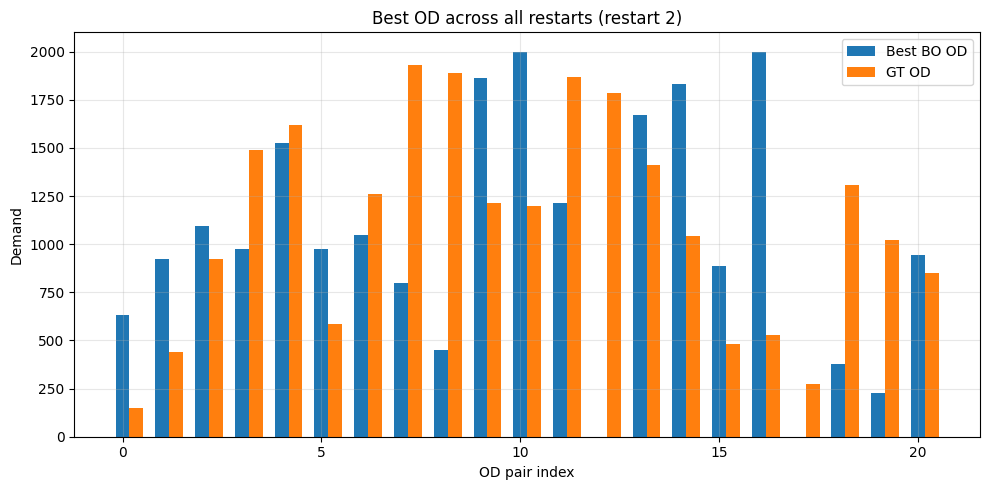

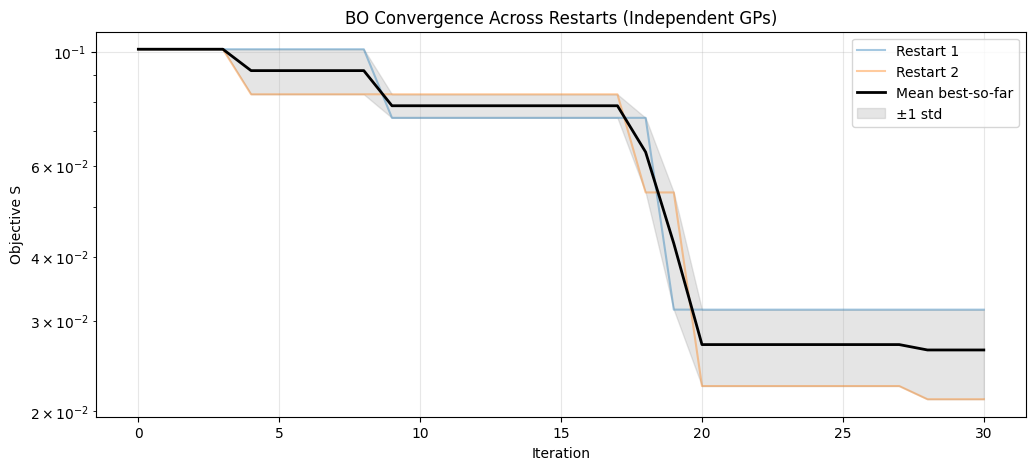

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# 1. ACROSS-RESTART VARIABILITY SUMMARY


all_results = aggregated_results["all_results"]
best_S_all = aggregated_results["best_S_all"]
mean_curve = aggregated_results["mean_curve"]
std_curve = aggregated_results["std_curve"]

print("\n ACROSS-RESTART VARIABILITY \n")
for i, s in enumerate(best_S_all):
    print(f"Restart {i+1}: best S = {s:.6f} (NRMSE = {np.sqrt(s):.4f})")

print("\n--- Summary ---")
print(f"Mean final loss      : {np.mean(best_S_all):.6f}")
print(f"Std dev final loss   : {np.std(best_S_all):.6f}")
print(f"Best final loss       : {np.min(best_S_all):.6f}")
print(f"All final losses      : {best_S_all}")


# 2. PLOT BEST-OF-RUN OD VS GT OD 

overall_best_result = aggregated_results["overall_best_result"]
overall_idx = aggregated_results["overall_best_restart"]

print(f"\n>>> BEST restart index = {overall_idx}")

# Best XS and YS
best_X_norm = overall_best_result.best_X
best_X_real = unnormalize(best_X_norm.unsqueeze(0), bounds).squeeze().cpu().numpy()

print("Best OD vector:", best_X_real)






plt.figure(figsize=(10, 5))
idx = np.arange(len(best_X_real))
width = 0.35

plt.bar(idx, best_X_real, width, label="Best BO OD")
plt.bar(idx + width, gt_od_vals, width, label="GT OD")

plt.xlabel("OD pair index")
plt.ylabel("Demand")
plt.title(f"Best OD across all restarts (restart {overall_idx+1})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

fig_dir = Path(f"{config['simulation_run_path']}/figs_independent_gps")
fig_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_dir / "best_OD_across_restarts_independentGP.png", dpi=300)

plt.show()



#3. PLOT CONVERGENCE CURVES FOR ALL RESTARTS


plt.figure(figsize=(12, 5))

# plot each restart
for i, r in enumerate(all_results):
    plt.plot(r.convergence_curve, alpha=0.4, label=f"Restart {i+1}")

# plot mean and std
plt.plot(mean_curve, color="black", linewidth=2, label="Mean best-so-far")

plt.fill_between(
    np.arange(len(mean_curve)),
    mean_curve - std_curve,
    mean_curve + std_curve,
    color="gray",
    alpha=0.2,
    label="±1 std",
)


plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Objective S")
plt.title("BO Convergence Across Restarts (Independent GPs)")
plt.legend()
plt.grid(alpha=0.3)

plt.savefig(fig_dir / "convergence_curves_independentGP.png", dpi=300)
plt.show()

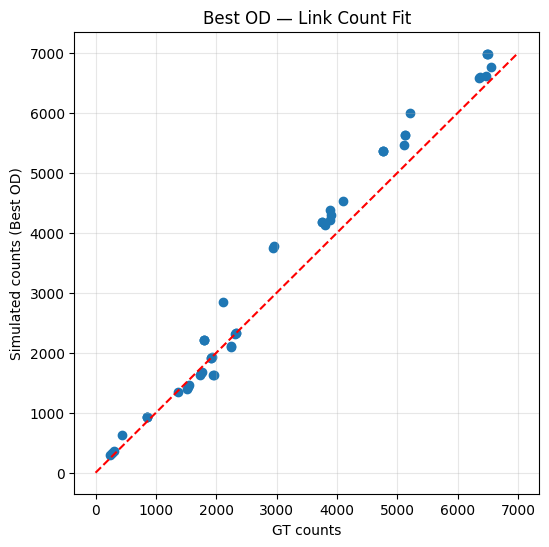

In [36]:
best_idx = overall_best_result.best_idx
df_best = overall_best_result.df_edge_stats[
    overall_best_result.df_edge_stats["bo_iteration"] == best_idx
]

df_plot = df_best.merge(gt_edge_data, on="edge_id", suffixes=("_sim","_gt"))

plt.figure(figsize=(6,6))
plt.scatter(df_plot["interval_nVehContrib_gt"], df_plot["interval_nVehContrib_sim"])
plt.plot([0,7000], [0,7000], 'r--')
plt.xlabel("GT counts")
plt.ylabel("Simulated counts (Best OD)")
plt.title("Best OD — Link Count Fit")
plt.grid(alpha=0.3)
plt.savefig(fig_dir / "best_link_counts_fit_independentGP.png")
plt.show()

In [37]:
best_restart_idx = aggregated_results["overall_best_restart"]
best_result = aggregated_results["overall_best_result"]

print("Best restart =", best_restart_idx + 1)

Best restart = 2


In [38]:
df_stats = best_result.df_edge_stats.copy()
df_stats = df_stats.sort_values(by=["bo_iteration"])

In [39]:
def compute_nrmse_counts_all_edges_Original(df_true, df_simulated):
    df1 = df_true.merge(
        df_simulated,
        on=['edge_id'],
        suffixes=('_GT', '_sim'),
        how='left'
    )
    
    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
    
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
    )**2
    
    n = len(df1)

    # Numerator: RMSE = sqrt( (1/n) * sum(diff^2) )
    rmse = np.sqrt(df1['diff_square'].sum() / n)

    # Denominator: mean(GT) = (1/n) * sum(GT)
    mean_gt = df1['interval_nVehContrib_GT'].sum() / n

    nrmse = rmse / mean_gt
    return nrmse

In [40]:
iterations = sorted(df_stats["bo_iteration"].unique())
nrmse_curve = []

for it in iterations:
    flows_it = df_stats[df_stats["bo_iteration"] == it][["edge_id", "interval_nVehContrib"]]
    nrmse = compute_nrmse_counts_all_edges_Original(gt_edge_data, flows_it)
    nrmse_curve.append(nrmse)

In [41]:
print("min NRMSE curve:", min(nrmse_curve))
print("NRMSE curve:", nrmse_curve)

min NRMSE curve: 0.10222067791768766
NRMSE curve: [np.float64(0.6201612382254084), np.float64(0.39507942845761607), np.float64(0.27271932211873473), np.float64(0.22237887379304908), np.float64(0.15668507276465793), np.float64(0.24673947549817207), np.float64(0.2427545753722753), np.float64(0.3197133434812281), np.float64(0.24099956334434994), np.float64(0.14847260528250028), np.float64(0.27936120571092077), np.float64(0.15688201415864822), np.float64(0.1697129692814262), np.float64(0.1655595225190595), np.float64(0.20264686570687493), np.float64(0.32908328067548875), np.float64(0.13689887075608448), np.float64(0.18330386608133645), np.float64(0.21297651647468022), np.float64(0.10222067791768766), np.float64(0.13151498422931618), np.float64(0.1283595339020806), np.float64(0.11552882146059605), np.float64(0.12757215440939662), np.float64(0.29287263540310726), np.float64(0.19013413184875858), np.float64(0.13696673069047338), np.float64(0.1219575917877873), np.float64(0.2407722834955921), 

In [42]:
print(len(nrmse_curve))

30


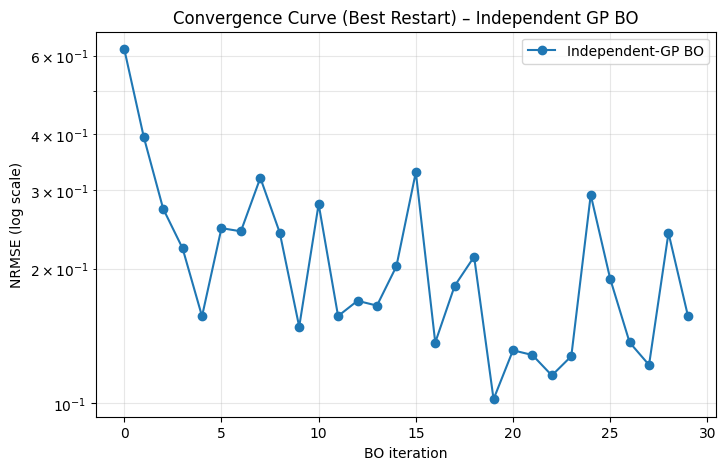

Saved plot to: output/network_2corridor_bo_vanilla/figs/indep_gp_best_convergence_nrmse.png


In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(len(nrmse_curve)), nrmse_curve, marker="o", label="Independent-GP BO")
plt.yscale("log")

plt.xlabel("BO iteration")
plt.ylabel("NRMSE (log scale)")
plt.title("Convergence Curve (Best Restart) – Independent GP BO")
plt.grid(True, which="both", alpha=0.3)
plt.legend()

save_path = Path(f"{config['simulation_run_path']}/figs/indep_gp_best_convergence_nrmse.png")
plt.savefig(save_path, dpi=300)
plt.show()

print("Saved plot to:", save_path)

Best restart = 2
Best initial S: 0.10113846117923728
Best initial NRMSE: 0.31802273689036337


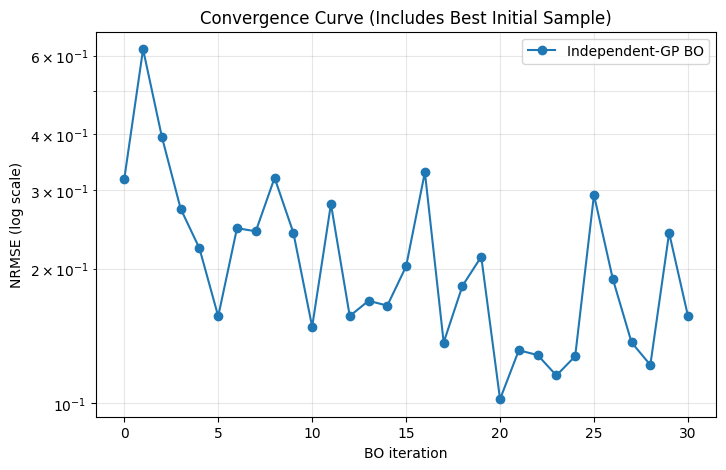

Saved to: output/network_2corridor_bo_vanilla/figs/indep_gp_best_convergence_nrmse.png


In [44]:
best_restart_idx = aggregated_results["overall_best_restart"]
best_result = aggregated_results["overall_best_result"]

print("Best restart =", best_restart_idx + 1)



n_init = best_result.iteration_start        # number of initial points
S_initial = best_result.all_S[:n_init]      # raw S = mean squared relative error
best_initial_rawS = float(torch.min(S_initial))
best_initial_nrmse = np.sqrt(best_initial_rawS)

print("Best initial S:", best_initial_rawS)
print("Best initial NRMSE:", best_initial_nrmse)






#####

df_stats = best_result.df_edge_stats.copy()
df_stats = df_stats.sort_values(by=["bo_iteration"])

def compute_nrmse_counts_all_edges_Original(df_true, df_simulated):
    df1 = df_true.merge(
        df_simulated,
        on=['edge_id'],
        suffixes=('_GT', '_sim'),
        how='left'
    )
    
    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
    df1['diff_square'] = (df1['interval_nVehContrib_GT'] -
                          df1['interval_nVehContrib_sim'])**2
    
    n = len(df1)
    rmse = np.sqrt(df1['diff_square'].sum() / n)
    mean_gt = df1['interval_nVehContrib_GT'].sum() / n
    return rmse / mean_gt


iterations = sorted(df_stats["bo_iteration"].unique())
nrmse_bo = []

for it in iterations:
    flows_it = df_stats[df_stats["bo_iteration"] == it][["edge_id", "interval_nVehContrib"]]
    nrmse = compute_nrmse_counts_all_edges_Original(gt_edge_data, flows_it)
    nrmse_bo.append(nrmse)


#FINAL NRMSE CURVE = [initial-best] + BO curve


nrmse_curve = [best_initial_nrmse] + nrmse_bo




plt.figure(figsize=(8,5))
plt.plot(range(len(nrmse_curve)), nrmse_curve, marker="o", label="Independent-GP BO")
plt.yscale("log")
plt.xlabel("BO iteration")
plt.ylabel("NRMSE (log scale)")
plt.title("Convergence Curve (Includes Best Initial Sample)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()

save_path = Path(f"{config['simulation_run_path']}/figs/indep_gp_best_convergence_nrmse.png")
plt.savefig(save_path, dpi=300)
plt.show()

print("Saved to:", save_path)

In [45]:
print(sorted(df_stats["bo_iteration"].unique()))
print("Number of iterations =", len(df_stats["bo_iteration"].unique()))

[np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49)]
Number of iterations = 30


In [46]:
def compute_best_so_far(values):
    best_vals = []
    current_min = float("inf")
    for v in values:
        current_min = min(current_min, v)
        best_vals.append(current_min)
    return best_vals

In [47]:
best_nrmse_curve = compute_best_so_far(nrmse_curve)

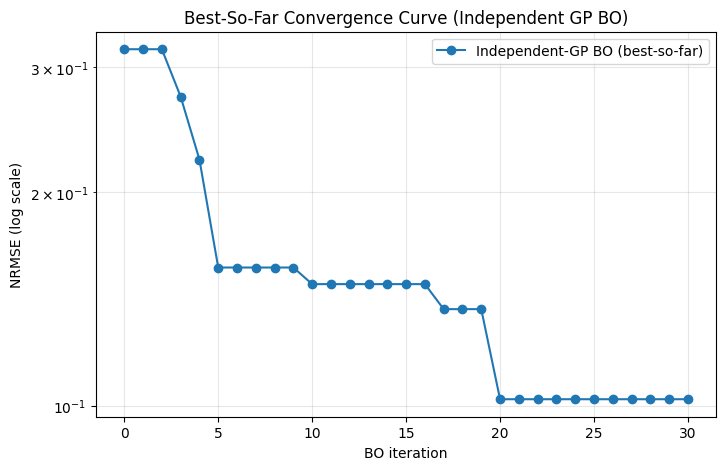

Saved decreasing curve to: output/network_2corridor_bo_vanilla/figs/indep_gp_best_convergence_nrmse_bestsofar.png


In [48]:
plt.figure(figsize=(8,5))
plt.plot(
    range(len(best_nrmse_curve)),
    best_nrmse_curve,
    marker="o",
    label="Independent-GP BO (best-so-far)"
)

plt.yscale("log")
plt.xlabel("BO iteration")
plt.ylabel("NRMSE (log scale)")
plt.title("Best-So-Far Convergence Curve (Independent GP BO)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()

save_path = Path(f"{config['simulation_run_path']}/figs/indep_gp_best_convergence_nrmse_bestsofar.png")
plt.savefig(save_path, dpi=300)
plt.show()

print("Saved decreasing curve to:", save_path)

In [49]:
nrmse_list_independent = []

iterations = sorted(df_stats["bo_iteration"].unique())
for it in iterations:
    flows_it = df_stats[df_stats["bo_iteration"] == it][["edge_id", "interval_nVehContrib"]]
    nrmse_val = compute_nrmse_counts_all_edges_Original(gt_edge_data, flows_it)
    nrmse_list_independent.append(nrmse_val)

best_nrmse_curve = compute_best_so_far(nrmse_list_independent)

In [50]:
print ("Independent GP NRMSE per iteration:", min(best_nrmse_curve))

Independent GP NRMSE per iteration: 0.10222067791768766


In [51]:
print(best_nrmse_curve)

[np.float64(0.6201612382254084), np.float64(0.39507942845761607), np.float64(0.27271932211873473), np.float64(0.22237887379304908), np.float64(0.15668507276465793), np.float64(0.15668507276465793), np.float64(0.15668507276465793), np.float64(0.15668507276465793), np.float64(0.15668507276465793), np.float64(0.14847260528250028), np.float64(0.14847260528250028), np.float64(0.14847260528250028), np.float64(0.14847260528250028), np.float64(0.14847260528250028), np.float64(0.14847260528250028), np.float64(0.14847260528250028), np.float64(0.13689887075608448), np.float64(0.13689887075608448), np.float64(0.13689887075608448), np.float64(0.10222067791768766), np.float64(0.10222067791768766), np.float64(0.10222067791768766), np.float64(0.10222067791768766), np.float64(0.10222067791768766), np.float64(0.10222067791768766), np.float64(0.10222067791768766), np.float64(0.10222067791768766), np.float64(0.10222067791768766), np.float64(0.10222067791768766), np.float64(0.10222067791768766)]


In [ ]:
#INITIAL SEARCH NRMSE


nrmse_curve = []

# initial search samples were in df_0
n_initial = config['n_init_search']

for k in range(n_initial):
    sim_prefix = (
        f"{config['simulation_run_path']}/initial_search/sobol_{k}"
    )
    sim_file = f"{sim_prefix}_{config['EDGE_OUT_STR']}"

    df_sim, _, _ = parse_loop_data_xml_to_pandas(
        base_path,
        sim_file,
        sim_prefix,
        config["SUMO_PATH"]
    )

    nrmse_k = compute_nrmse_counts_all_edges_Original(gt_edge_data, df_sim)
    nrmse_curve.append(nrmse_k)

print("Added initial search NRMSE values:", n_initial)


# BO ITERATIONS NRMSE


# Get best restart index from aggregated_results
if 'aggregated_results' in locals() or 'aggregated_results' in globals():
    best_restart = aggregated_results["overall_best_restart"]
elif 'overall_idx' in locals() or 'overall_idx' in globals():
    best_restart = overall_idx
else:
    # Default to restart 0 if not available
    best_restart = 0
    print("WARNING: Warning: Using restart 0 as default. Define aggregated_results or overall_idx for best restart.")

iterations = sorted(df_stats["bo_iteration"].unique())

# Get iteration_start to map bo_iteration to file iteration numbers
# bo_iteration values start after initial search (e.g., 20, 21, 22...)
# File names use 0-indexed BO iterations (iter0, iter1, iter2...)
if 'overall_best_result' in locals() or 'overall_best_result' in globals():
    iteration_start = overall_best_result.iteration_start
elif 'best_result' in locals() or 'best_result' in globals():
    iteration_start = best_result.iteration_start
else:
    iteration_start = config['n_init_search']  # Fallback to initial search count

for it in iterations:
    # Map bo_iteration to file iteration: file_iter = bo_iteration - iteration_start
    file_iter = it - iteration_start
    sim_prefix = (
        f"{config['simulation_run_path']}/BO/"
        f"restart{best_restart}_iter{file_iter}_batch0"
    )
    sim_file = f"{sim_prefix}_{config['EDGE_OUT_STR']}"

    df_sim, _, _ = parse_loop_data_xml_to_pandas(
        base_path,
        sim_file,
        sim_prefix,
        config["SUMO_PATH"]
    )

    nrmse_it = compute_nrmse_counts_all_edges_Original(gt_edge_data, df_sim)
    nrmse_curve.append(nrmse_it)

# final curve has (initial search) + (BO)
print("Full NRMSE curve length:", len(nrmse_curve))

Added initial search NRMSE values: 20
Full NRMSE curve length: 50


Best initial search point NRMSE: 0.318023 (from index 47)
Computed NRMSE for 30 BO iterations
Full NRMSE curve length: 31 (best initial + 30 BO iterations)


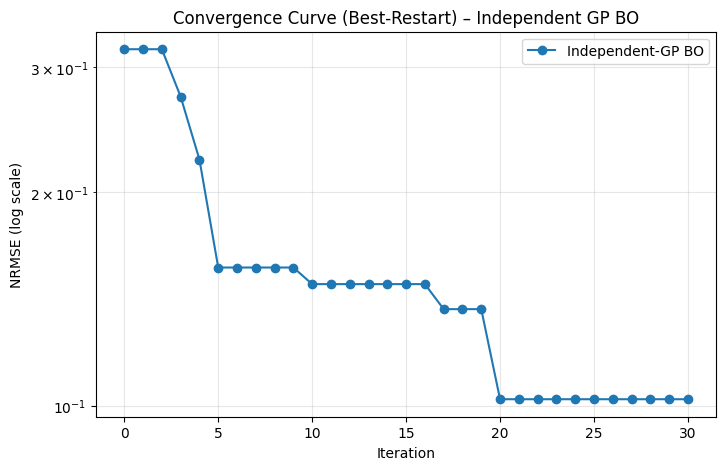

Saved to: output/network_2corridor_bo_vanilla/figs/indep_gp_best_convergence_nrmse.png


In [ ]:
def compute_best_so_far(values):
    """
    Takes a list of values and returns a monotonically non-increasing curve.
    """
    best_curve = []
    current_best = float("inf")
    for v in values:
        current_best = min(current_best, v)
        best_curve.append(current_best)
    return best_curve


# Get the best initial search point NRMSE (from Cell 50)
# best_S is the raw objective (mean squared relative error) for the best initial point
# NRMSE = sqrt(S)
best_initial_nrmse = np.sqrt(best_S)
print(f"Best initial search point: sobol_{best_idx} (index {best_idx} out of {len(train_X)} initial points)")
print(f"Best initial search point NRMSE: {best_initial_nrmse:.6f}")

# Extract NRMSE for BO iterations (limit to first 30 iterations)
iterations = sorted(df_stats["bo_iteration"].unique())   # e.g., [20, 21, ..., 49]
iterations = iterations[:30]  # Take only first 30 BO iterations

nrmse_list_independent = []

for it in iterations:
    flows_it = df_stats[df_stats["bo_iteration"] == it][["edge_id", "interval_nVehContrib"]]
    nrmse_val = compute_nrmse_counts_all_edges_Original(gt_edge_data, flows_it)
    nrmse_list_independent.append(nrmse_val)

print(f"Computed NRMSE for {len(nrmse_list_independent)} BO iterations")

# Combine: [best_initial] + BO iterations (total: 31 points from 0 to 30)
nrmse_curve_full = [best_initial_nrmse] + nrmse_list_independent
print(f"Full NRMSE curve length: {len(nrmse_curve_full)} (best initial + {len(nrmse_list_independent)} BO iterations)")

# Compute best-so-far curve from the full data
best_nrmse_curve = compute_best_so_far(nrmse_curve_full)

###


plt.figure(figsize=(8,5))
plt.plot(range(len(best_nrmse_curve)), best_nrmse_curve,
         marker="o", label="Independent-GP BO")

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("NRMSE (log scale)")
plt.title("Convergence Curve (Best-Restart) – Independent GP BO")
plt.grid(True, which="both", alpha=0.3)
plt.legend()

save_path = Path(f"{config['simulation_run_path']}/figs/indep_gp_best_convergence_nrmse.png")
plt.savefig(save_path, dpi=300)
plt.show()

print("Saved to:", save_path)

In [ ]:
# ============================================================
# COMPARISON PLOT: Independent GP vs Vanilla BO
# ============================================================

# Load Vanilla BO convergence data
# First, try to get it from the VanillaBO notebook's output directory
vanilla_config_path = config['simulation_run_path'].replace('indep_gp', 'bo_vanilla')
if 'network_2corridor' in vanilla_config_path:
    vanilla_config_path = vanilla_config_path.replace('network_2corridor_indep_gp', 'network_2corridor_bo_vanilla')

vanilla_initial_csv = f"{vanilla_config_path}/initial_search/data_set_ods_0_2000.csv"
vanilla_bo_csv = None

# Find the best restart for Vanilla BO
if Path(vanilla_initial_csv).exists():
    # Load initial search data
    df_0_vanilla = pd.read_csv(vanilla_initial_csv)
    best_initial_idx_vanilla = df_0_vanilla['loss'].idxmin()
    best_initial_nrmse_vanilla = df_0_vanilla.loc[best_initial_idx_vanilla, 'loss']
    
    # Find best restart by checking all restart files
    best_restart_vanilla = 0
    best_final_loss_vanilla = float('inf')
    
    for r in range(5):  # Check up to 5 restarts
        restart_file = f"{vanilla_config_path}/BO/restart{r}_full_training.csv"
        if Path(restart_file).exists():
            df_restart = pd.read_csv(restart_file)
            final_loss = df_restart['loss'].min()
            if final_loss < best_final_loss_vanilla:
                best_final_loss_vanilla = final_loss
                best_restart_vanilla = r
                vanilla_bo_csv = restart_file
    
    if vanilla_bo_csv and Path(vanilla_bo_csv).exists():
        # Load best restart data
        df_best_vanilla = pd.read_csv(vanilla_bo_csv)
        
        # Extract NRMSE for each BO iteration (limit to 30)
        n_iters_vanilla = min(df_best_vanilla['bo_iteration'].max(), 30)
        nrmse_curve_bo_vanilla = []
        
        for it in range(1, n_iters_vanilla + 1):
            df_it = df_best_vanilla[df_best_vanilla['bo_iteration'] == it]
            if not df_it.empty:
                best_loss_it = df_it['loss'].min()
                nrmse_curve_bo_vanilla.append(best_loss_it)
        
        # Combine initial + BO iterations
        nrmse_curve_vanilla = [best_initial_nrmse_vanilla] + nrmse_curve_bo_vanilla
        best_so_far_vanilla = np.minimum.accumulate(nrmse_curve_vanilla)
        
        print(f"Loaded Vanilla BO data: {len(best_so_far_vanilla)} points (best restart: {best_restart_vanilla})")
        
        # Plot comparison
        plt.figure(figsize=(10, 6))
        
        # Independent GP curve
        iters_indep = np.arange(0, len(best_nrmse_curve))
        plt.plot(iters_indep, best_nrmse_curve, 
                marker="o", label="Independent-GP BO", linewidth=2, markersize=6)
        
        # Vanilla BO curve
        iters_vanilla = np.arange(0, len(best_so_far_vanilla))
        plt.plot(iters_vanilla, best_so_far_vanilla, 
                marker="s", label="Vanilla BO", linewidth=2, markersize=6)
        
        plt.yscale("log")
        plt.xlabel("Iteration", fontsize=12)
        plt.ylabel("Best-so-far NRMSE (log scale)", fontsize=12)
        plt.title("Convergence Comparison: Independent GP vs Vanilla BO", fontsize=14)
        plt.grid(True, which="both", alpha=0.3)
        plt.legend(fontsize=11)
        plt.tight_layout()
        
        save_path = Path(f"{config['simulation_run_path']}/figs/convergence_comparison_indep_vs_vanilla.png")
        plt.savefig(save_path, dpi=300)
        plt.show()
        
        print("Saved comparison plot to:", save_path)
    else:
        print(f"Could not find Vanilla BO data file. Expected: {vanilla_bo_csv}")
        print("Please run the Vanilla BO notebook first, or check the path.")
else:
    print(f"Could not find Vanilla BO initial search data. Expected: {vanilla_initial_csv}")
    print("Please run the Vanilla BO notebook first, or check the path.")


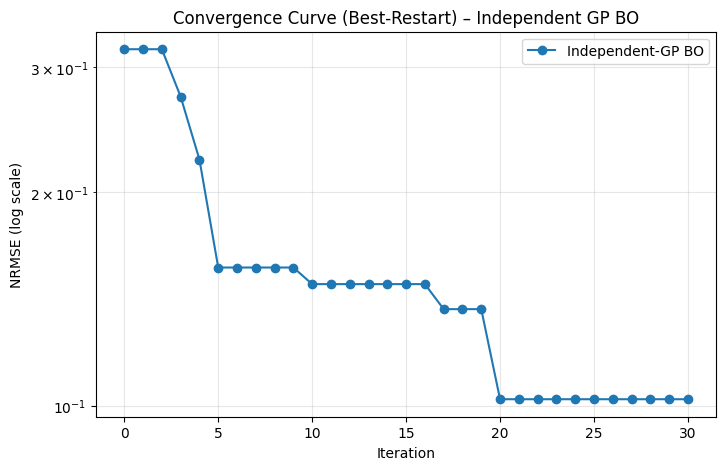

Saved to: output/network_2corridor_bo_vanilla/figs/indep_gp_best_convergence_nrmse.png


In [54]:
plt.figure(figsize=(8,5))
plt.plot(range(len(best_nrmse_curve)), best_nrmse_curve,
         marker="o", label="Independent-GP BO")

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("NRMSE (log scale)")
plt.title("Convergence Curve (Best-Restart) – Independent GP BO")
plt.grid(True, which="both", alpha=0.3)
plt.legend()

save_path = Path(f"{config['simulation_run_path']}/figs/indep_gp_best_convergence_nrmse.png")
plt.savefig(save_path, dpi=300)
plt.show()

print("Saved to:", save_path)

In [55]:
# Save all_results to pickle file for use in superposed plots
import pickle
results_save_path = Path(f"{config['simulation_run_path']}/all_results_indep_uniweight.pkl")
results_save_path.parent.mkdir(parents=True, exist_ok=True)
with open(results_save_path, 'wb') as f:
    pickle.dump(all_results, f)
print(f"Saved all_results to: {results_save_path}")
print(f"  This file can be used by the superposed plot in VanillaBOtoy_weightedsum.ipynb")

Saved all_results to: output/network_2corridor_bo_vanilla/all_results_indep_uniweight.pkl
  This file can be used by the superposed plot in VanillaBOtoy_weightedsum.ipynb


In [56]:

print("Minimum NRMSE achieved:", min(best_nrmse_curve))

Minimum NRMSE achieved: 0.10222067791768766


Processing restart 0...


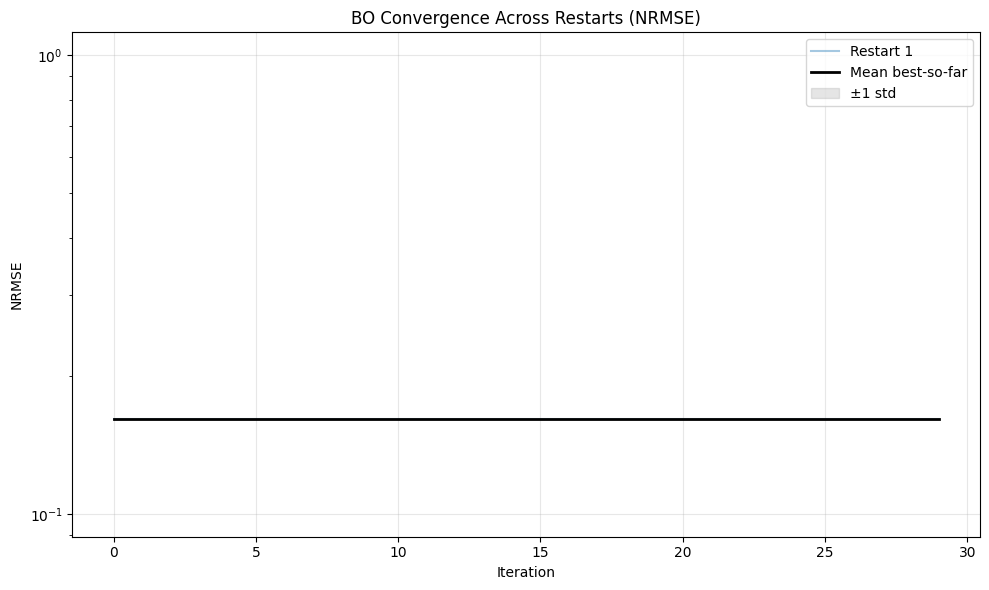

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

all_nrmse_traj = []   # list : for each restart → list of NRMSE per iteration

# LOOP OVER RESTARTS 
for r in range(1):

    print(f"Processing restart {r}...")

    # load training file
    df_r = pd.read_csv(
        f"{config['simulation_run_path']}/BO/restart{r}_full_training.csv"
    )
    n_iters = df_r["bo_iteration"].max()

    restart_curve = []

    # LOOP OVER ITERATIONS FOR THIS RESTART 
    for it in range(1, n_iters + 1):

        sim_prefix = (
            f"{config['simulation_run_path']}/BO/"
            f"restart{r}_iter{it-1}_batch0"
        )
        sim_file = f"{sim_prefix}_{config['EDGE_OUT_STR']}"

        df_sim, _, _ = parse_loop_data_xml_to_pandas(
            base_path,
            sim_file,
            sim_prefix,
            config["SUMO_PATH"]
        )

        nrmse_it = compute_nrmse_counts_all_edges_Original(
            gt_edge_data,
            df_sim
        )
        restart_curve.append(nrmse_it)

    # convert to BEST-SO-FAR decreasing curve
    restart_curve = np.minimum.accumulate(restart_curve)
    all_nrmse_traj.append(restart_curve)





plt.figure(figsize=(10,6))

max_len = max(len(c) for c in all_nrmse_traj)

# pad trajectories for mean/std
padded = np.full((len(all_nrmse_traj), max_len), np.nan)
for i, traj in enumerate(all_nrmse_traj):
    padded[i, :len(traj)] = traj

mean_curve = np.nanmean(padded, axis=0)
std_curve  = np.nanstd(padded, axis=0)

# ---- plot each restart ----
for r, curve in enumerate(all_nrmse_traj):
    plt.plot(curve, alpha=0.4, label=f"Restart {r+1}")

# ---- mean curve ----
plt.plot(mean_curve, color="black", linewidth=2, label="Mean best-so-far")

# ---- uncertainty band ----
plt.fill_between(
    np.arange(max_len),
    mean_curve - std_curve,
    mean_curve + std_curve,
    color="gray",
    alpha=0.2,
    label="±1 std"
)

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("NRMSE")
plt.title("BO Convergence Across Restarts (NRMSE)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [58]:
import importlib
import helpers_od_calibration_BN

importlib.reload(helpers_od_calibration_BN)

from helpers_od_calibration_BN import (
    plot_flow_coverage_per_edge,
    create_od_xml
)

results = bo_loop.run_bo_loop(
    train_X_init=train_X,
    train_Y_errors_init=train_Y_errors,
    n_iterations=10,
)



STARTING BAYESIAN OPTIMIZATION LOOP

Initial training data: 20 samples
Initial best S (raw): 0.101138 (NRMSE: 0.318023)

BO ITERATION 1/10

Step 1: Update GP models
  Refitting GPs with 20 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.212999
  GP predicts S_std: -0.105748 ± 0.152280

Step 3: Run SUMO simulation
  OD (real): [1303.58919957  377.88202685 1339.56037643 1705.42096035 1249.83175561
  868.17441752  220.79697655    0.         1297.39656234 1033.21471297
  452.13971077  166.18960384  995.98065725 1662.19628306    0.
 1447.67839995 1138.27137562  684.22358671 1861.47311638 2000.
  881.98877848]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 20686.00850025217
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/networ

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1383500.00UPS, vehicles TOT 9714 ACT 2767 BUF 10973)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.57s
 Real time factor: 700.18
 UPS: 1638225.134650
Vehicles:
 Inserted: 9714 (Loaded: 20687)
 Running: 2767
 Waiting: 10973
Statistics (avg of 6947):
 RouteLength: 3314.33
 Speed: 10.97
 Duration: 717.69
 WaitingTime: 2.73
 TimeLoss: 577.34
 DepartDelay: 212.82
DijkstraRouter answered 24561 queries and explored 24.11 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.252965 (NRMSE: 0.502956)
  Current best remains: 0.101138

Iteration time: 11.8s
Total elapsed: 0.2 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 2/10

Step 1: Update GP models
  Refitting GPs with 21 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.180442
  GP predicts S_std: -0.063079 ± 0.174421

Step 3: Run SUMO simulation
  OD (real): [ 788.77213319  468.67103534 1102.44218511 1629.2305042  2000.
 1146.79265799 1797.01264721 1240.53052764    0.         1865.38936252
 1654.38023831  598.62631586 2000.          479.30743043  923.17851223
  475.20999052  268.47110283    0.            4.28886841  540.58254211
 1026.00299029]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 20008.88904418431
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outpu

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~130000.00UPS, vehicles TOT 13392 ACT 390 BUF 6617)      
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.83s
 Real time factor: 668.724
 UPS: 381153.978052
Vehicles:
 Inserted: 13392 (Loaded: 20009)
 Running: 390
 Waiting: 6617
Statistics (avg of 13002):
 RouteLength: 3382.86
 Speed: 19.85
 Duration: 167.80
 WaitingTime: 0.52
 TimeLoss: 24.30
 DepartDelay: 513.15
DijkstraRouter answered 28058 queries and explored 18.79 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
  Observed S (raw): 2.558537 (NRMSE: 1.599543)
  Current best remains: 0.101138

Iteration time: 11.3s
Total elapsed: 0.4 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 3/10

Step 1: Update GP models
  Refitting GPs with 22 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.242247
  GP predicts S_std: -0.113584 ± 0.251692

Step 3: Run SUMO simulation
  OD (real): [1286.63916035 2000.         1403.3775038  1107.31807942 2000.
 1535.03840917 1786.90291074    0.          737.15998246 2000.
  707.60759795  490.458328   1775.54409096 1448.89203891 2000.
  907.26535718 1422.63412257 1436.9399959  1417.6722764     0.
 1053.11107653]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 26516.560930352036
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (6ms ~= 166.67*RT, ~171000.00UPS, vehicles TOT 14261 ACT 1026 BUF 12255)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.22s
 Real time factor: 422.948
 UPS: 447970.827459
Vehicles:
 Inserted: 14261 (Loaded: 26516)
 Running: 1026
 Waiting: 12255
Statistics (avg of 13235):
 RouteLength: 3379.33
 Speed: 15.96
 Duration: 257.88
 WaitingTime: 0.88
 TimeLoss: 116.32
 DepartDelay: 394.10
DijkstraRouter answered 32453 queries and explored 21.94 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.373489 (NRMSE: 0.611137)
  Current best remains: 0.101138

Iteration time: 14.7s
Total elapsed: 0.6 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 4/10

Step 1: Update GP models
  Refitting GPs with 23 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.167146
  GP predicts S_std: -0.048237 ± 0.170071

Step 3: Run SUMO simulation
  OD (real): [ 854.23351824   70.91967726 1496.70512982 2000.          925.61366994
 1338.40512081  530.89195842 1325.72788555    0.         1479.98801644
 1435.99209289 1047.65215344    0.         1614.4931263   688.46884427
  971.98230353 2000.            0.          468.98218187 2000.
 1080.08717567]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 21330.14285447059
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outpu

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1117500.00UPS, vehicles TOT 10879 ACT 2235 BUF 10451)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.53s
 Real time factor: 596.969
 UPS: 1192429.052503
Vehicles:
 Inserted: 10879 (Loaded: 21330)
 Running: 2235
 Waiting: 10451
Statistics (avg of 8644):
 RouteLength: 3790.77
 Speed: 8.90
 Duration: 680.80
 WaitingTime: 2.50
 TimeLoss: 524.69
 DepartDelay: 339.91
DijkstraRouter answered 29672 queries and explored 23.34 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
  Observed S (raw): 0.287874 (NRMSE: 0.536539)
  Current best remains: 0.101138

Iteration time: 12.4s
Total elapsed: 0.8 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 5/10

Step 1: Update GP models
  Refitting GPs with 24 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.138036
  GP predicts S_std: -0.003501 ± 0.186209

Step 3: Run SUMO simulation
  OD (real): [ 282.42241591  889.62929755 1145.72272239 2000.         1905.96470179
 1703.30972302   48.52524556  629.13399336 1494.97069348   94.16964551
  530.72484078 1815.94485504    0.         2000.         1542.07902822
  851.79673676 2000.          495.31028377 1623.1139487  2000.
 1499.72643482]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 24552.54456667233
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outpu

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~627000.00UPS, vehicles TOT 11078 ACT 2508 BUF 13473)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 11.36s
 Real time factor: 343.37
 UPS: 720948.670541
Vehicles:
 Inserted: 11078 (Loaded: 24551)
 Running: 2508
 Waiting: 13473
Statistics (avg of 8570):
 RouteLength: 3899.49
 Speed: 9.01
 Duration: 729.02
 WaitingTime: 2.95
 TimeLoss: 569.20
 DepartDelay: 430.11
DijkstraRouter answered 33003 queries and explored 25.22 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
  Observed S (raw): 0.329863 (NRMSE: 0.574337)
  Current best remains: 0.101138

Iteration time: 18.0s
Total elapsed: 1.1 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 6/10

Step 1: Update GP models
  Refitting GPs with 25 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.126576
  GP predicts S_std: -0.005854 ± 0.145535

Step 3: Run SUMO simulation
  OD (real): [1241.36285769  991.00720889 1280.48841485 1534.28976336 1408.1836075
 1639.6971782  1140.39423718  604.52628395  528.34109963 2000.
  884.3727185  1161.59962328    0.         1645.18561419 1352.65543299
 1082.23976814 1093.75741507 1061.92869331 1651.36058079 1080.99291512
 1710.66977386]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 25093.05318651878
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~649333.33UPS, vehicles TOT 13554 ACT 1948 BUF 11540)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 12.76s
 Real time factor: 305.762
 UPS: 502861.074089
Vehicles:
 Inserted: 13554 (Loaded: 25094)
 Running: 1948
 Waiting: 11540
Statistics (avg of 11606):
 RouteLength: 3874.82
 Speed: 11.26
 Duration: 475.25
 WaitingTime: 1.86
 TimeLoss: 318.88
 DepartDelay: 330.82
DijkstraRouter answered 33598 queries and explored 23.87 edges on average.
DijkstraRouter spent 0.08s answering queries (0.00ms on average).
  Observed S (raw): 0.832671 (NRMSE: 0.912508)
  Current best remains: 0.101138

Iteration time: 25.5s
Total elapsed: 1.6 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 7/10

Step 1: Update GP models
  Refitting GPs with 26 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.181990
  GP predicts S_std: -0.060513 ± 0.188098

Step 3: Run SUMO simulation
  OD (real): [1490.22549023  783.7370197   976.52531614  183.49736629 2000.
 1335.57345494 1113.15198329  571.32043841 1733.36783015  883.24680859
 1052.61076946 1241.04967109  593.58236304  483.94791578 2000.
  717.88698213 2000.            0.          853.5601603   442.79564268
 1312.86631681]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 21768.945529018703
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/netwo

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~473500.00UPS, vehicles TOT 13798 ACT 1894 BUF 7970)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.83s
 Real time factor: 396.704
 UPS: 608256.738887
Vehicles:
 Inserted: 13798 (Loaded: 21768)
 Running: 1894
 Waiting: 7970
Statistics (avg of 11904):
 RouteLength: 3547.31
 Speed: 13.47
 Duration: 408.21
 WaitingTime: 2.22
 TimeLoss: 262.81
 DepartDelay: 245.09
DijkstraRouter answered 29558 queries and explored 22.40 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
  Observed S (raw): 0.145895 (NRMSE: 0.381962)
  Current best remains: 0.101138

Iteration time: 18.8s
Total elapsed: 1.9 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 8/10

Step 1: Update GP models
  Refitting GPs with 27 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.171771
  GP predicts S_std: -0.053960 ± 0.169931

Step 3: Run SUMO simulation
  OD (real): [2000.          825.92983782 1111.27177749  377.06229833 2000.
 1458.36006382 1376.27470427  648.28284363 1521.4202648   999.84401349
 1680.16787313  863.99420388 1480.02575548  508.43892096 2000.
 1359.3414325  1665.48285888    0.         1541.88441161 1834.75623441
  982.96924204]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 26235.506736541625
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/netwo

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (7ms ~= 142.86*RT, ~228000.00UPS, vehicles TOT 13369 ACT 1596 BUF 12867)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 12.45s
 Real time factor: 313.203
 UPS: 487876.646322
Vehicles:
 Inserted: 13369 (Loaded: 26236)
 Running: 1596
 Waiting: 12867
Statistics (avg of 11773):
 RouteLength: 3663.87
 Speed: 11.70
 Duration: 436.16
 WaitingTime: 2.36
 TimeLoss: 286.83
 DepartDelay: 352.02
DijkstraRouter answered 34096 queries and explored 23.11 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
  Observed S (raw): 0.288570 (NRMSE: 0.537187)
  Current best remains: 0.101138

Iteration time: 21.3s
Total elapsed: 2.2 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 9/10

Step 1: Update GP models
  Refitting GPs with 28 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.103185
  GP predicts S_std: 0.039126 ± 0.169720

Step 3: Run SUMO simulation
  OD (real): [1034.8135118   750.11286268 1028.88504432 2000.         2000.
 1725.94545737  114.30631203  762.90985399 1546.63944783 1320.64524006
  157.29459163  651.43388315 1907.73035301 2000.         1647.80565582
 2000.         1845.69794542 2000.         1953.30053221 2000.
   76.93929946]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 28524.459990752825
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/networ

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~641250.00UPS, vehicles TOT 11468 ACT 2565 BUF 17056)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 14.40s
 Real time factor: 270.833
 UPS: 545462.083333
Vehicles:
 Inserted: 11468 (Loaded: 28524)
 Running: 2565
 Waiting: 17056
Statistics (avg of 8903):
 RouteLength: 3504.59
 Speed: 10.44
 Duration: 610.46
 WaitingTime: 2.52
 TimeLoss: 464.16
 DepartDelay: 257.08
DijkstraRouter answered 34775 queries and explored 24.14 edges on average.
DijkstraRouter spent 0.09s answering queries (0.00ms on average).
  Observed S (raw): 0.149869 (NRMSE: 0.387129)
  Current best remains: 0.101138

Iteration time: 22.1s
Total elapsed: 2.6 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BO ITERATION 10/10

Step 1: Update GP models
  Refitting GPs with 29 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.101138


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.099619
  GP predicts S_std: 0.026739 ± 0.136702

Step 3: Run SUMO simulation
  OD (real): [2000.          963.27112483 1433.32605462  292.13537352 2000.
 1339.05716303 1317.71599068  510.32394054 1925.18791875  867.44049118
 1449.65246046  708.59567394 1512.94664801 1161.528513   1671.43801859
 1453.93622779  139.75078352    0.         1410.3733176    82.91594149
 1071.61555288]
  Creating OD with TAZ pairs: [['taz_0', 'taz_60'], ['taz_64', 'taz_1'], ['taz_63', 'taz_64'], ['taz_60', 'taz_61'], ['taz_63', 'taz_1'], ['taz_0', 'taz_61'], ['taz_61', 'taz_62'], ['taz_62', 'taz_63'], ['taz_62', 'taz_64'], ['taz_62', 'taz_1'], ['taz_60', 'taz_62'], ['taz_0', 'taz_62'], ['taz_61', 'taz_63'], ['taz_61', 'taz_64'], ['taz_61', 'taz_1'], ['taz_60', 'taz_63'], ['taz_0', 'taz_63'], ['taz_60', 'taz_64'], ['taz_60', 'taz_1'], ['taz_0', 'taz_64'], ['taz_0', 'taz_1']]
total expected GT demand: 23311.211194422292
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outpu

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~350000.00UPS, vehicles TOT 13538 ACT 700 BUF 9775)      
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 11.12s
 Real time factor: 350.656
 UPS: 264556.734400
Vehicles:
 Inserted: 13538 (Loaded: 23313)
 Running: 700
 Waiting: 9775
Statistics (avg of 12838):
 RouteLength: 3352.10
 Speed: 17.59
 Duration: 215.28
 WaitingTime: 0.67
 TimeLoss: 74.33
 DepartDelay: 499.37
DijkstraRouter answered 30106 queries and explored 21.27 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
  Observed S (raw): 2.856455 (NRMSE: 1.690105)
  Current best remains: 0.101138

Iteration time: 19.7s
Total elapsed: 2.9 min
Best S so far (raw): 0.101138 (NRMSE: 0.3180)

BAYESIAN OPTIMIZATION COMPLETE
Total evaluations: 30
Initial best S: 0.101138
Final best S: 0.101138
Total improvement: 0.000000
Total time: 2.9 min


# result analysis 

Best BO iteration index: 14


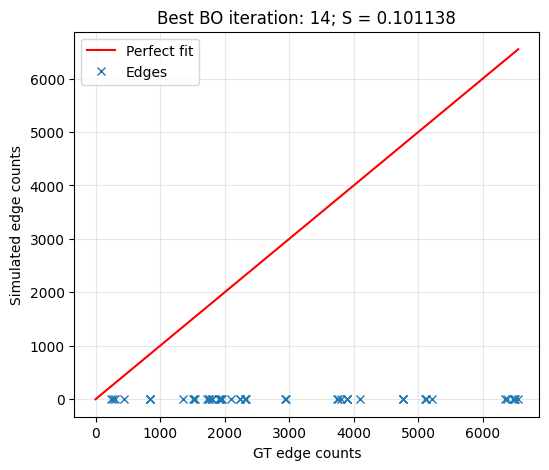

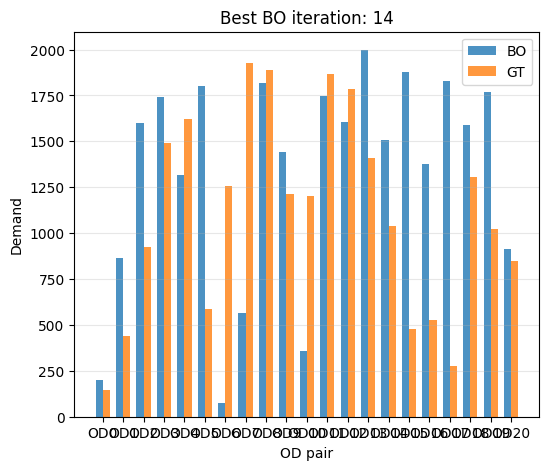

In [59]:
plot_best_iteration_like_prof(
    results=results,
    gt_edge_data=gt_edge_data,
    edge_ids=edge_ids,
    gt_od_vals=gt_od_vals,
    bounds=bounds,
    save_dir=f"{config['simulation_run_path']}/figs",
)

In [60]:
gt_edge_data["edge_id"].unique()

array(['479773097-AddedOnRampEdge', '867204830-AddedOnRampEdge',
       '867204830', '867204830-AddedOffRampEdge', '479773097',
       '479773096', '479773096-AddedOffRampEdge', '509747331',
       '867204829', '509747295', '509747288', '509747324', '687721986',
       '509747324-AddedOnRampEdge', '395318356', '8954447',
       '617259144-AddedOnRampEdge', '479773094', '617259144', '479773095',
       '479773095-AddedOffRampEdge', '509747233-AddedOnRampEdge',
       '509747233', '8925009', '456092817#0', '456092814', '11531386',
       '416220210#0', '861059531', '394165856', '8927801#0', '417524818',
       '394170678', '394170681#0', '708314651',
       '617259148-AddedOnRampEdge', '617259148', '517256137', '8927265',
       '509747343', '517294012', '8925983', '509747283', '8927783',
       '394165857', '509747213', '8927009#0', '8923686', '8925900#0',
       '395358019', '509747272'], dtype=object)

In [61]:
#plot_all_iterations_like_prof(
    #results=results,
    #gt_edge_data=gt_edge_data,
    #edge_ids=edge_ids,
    ##gt_od_vals=gt_od_vals,
    #bounds=bounds,
    #save_dir=f"{config['simulation_run_path']}/figs",)



Plotting BO iterations 20..29


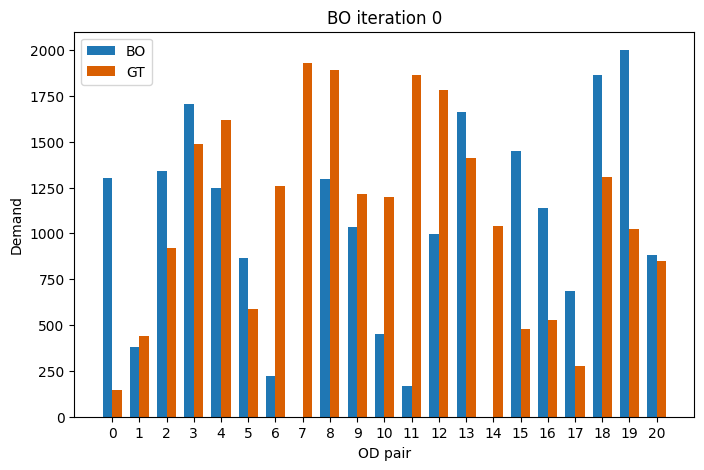

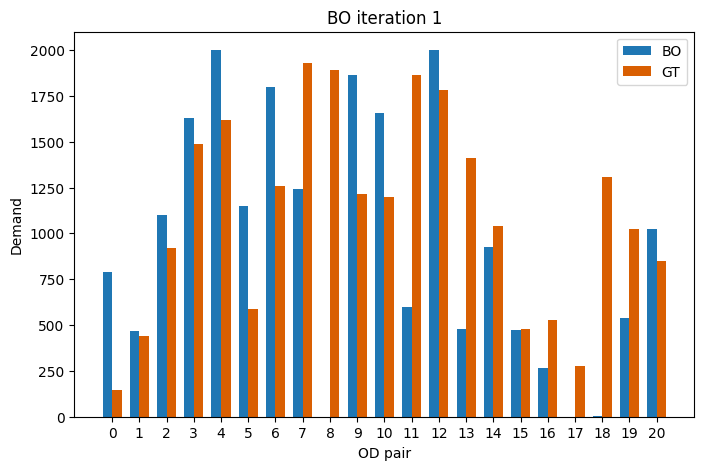

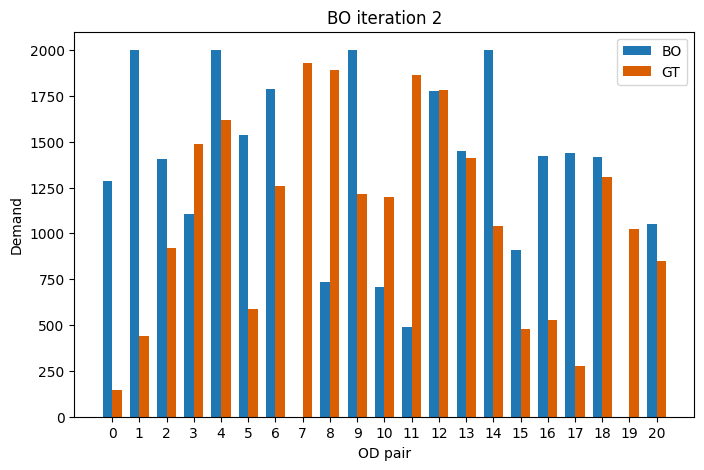

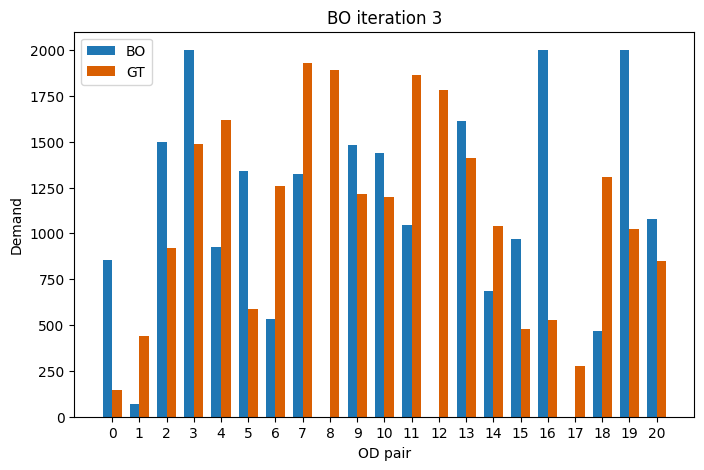

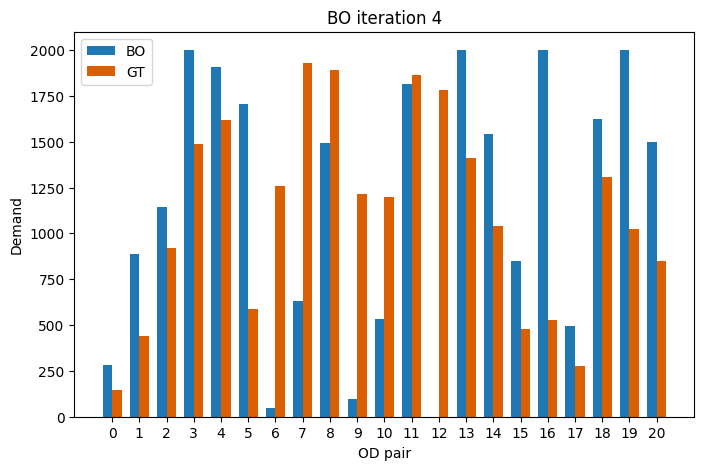

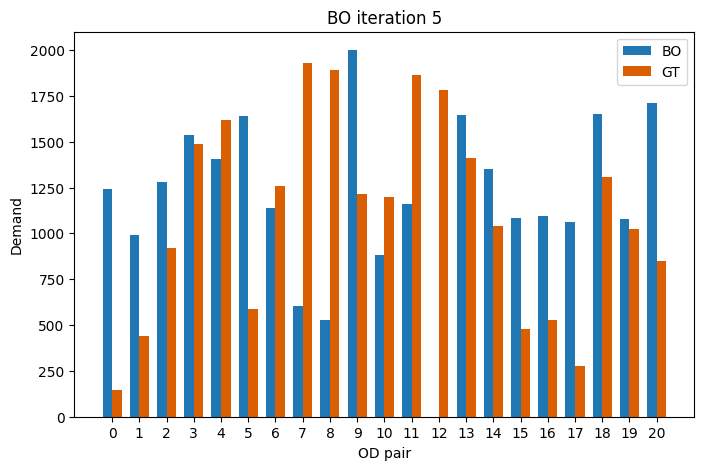

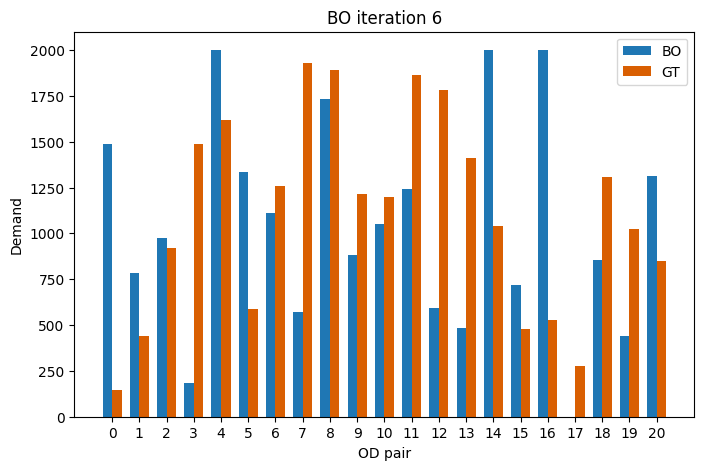

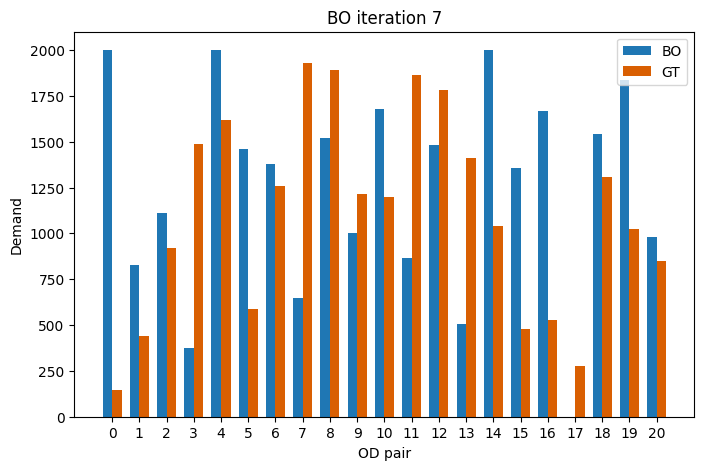

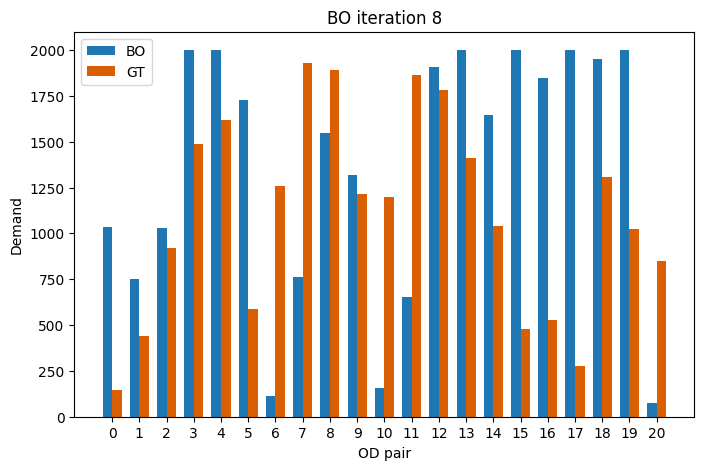

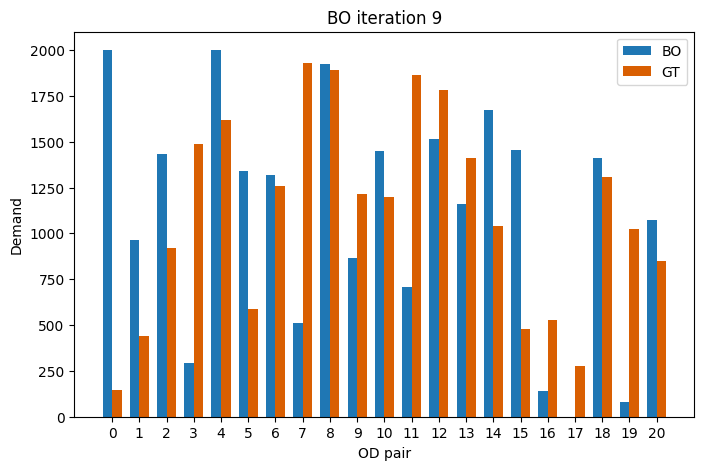

In [62]:
plot_od_comparison_per_iteration(
    results=results,
    gt_od_vals=gt_od_vals,
    bounds=bounds,
    save_dir=f"{config['simulation_run_path']}/figs"
)

Saved plot to output/network_2corridor_bo_vanilla/figs/convergence_bo_only.png


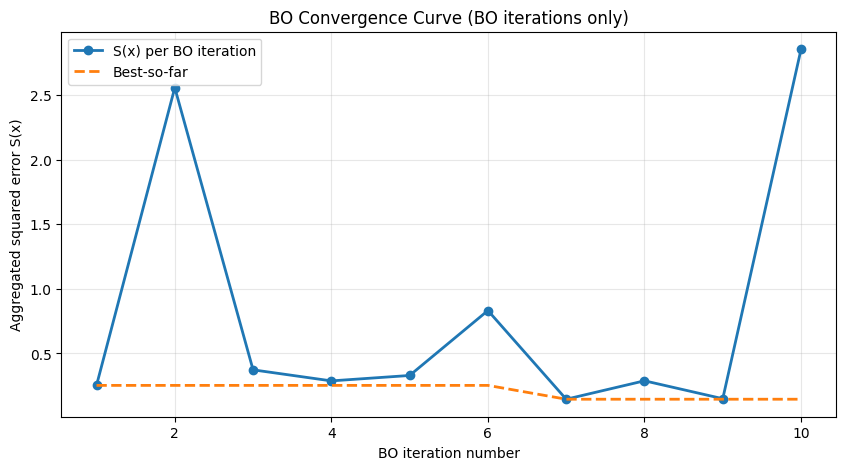

In [63]:
def plot_convergence_bo_only(results, save_path=None):
    """
    Plot convergence curve showing ONLY the BO iterations.
    Initial samples are removed.
    """

    S_all = results.all_S.cpu().numpy()
    start = results.iteration_start        # number of initial samples

    # Extract only BO iterations
    S_bo = S_all[start:]                   # shape (n_bo_iterations,)
    iters_bo = np.arange(1, len(S_bo) + 1)

    # Best-so-far only within BO phase
    best_so_far = np.minimum.accumulate(S_bo)

    plt.figure(figsize=(10, 5))
    plt.plot(iters_bo, S_bo, marker="o", linewidth=2,
             label="S(x) per BO iteration")
    plt.plot(iters_bo, best_so_far, "--", linewidth=2,
             label="Best-so-far")

    plt.xlabel("BO iteration number")
    plt.ylabel("Aggregated squared error S(x)")
    plt.title("BO Convergence Curve (BO iterations only)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved plot to {save_path}")

    plt.show()



plot_convergence_bo_only(
    results,
    save_path=f"{config['simulation_run_path']}/figs/convergence_bo_only.png"
)

In [64]:
print("per_edge_errors:", per_edge_errors)
print("curr_loss S(x):", curr_loss)

per_edge_errors: [7.78546713e-01 2.82609841e-04 1.79452942e-02 3.44870280e-02
 3.44011404e-02 1.92506321e-02 1.98646555e+00 7.79752073e-01
 3.54371325e-02 3.16163001e-01 3.12751286e-01 6.18268417e-02
 5.66168612e-02 5.65743877e-02 5.23495550e-02 5.23910850e-02
 4.53422389e-02 4.07978323e-02 1.79452942e-02 4.71882058e-02
 4.77914344e-02 2.96362762e+00 9.61163595e-02 3.25424376e-02
 2.46877359e-02 2.58989795e-02 2.20677695e-02 5.07854718e-03
 9.28262315e-02 7.91015625e-02 7.68020251e-02 1.87356213e-02
 1.32043140e-02 1.94246950e-01 2.08776354e-01 1.69775542e-02
 2.25625000e-01 6.34541847e-02 2.37149166e-02 5.28666873e-02
 5.33968294e-02 4.24621265e-02 3.21550103e+00 2.98031645e-01
 1.61677119e+00 8.87113736e-02 1.79452942e-02 8.48336318e-02
 3.74055278e-01 2.69572930e-04 1.50450966e-02]
curr_loss S(x): 0.29093490449708204


In [65]:
# ===== 2) Extract edge stats =====
df_edge_stats = results.df_edge_stats

if df_edge_stats is None:
    raise ValueError("df_edge_stats is empty — did you run BO with logging enabled?")

print(df_edge_stats.head())

       edge_id  interval_nVehContrib  bo_iteration  batch
0     11531386                   232            20      0
1    394165856                  1953            20      0
2    394165857                   378            20      0
3    394170678                  1001            20      0
4  394170681#0                   998            20      0


Raw iteration indices in df_edge_stats: [np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29)]
NRMSE curve: [0.36564381 0.34811643 0.2846264  0.23945798 0.22890551 0.39961053
 0.20593988 0.30699245 0.25097479 0.40090658]
Renumbered iterations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


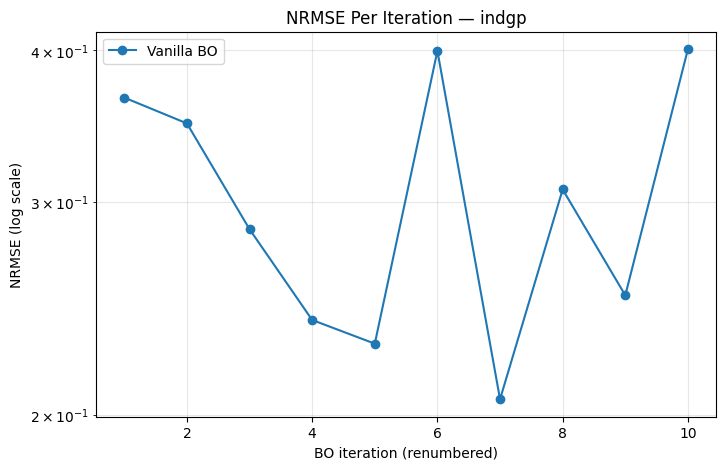

Saved plot to: output/network_2corridor_bo_vanilla/figs/vanilla_bo_nrmse_curve.png


In [66]:
import numpy as np


def compute_nrmse_counts_all_edges_Original(df_true, df_simulated):
    df1 = df_true.merge(
        df_simulated,
        on="edge_id",
        how="left",
        suffixes=("_GT", "_sim")
    )
    df1["interval_nVehContrib_sim"] = df1["interval_nVehContrib_sim"].fillna(0)

    df1["diff_square"] = (
        df1["interval_nVehContrib_GT"] - df1["interval_nVehContrib_sim"]
    ) ** 2

    numerator = np.sqrt(df1["diff_square"].sum() / len(df1))
    denominator = df1["interval_nVehContrib_GT"].mean()
    return numerator / denominator



def compute_nrmse_per_iteration(df_edge_stats, df_gt):
    """
    Computes NRMSE for each BO iteration,
    but returns iteration indices renumbered 1..N.
    """
    # Actual iteration labels (e.g., 20..29)
    iters_raw = sorted(df_edge_stats.bo_iteration.unique())

    print("Raw iteration indices in df_edge_stats:", iters_raw)

    nrmse_list = []

    for it in iters_raw:
        df_sim = df_edge_stats[df_edge_stats.bo_iteration == it]
        curr_nrmse = compute_nrmse_counts_all_edges_Original(df_gt, df_sim)
        nrmse_list.append(curr_nrmse)

    # Renumber them to 1..N
    iters_renumbered = list(range(1, len(iters_raw) + 1))

    return np.array(nrmse_list), iters_renumbered



nrmse_raw, iters = compute_nrmse_per_iteration(df_edge_stats, gt_edge_data)
print("NRMSE curve:", nrmse_raw)
print("Renumbered iterations:", iters)

import matplotlib.pyplot as plt
from pathlib import Path

plt.figure(figsize=(8,5))
plt.plot(iters, nrmse_raw, marker="o", label="Vanilla BO")
plt.yscale("log")
plt.xlabel("BO iteration (renumbered)")
plt.ylabel("NRMSE (log scale)")
plt.title("NRMSE Per Iteration — indgp")
plt.grid(True, which="both", alpha=0.3)
plt.legend()

save_path = Path(f"{config['simulation_run_path']}/figs/vanilla_bo_nrmse_curve.png")
save_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_path, dpi=300)
plt.show()

print("Saved plot to:", save_path)

best value is 0.17 